Estimated tau (ESS, median over runs): 14.126
Data-optimal tau at FAR<=baseline: 14.143  (EDD=3.982)


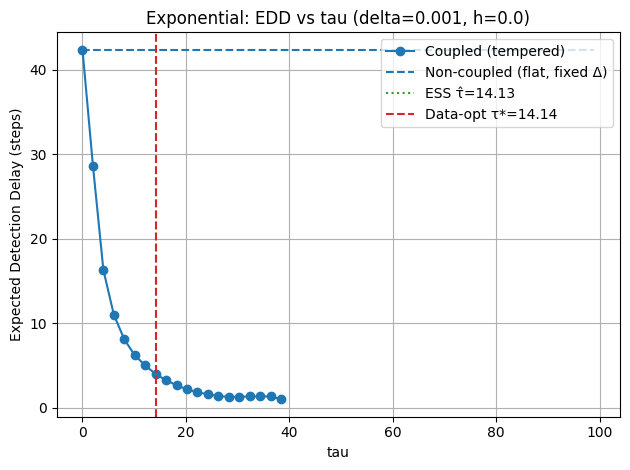

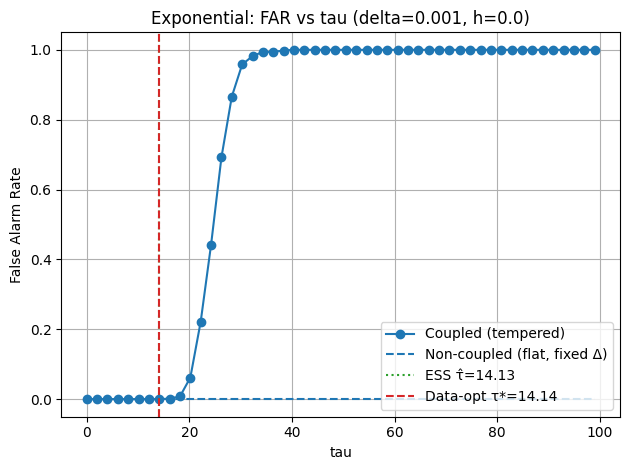

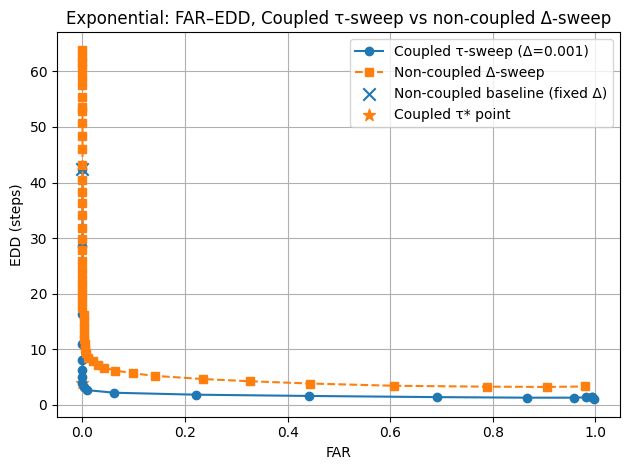

Tau sweep CSV:   exp_tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: exp_delta_sweep_noncoupled.csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 100          # number of series
T = 200         # horizon
t0 = 100        # change time
mu0 = 1.0       # pre-change mean
mu1 = 2.0       # post-change mean
num_changed = 80   # < J for selective coupling

pi = 1/1000
rho = 0.8
a_prior = 1.0   # Gamma(shape=a_prior, rate=b_prior) on rate lambda
b_prior = 1.0
h = 0.0         # score threshold
R = 500         # number of Monte Carlo runs

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 50
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 50)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------

def simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng):
    """
    Simulate a J x T panel where the first num_changed series
    have an exponential mean shift from mu0 to mu1 at time t0,
    and the remaining series stay at mu0.
    """
    X = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            means = np.concatenate([np.full(t0, mu0), np.full(T - t0, mu1)])
        else:
            means = np.full(T, mu0)
        # Exponential with mean mu: scale=mu
        X[j, :] = rng.exponential(scale=means)
    return X


def log_marginal_exp(sum_x, n, a, b):
    """
    Log marginal likelihood (up to a constant) for an exponential
    segment with Gamma(a,b) prior on rate lambda:

    p(x_{1:n}) = (b^a / Gamma(a)) * Gamma(a+n) / (b+S)^{a+n}
    We drop the constant a log b - log Gamma(a), since it cancels
    in all GLR differences.
    """
    return gammaln(a + n) - (a + n) * np.log(b + sum_x)


def Amax_all_t_exp(prefix_row, a, b):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for exponential data.
    prefix_row[k] = sum_{i=1}^k X_i, with prefix_row[0]=0.

    A[t] = max over s=2..t of:
           -L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is log marginal for segment [u,v].
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    sum_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_marginal_exp(sum_1t, ell_1t, a, b)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        sum_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_marginal_exp(sum_1_sm1, ell_1_sm1, a, b)
        # L(s,t)
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_marginal_exp(sum_s_t, ell_s_t, a, b)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A


def precompute_tau_invariants_exp(X, a, b, pi, rho, clip_neg_bf=True):
    """
    Mirror of precompute_tau_invariants, but for exponential data X (float).
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax), i.e. log BF_j(t)
      logGM_excl[t,j]: leave-one-out log-geomean of BF_k(t) over k≠j
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log BF_j(t) (optionally clipped), used for tau estimation
    """
    J, Tlen = X.shape
    prefix = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(X[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_exp(prefix[j], a, b)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    # --- NEW COUPLING: use Bayes factors directly, no shrink X_k ---
    for t in range(2, Tlen + 1):
        # logBF_j(t) = A_vals[t, j]
        logBF = A_vals[t, :]
        if clip_neg_bf:
            # optional: clip negative log-BFs (BF<1) to 0 so other series
            # only ever BOOST, never suppress, the hazard
            logBF = np.maximum(logBF, 0.0)

        # store for ESS estimation
        u_all[t, :] = logBF

        # leave-one-out log-geomean of BF over k≠j
        sum_logBF = np.sum(logBF)
        logGM_excl[t, :] = (sum_logBF - logBF) / (J - 1)
        # Note: with tau in [0, J-1], alarms_for_tau uses:
        # logLambda = log((1-pi) + pi * exp(tau * logGM_excl))
        # => hazard multiplier = (1-pi) + pi * (∏_{k≠j} BF_k)^{tau/(J-1)}
        # which is exactly the new tempered product coupling.

    # Pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no detection before t=2

    # coupling term (unchanged interface, but now logGM_excl is from BFs)
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []

for r in range(R):
    X = simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_exp(
        X, a_prior, b_prior, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"Exponential: EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"Exponential: FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("Exponential: FAR–EDD, Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"exp_tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "exp_delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")


## Above is the new coupling

Estimated tau (ESS, median over runs): 14.858
Data-optimal tau at FAR<=baseline: 16.163  (EDD=3.710)


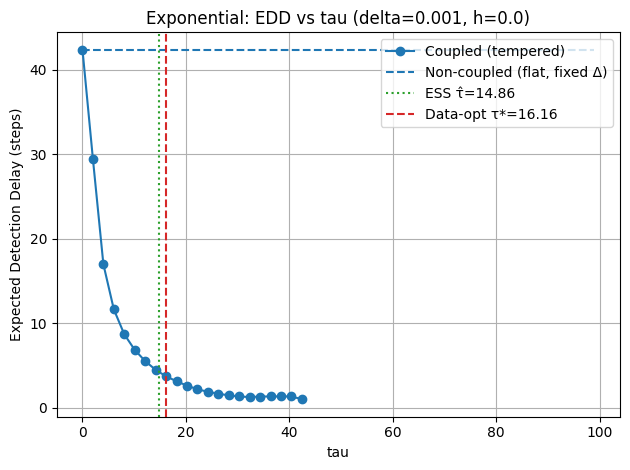

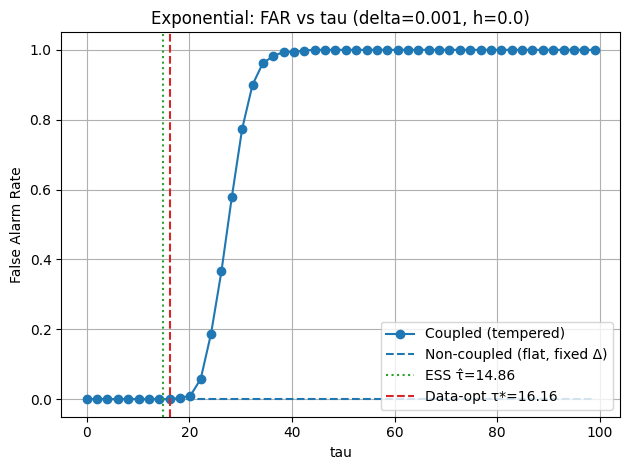

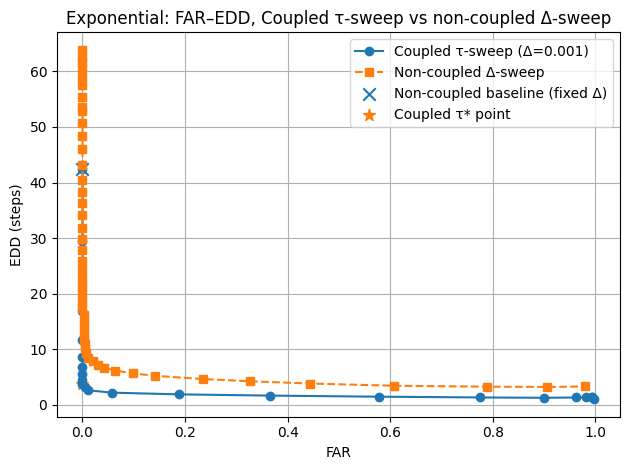

Tau sweep CSV:   exp_tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: exp_delta_sweep_noncoupled.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 100          # number of series
T = 200         # horizon
t0 = 100        # change time
mu0 = 1.0       # pre-change mean
mu1 = 2.0       # post-change mean
num_changed = 80   # < J for selective coupling

pi = 1/1000
rho = 0.8
a_prior = 1.0   # Gamma(shape=a_prior, rate=b_prior) on rate lambda
b_prior = 1.0
h = 0.0         # score threshold
R = 500         # number of Monte Carlo runs

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 50
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 50)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------

def simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng):
    """
    Simulate a J x T panel where the first num_changed series
    have an exponential mean shift from mu0 to mu1 at time t0,
    and the remaining series stay at mu0.
    """
    X = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            means = np.concatenate([np.full(t0, mu0), np.full(T - t0, mu1)])
        else:
            means = np.full(T, mu0)
        # Exponential with mean mu: scale=mu
        X[j, :] = rng.exponential(scale=means)
    return X


def log_marginal_exp(sum_x, n, a, b):
    """
    Log marginal likelihood (up to a constant) for an exponential
    segment with Gamma(a,b) prior on rate lambda:

    p(x_{1:n}) = (b^a / Gamma(a)) * Gamma(a+n) / (b+S)^{a+n}
    We drop the constant a log b - log Gamma(a), since it cancels
    in all GLR differences.
    """
    return gammaln(a + n) - (a + n) * np.log(b + sum_x)


def Amax_all_t_exp(prefix_row, a, b):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for exponential data.
    prefix_row[k] = sum_{i=1}^k X_i, with prefix_row[0]=0.

    A[t] = max over s=2..t of:
           -L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is log marginal for segment [u,v].
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    sum_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_marginal_exp(sum_1t, ell_1t, a, b)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        sum_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_marginal_exp(sum_1_sm1, ell_1_sm1, a, b)
        # L(s,t)
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_marginal_exp(sum_s_t, ell_s_t, a, b)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A


def precompute_tau_invariants_exp(X, a, b, pi, rho, clip_neg_bf=True):
    """
    Mirror of precompute_tau_invariants, but for exponential data X (float).
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) "scores" pre-change, used for tau estimation
    """
    J, Tlen = X.shape
    prefix = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(X[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_exp(prefix[j], a, b)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) in log-space
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no detection before t=2

    # coupling term
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []

for r in range(R):
    X = simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_exp(
        X, a_prior, b_prior, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"Exponential: EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"Exponential: FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("Exponential: FAR–EDD, Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"exp_tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "exp_delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")


# Normal Case

Estimated tau (ESS, median over runs):   26.043
Estimated tau (K_eff, median over runs): 28.934
Median pairwise rho_bar over runs:       0.0144
Data-optimal tau at FAR<=baseline: nan  (EDD=nan)


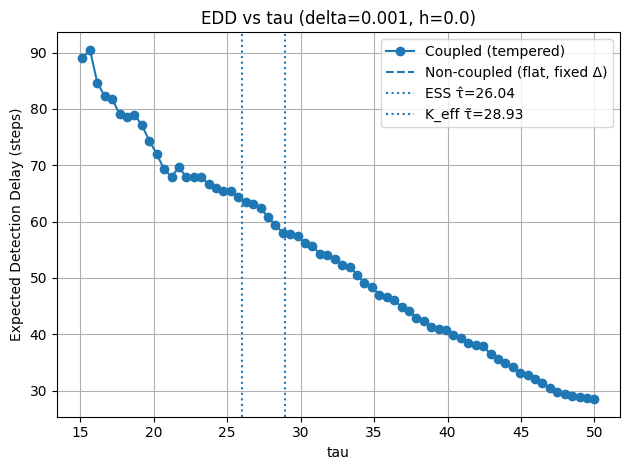

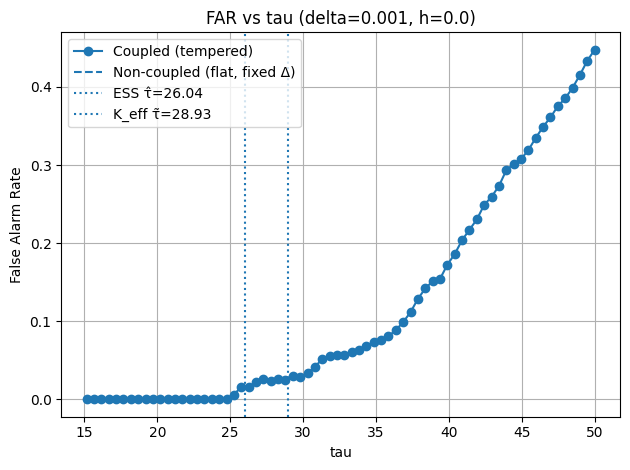

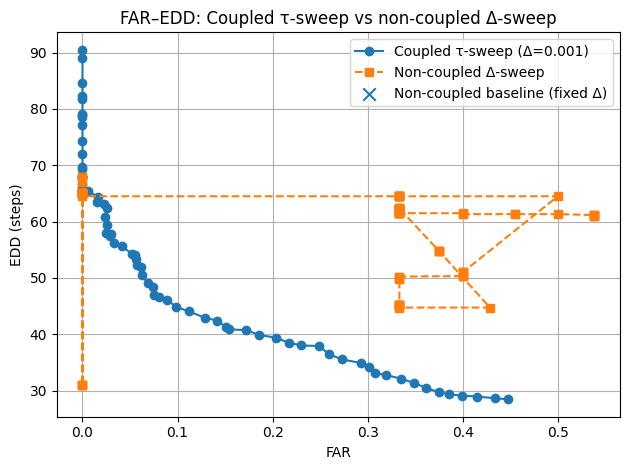

Tau sweep CSV:   tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling

# Normal model hyperparameters
sigma2 = 1.0              # known observation variance
m0 = 0.0                  # prior mean for mu
v0 = 10.0                 # prior variance for mu (fairly vague)

pi = 1/1000
rho = 0.8
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, 50, 100)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.linspace(0.001, 0.05, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers for Normal model
# ---------------------------
def log_marg_norm(n, sum_y, sum_y2, m0, v0, sigma2):
    """
    Log marginal likelihood of y_1,...,y_n under:
        y_i | mu ~ N(mu, sigma2),   sigma2 known
        mu ~ N(m0, v0)

    Inputs can be scalars or NumPy arrays with matching shapes.
    """
    n = np.asarray(n, dtype=float)
    sum_y = np.asarray(sum_y, dtype=float)
    sum_y2 = np.asarray(sum_y2, dtype=float)

    prior_prec = 1.0 / v0
    lik_prec = n / sigma2
    post_prec = prior_prec + lik_prec
    v_n = 1.0 / post_prec

    m_n = v_n * (prior_prec * m0 + (sum_y / sigma2))

    log_const = -0.5 * n * np.log(2.0 * np.pi * sigma2) - 0.5 * np.log(2.0 * np.pi * v0)
    term_data = -0.5 * (sum_y2 / sigma2 + (m0 ** 2) / v0)
    term_post = 0.5 * (m_n ** 2 / v_n) + 0.5 * np.log(2.0 * np.pi * v_n)

    return log_const + term_data + term_post


def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng, sigma2=1.0):
    """
    Simulate Normal observations with known variance sigma2, unknown mean.

      - For changed series j < num_changed:
          Y_{j,t} ~ N(theta0, sigma2) for t < t0
          Y_{j,t} ~ N(theta1, sigma2) for t >= t0
      - For unchanged series j >= num_changed:
          Y_{j,t} ~ N(theta0, sigma2) for all t
    """
    Y = np.zeros((J, T), dtype=float)
    sigma = np.sqrt(sigma2)

    for j in range(J):
        if j < num_changed:
            means = np.concatenate([
                np.full(t0, theta0),
                np.full(T - t0, theta1)
            ])
        else:
            means = np.full(T, theta0)

        Y[j, :] = rng.normal(loc=means, scale=sigma)
    return Y


def Amax_all_t(prefix_sum, prefix_sum_sq, m0, v0, sigma2):
    """
    Compute Amax[t] for t = 1..T (run starts at r=1) for Normal model.

    prefix_sum      : cumulative sums of Y, shape (T+1,)
    prefix_sum_sq   : cumulative sums of Y^2, shape (T+1,)
    Returns:
        A : np.ndarray shape (T+1,) with A[t] = max_s log BF for split at s vs no split.
            A[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    t_idx = np.arange(1, Tlen + 1, dtype=int)
    n_1t = t_idx
    sum_y_1t = prefix_sum[1:] - prefix_sum[0]
    sum_y2_1t = prefix_sum_sq[1:] - prefix_sum_sq[0]
    L_1t = log_marg_norm(n_1t, sum_y_1t, sum_y2_1t, m0, v0, sigma2)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment 1..(s-1)
        n_1_sm1 = s - 1
        sum_y_1_sm1 = prefix_sum[s - 1] - prefix_sum[0]
        sum_y2_1_sm1 = prefix_sum_sq[s - 1] - prefix_sum_sq[0]
        L_1_sm1 = log_marg_norm(n_1_sm1, sum_y_1_sm1, sum_y2_1_sm1, m0, v0, sigma2)

        # Segment s..t
        n_s_t = t - s + 1
        sum_y_s_t = prefix_sum[t] - prefix_sum[s - 1]
        sum_y2_s_t = prefix_sum_sq[t] - prefix_sum_sq[s - 1]
        L_s_t = log_marg_norm(n_s_t, sum_y_s_t, sum_y2_s_t, m0, v0, sigma2)

        vals = -L_1t[t - 1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


def precompute_tau_invariants(Y, pi, rho,
                              clip_neg_bf=True, m0=0.0, v0=10.0, sigma2=1.0):
    """
    Compute per-series single-series evidence A_vals[t,j] under Normal model,
    plus the leave-one-out geometric-mean cross-series evidence, etc.

    Returns:
      A_vals[t,j]    : per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs           : (log1mp, logp) for mixing with prior pi
      u_pre[t,j]     : u = log X_j(t) for t <= t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Cumulative sums and cumulative squared sums
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sum_sq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sum_sq[j, 1:] = np.cumsum(Y[j, :] ** 2)

    # Per-series Amax[t,j]
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix_sum[j, :], prefix_sum_sq[j, :],
                                  m0=m0, v0=v0, sigma2=sigma2)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)

        # logX = log((1-ρ) + ρ * BF) in a numerically stable way
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX

        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0 + 1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_k(t) over pre-change t.
    u_pre: array shape (Tpre, J) with Z_k(t)=log X_k(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    # Extract upper-triangular off-diagonals
    off_diag = C[np.triu_indices(J_here, k=1)]
    # Exclude NaNs (can appear if some series are constant)
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    # Clamp like ESS
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng, sigma2=sigma2)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, pi, rho,
        clip_neg_bf=CLIP_NEG_BF,
        m0=m0, v0=v0, sigma2=sigma2
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)

    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")

plt.axvline(tau_hat_ESS, linestyle=":", label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, linestyle=":", label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")

plt.axvline(tau_hat_ESS, linestyle=":", label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, linestyle=":", label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 11.549
Data-optimal tau at FAR<=baseline: 14.354  (EDD=8.892)


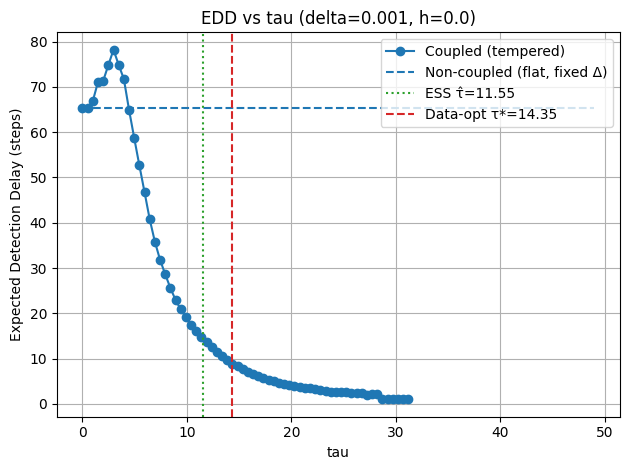

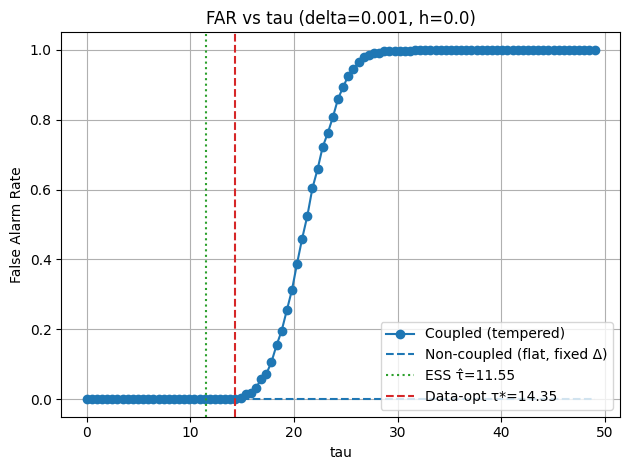

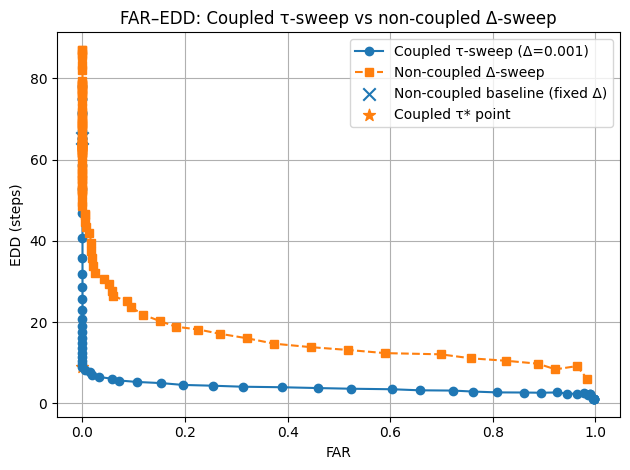

Tau sweep CSV:   tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
# baseline FAR (they are all the same over tau, but take the first one)
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 11.549
Data-optimal tau at FAR<=baseline: 14.354  (EDD=8.892)


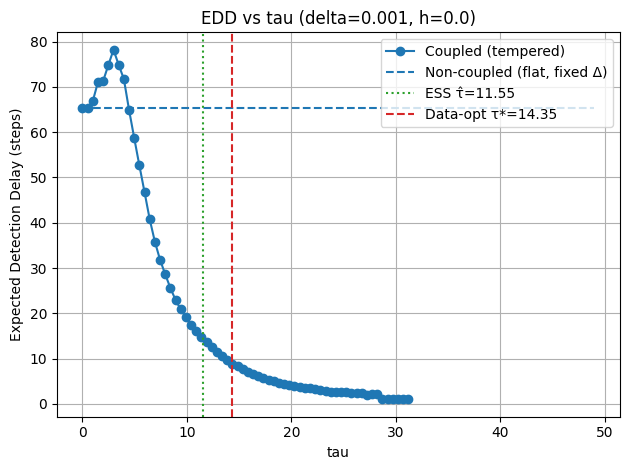

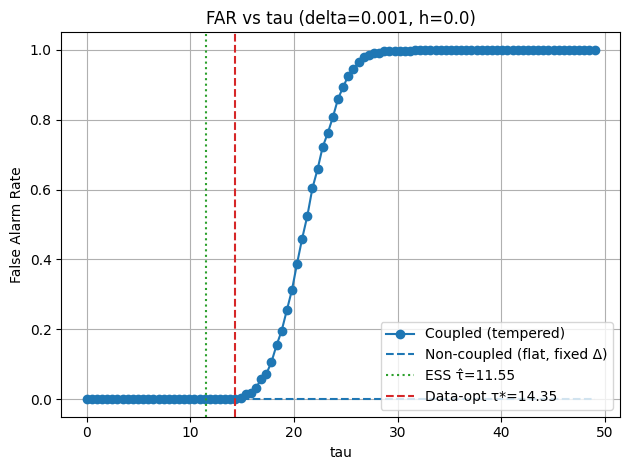

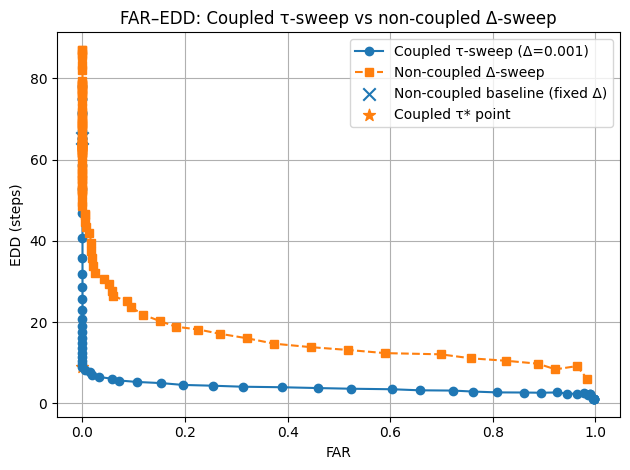

Tau sweep CSV:   tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv
Saved figures: bern_EDD_vs_tau.png, bern_FAR_vs_tau.png, bern_FAR_EDD_tradeoff.png


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J_here, Tlen = Y.shape
    prefix = np.zeros((J_here, Tlen + 1), dtype=int)
    for j in range(J_here):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    for j in range(J_here):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J_here), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J_here - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
# baseline FAR (they are all the same over tau, but take the first one)
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# --- EDD vs tau ---
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bern_EDD_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# --- FAR vs tau ---
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bern_FAR_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("bern_FAR_EDD_tradeoff.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")
print("Saved figures: bern_EDD_vs_tau.png, bern_FAR_vs_tau.png, bern_FAR_EDD_tradeoff.png")

Estimated tau (ESS, median over runs): 13.151
Data-optimal tau at FAR<=baseline: 17.000  (EDD=3.994)


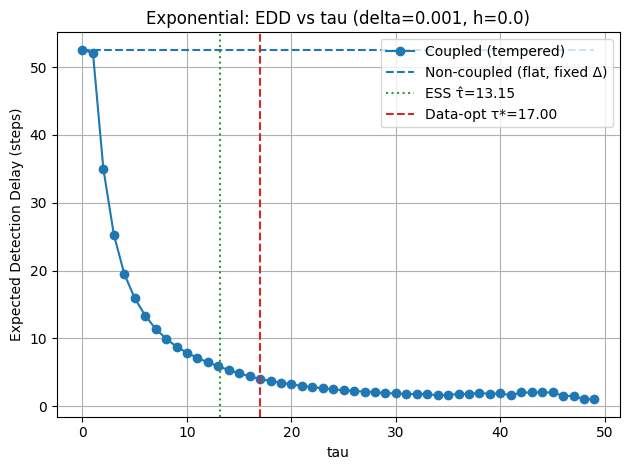

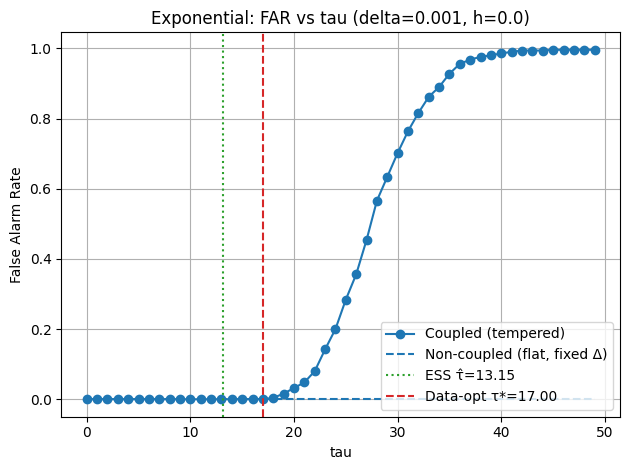

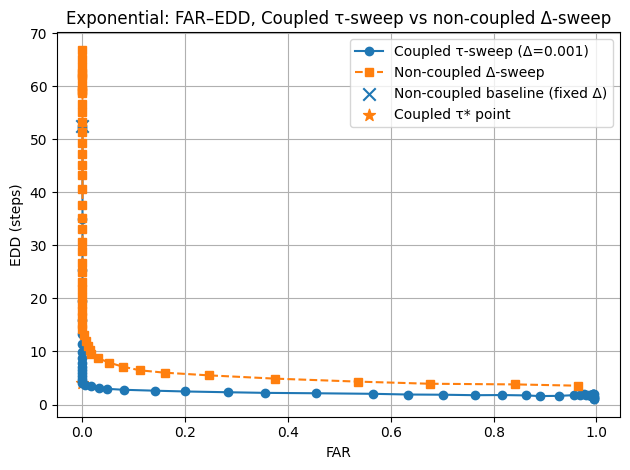

Tau sweep CSV:   exp_tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: exp_delta_sweep_noncoupled.csv
Saved figures: exp_EDD_vs_tau.png, exp_FAR_vs_tau.png, exp_FAR_EDD_tradeoff.png


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50          # number of series
T = 200         # horizon
t0 = 100        # change time
mu0 = 1.0       # pre-change mean
mu1 = 2.0       # post-change mean
num_changed = 40   # < J for selective coupling

pi = 1/1000
rho = 0.8
a_prior = 1.0   # Gamma(shape=a_prior, rate=b_prior) on rate lambda
b_prior = 1.0
h = 0.0         # score threshold
R = 500         # number of Monte Carlo runs

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 50
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 50)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------

def simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng):
    """
    Simulate a J x T panel where the first num_changed series
    have an exponential mean shift from mu0 to mu1 at time t0,
    and the remaining series stay at mu0.
    """
    X = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            means = np.concatenate([np.full(t0, mu0), np.full(T - t0, mu1)])
        else:
            means = np.full(T, mu0)
        # Exponential with mean mu: scale=mu
        X[j, :] = rng.exponential(scale=means)
    return X


def log_marginal_exp(sum_x, n, a, b):
    """
    Log marginal likelihood (up to a constant) for an exponential
    segment with Gamma(a,b) prior on rate lambda:

    p(x_{1:n}) = (b^a / Gamma(a)) * Gamma(a+n) / (b+S)^{a+n}
    We drop the constant a log b - log Gamma(a), since it cancels
    in all GLR differences.
    """
    return gammaln(a + n) - (a + n) * np.log(b + sum_x)


def Amax_all_t_exp(prefix_row, a, b):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for exponential data.
    prefix_row[k] = sum_{i=1}^k X_i, with prefix_row[0]=0.

    A[t] = max over s=2..t of:
           -L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is log marginal for segment [u,v].
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    sum_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_marginal_exp(sum_1t, ell_1t, a, b)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        sum_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_marginal_exp(sum_1_sm1, ell_1_sm1, a, b)
        # L(s,t)
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_marginal_exp(sum_s_t, ell_s_t, a, b)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A


def precompute_tau_invariants_exp(X, a, b, pi, rho, clip_neg_bf=True):
    """
    Mirror of precompute_tau_invariants, but for exponential data X (float).
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) "scores" pre-change, used for tau estimation
    """
    J_here, Tlen = X.shape
    prefix = np.zeros((J_here, Tlen + 1), dtype=float)
    for j in range(J_here):
        prefix[j, 1:] = np.cumsum(X[j, :])

    A_vals = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    for j in range(J_here):
        A_vals[:, j] = Amax_all_t_exp(prefix[j], a, b)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J_here), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) in log-space
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J_here - 1)

    # Pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0] - 1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no detection before t=2

    # coupling term
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []

for r in range(R):
    X = simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_exp(
        X, a_prior, b_prior, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# --- EDD vs tau ---
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"Exponential: EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("exp_EDD_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# --- FAR vs tau ---
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"Exponential: FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("exp_FAR_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("Exponential: FAR–EDD, Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("exp_FAR_EDD_tradeoff.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"exp_tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "exp_delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")
print("Saved figures: exp_EDD_vs_tau.png, exp_FAR_vs_tau.png, exp_FAR_EDD_tradeoff.png")

Estimated tau (ESS, median over runs): 13.151
Data-optimal tau at FAR<=baseline: 17.000  (EDD=3.994)


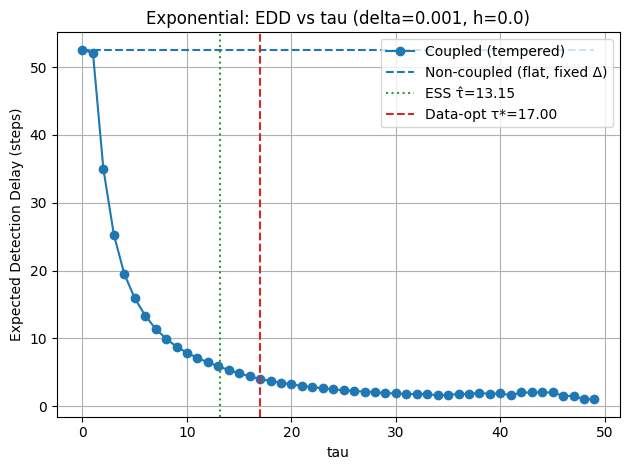

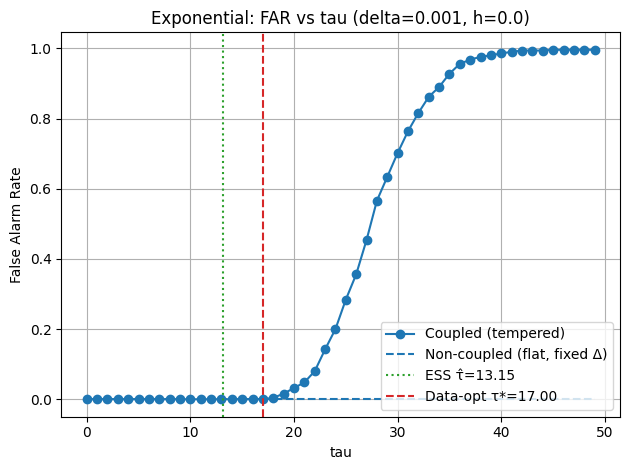

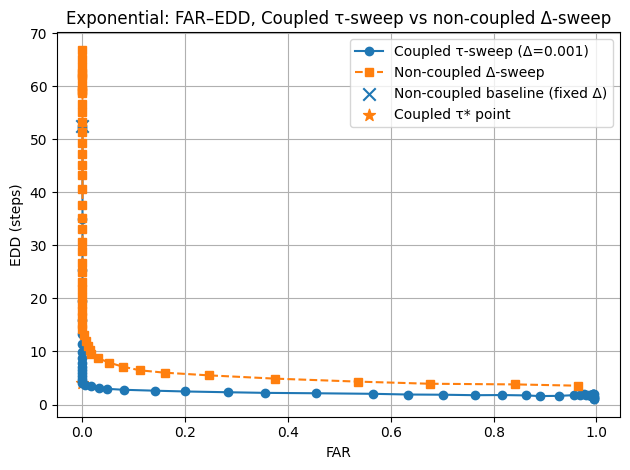

Tau sweep CSV:   exp_tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: exp_delta_sweep_noncoupled.csv


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50          # number of series
T = 200         # horizon
t0 = 100        # change time
mu0 = 1.0       # pre-change mean
mu1 = 2.0       # post-change mean
num_changed = 40   # < J for selective coupling

pi = 1/1000
rho = 0.8
a_prior = 1.0   # Gamma(shape=a_prior, rate=b_prior) on rate lambda
b_prior = 1.0
h = 0.0         # score threshold
R = 500         # number of Monte Carlo runs

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 50
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 50)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------

def simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng):
    """
    Simulate a J x T panel where the first num_changed series
    have an exponential mean shift from mu0 to mu1 at time t0,
    and the remaining series stay at mu0.
    """
    X = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            means = np.concatenate([np.full(t0, mu0), np.full(T - t0, mu1)])
        else:
            means = np.full(T, mu0)
        # Exponential with mean mu: scale=mu
        X[j, :] = rng.exponential(scale=means)
    return X


def log_marginal_exp(sum_x, n, a, b):
    """
    Log marginal likelihood (up to a constant) for an exponential
    segment with Gamma(a,b) prior on rate lambda:

    p(x_{1:n}) = (b^a / Gamma(a)) * Gamma(a+n) / (b+S)^{a+n}
    We drop the constant a log b - log Gamma(a), since it cancels
    in all GLR differences.
    """
    return gammaln(a + n) - (a + n) * np.log(b + sum_x)


def Amax_all_t_exp(prefix_row, a, b):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for exponential data.
    prefix_row[k] = sum_{i=1}^k X_i, with prefix_row[0]=0.

    A[t] = max over s=2..t of:
           -L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is log marginal for segment [u,v].
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    sum_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_marginal_exp(sum_1t, ell_1t, a, b)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        sum_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_marginal_exp(sum_1_sm1, ell_1_sm1, a, b)
        # L(s,t)
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_marginal_exp(sum_s_t, ell_s_t, a, b)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A


def precompute_tau_invariants_exp(X, a, b, pi, rho, clip_neg_bf=True):
    """
    Mirror of precompute_tau_invariants, but for exponential data X (float).
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) "scores" pre-change, used for tau estimation
    """
    J, Tlen = X.shape
    prefix = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(X[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_exp(prefix[j], a, b)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) in log-space
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no detection before t=2

    # coupling term
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []

for r in range(R):
    X = simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_exp(
        X, a_prior, b_prior, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"Exponential: EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"Exponential: FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("Exponential: FAR–EDD, Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"exp_tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "exp_delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 4.000
Data-optimal tau at FAR<=baseline: nan  (EDD=nan)


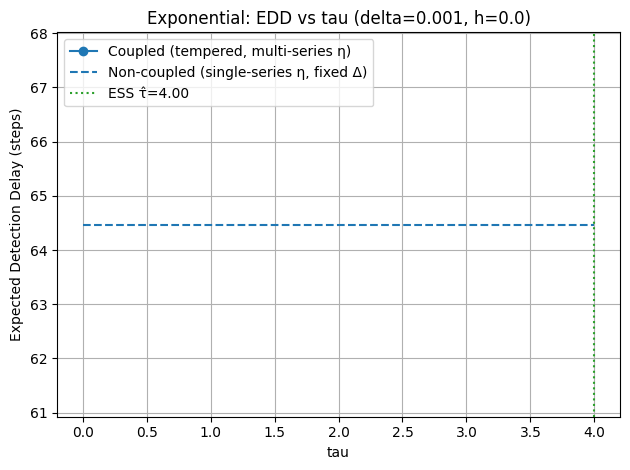

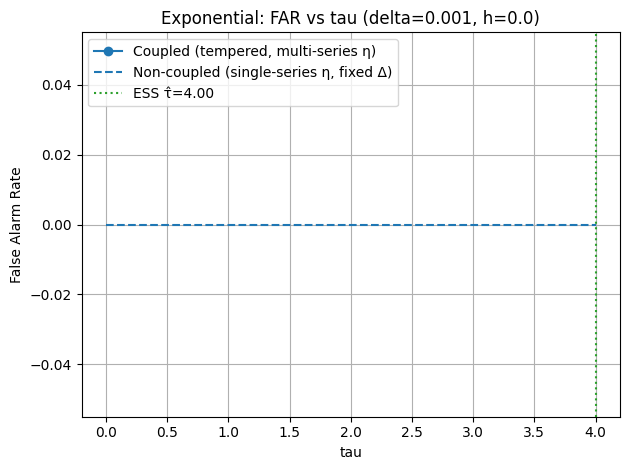

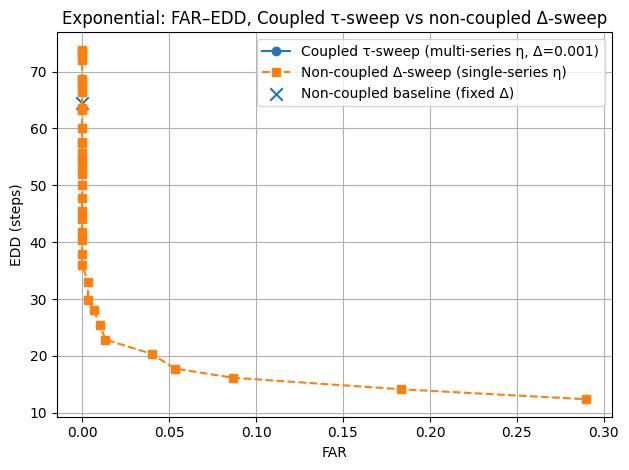

Tau sweep CSV:   exp_tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: exp_delta_sweep_noncoupled.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 5          # number of series (this will be k in the theory)
T = 200         # horizon
t0 = 100        # change time
mu0 = 1.0       # pre-change mean
mu1 = 2.0       # post-change mean
num_changed = 4   # < J for selective coupling

pi = 1/1000     # per-series prior prob of change
rho = 0.8       # mixing weight for BF vs null
a_prior = 1.0   # Gamma(shape=a_prior, rate=b_prior) on rate lambda
b_prior = 1.0

h = 0.0         # score threshold
R = 300         # number of Monte Carlo runs (adjust as you like)

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 40
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 40)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# alpha used in the theoretical Xi_t/eta bound (not the Gamma prior)
alpha_eta = 1.0   # > 1


# ---------------------------
# Helpers: exponential model
# ---------------------------

def simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng):
    """
    Simulate a J x T panel where the first num_changed series
    have an exponential mean shift from mu0 to mu1 at time t0,
    and the remaining series stay at mu0.
    """
    X = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            means = np.concatenate([np.full(t0, mu0), np.full(T - t0, mu1)])
        else:
            means = np.full(T, mu0)
        # Exponential with mean mu: scale=mu
        X[j, :] = rng.exponential(scale=means)
    return X


def log_marginal_exp(sum_x, n, a, b):
    """
    Log marginal likelihood (up to a constant) for an exponential
    segment with Gamma(a,b) prior on rate lambda:

    p(x_{1:n}) = (b^a / Gamma(a)) * Gamma(a+n) / (b+S)^{a+n}

    We drop the constant a log b - log Gamma(a), since it cancels
    in all GLR differences.
    """
    return gammaln(a + n) - (a + n) * np.log(b + sum_x)


def Amax_all_t_exp(prefix_row, a, b):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for exponential data.
    prefix_row[k] = sum_{i=1}^k X_i, with prefix_row[0]=0.

    A[t] = max over s=2..t of:
           -L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is log marginal for segment [u,v].
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    sum_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_marginal_exp(sum_1t, ell_1t, a, b)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        sum_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_marginal_exp(sum_1_sm1, ell_1_sm1, a, b)
        # L(s,t)
        sum_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_marginal_exp(sum_s_t, ell_s_t, a, b)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A


def precompute_tau_invariants_exp(X, a, b, pi, rho, clip_neg_bf=True):
    """
    Mirror of your Bernoulli precompute, but for exponential data X (float).
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) "scores" pre-change, used for tau estimation
    """
    J, Tlen = X.shape
    prefix = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(X[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_exp(prefix[j], a, b)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) in log-space
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


# ---------------------------
# Eta schedules
# ---------------------------

def single_logeta_time_only(Tlen, delta):
    """
    Old single-series time-only eta:
       eta_t ~ delta^2 / [(t+1) log(t+1)]
    as in your original code.
    """
    t = np.arange(Tlen + 1, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # no detection before t=2
    return logeta


def coupled_logeta_joint(Tlen, delta, k, alpha):
    """
    Coupled (multi-series) time-only eta, based on your joint FAR bound:

    eta_t <= (1/10^k) * [Xi_t(delta,k,alpha)]^{k*alpha}

    with (crude but explicit lower bound)
      Xi_t >= log(2)*log^4(alpha)*delta^2 /
              [16 k^2 t log^2(alpha t) log^4 t].

    We implement that Xi_t and then take logeta_t.
    """
    # t indices: 0..Tlen, but we only care about t>=2
    t = np.arange(Tlen + 1, dtype=float)

    # Use n_rt >= 3 to avoid log(1)=0 and log(0)
    n_rt = np.maximum(t, 3.0)

    log_alpha = np.log(alpha)
    # numerator: log(2)*log^4(alpha)*delta^2
    num = np.log(2.0) * (log_alpha**4) * (delta**2)
    # denominator: 16 k^2 n_rt log^2(alpha n_rt) log^4 n_rt
    den = 16.0 * n_rt * (np.log(alpha * n_rt)**2) * (np.log(n_rt)**4)

    Xi_t = num / den
    # numerical safety
    Xi_t = np.clip(Xi_t, 1e-300, 1.0)

    # log eta_t = -k log 10 + k*alpha * log(Xi_t)
    logeta = -  np.log(10.0) +  alpha * np.log(Xi_t)

    # No detection before t=2
    logeta[:2] = -np.inf
    return logeta


# ---------------------------
# Alarms for given tau
# ---------------------------

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, k, alpha_eta):
    """
    For fixed tau, build the coupled and non-coupled scores and
    return (t_alarm_coupled, t_alarm_noncoupled).

    Coupled uses the *multi-series* eta schedule (coupled_logeta_joint).
    Non-coupled uses the *single-series* eta schedule (single_logeta_time_only).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    # Time-only eta schedules
    logeta_c = coupled_logeta_joint(Tlen, delta, k, alpha_eta)
    logeta_n = single_logeta_time_only(Tlen, delta)

    # coupling term (same as before)
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta_c[:, None]
    S_n = A_vals + logeta_n[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Uses single-series eta schedule only.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    logeta = single_logeta_time_only(Tlen, delta)
    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []

for r in range(R):
    X = simulate_panel_exp(T, t0, J, num_changed, mu0, mu1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_exp(
        X, a_prior, b_prior, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
k_series = J   # use all series in the coupled FAR bound

for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs,
                                  delta_fixed, tau, k_series, alpha_eta)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)
    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered, multi-series η)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (single-series η, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"Exponential: EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered, multi-series η)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (single-series η, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"Exponential: FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled Δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (multi-series η, Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep (single-series η)")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("Exponential: FAR–EDD, Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"exp_tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "exp_delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs):   11.549
Estimated tau (K_eff, median over runs): 11.861
Median pairwise rho_bar over runs:       0.0652
Data-optimal tau at FAR<=baseline: 14.354  (EDD=8.892)


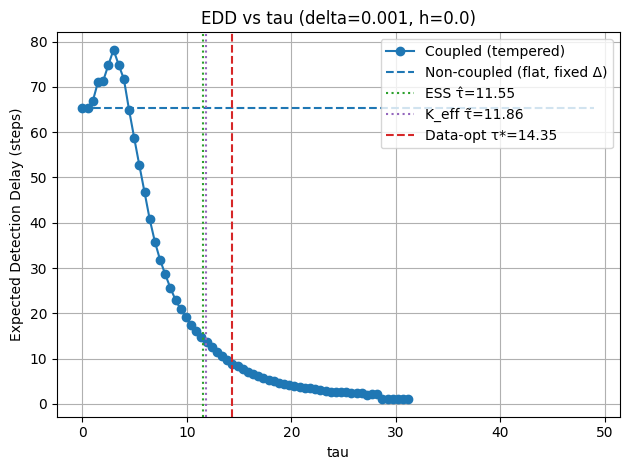

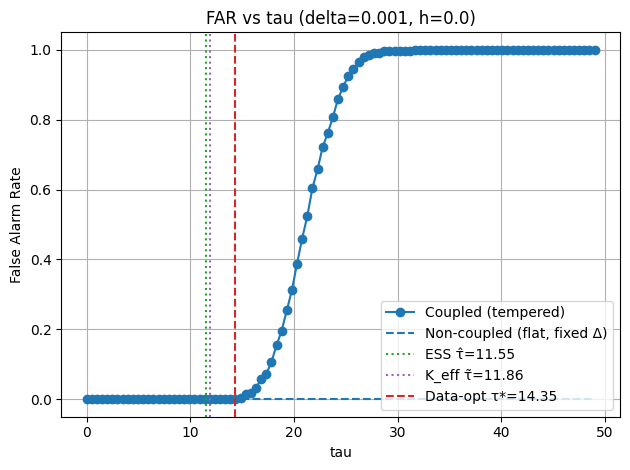

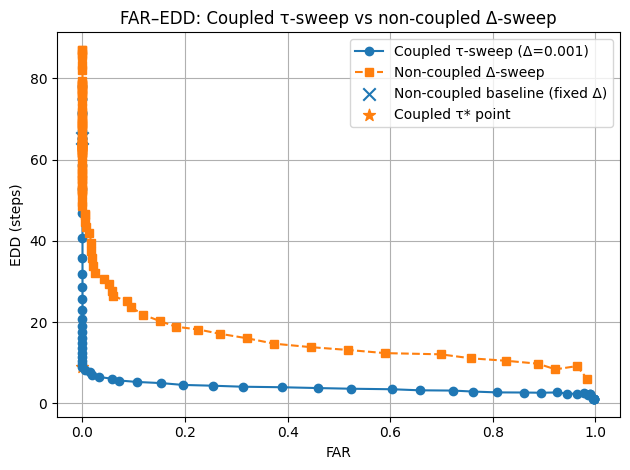

Tau sweep CSV:   tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

# NEW: K_eff-based tau estimator from empirical pairwise correlations
def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of Z_k(t) over pre-change t.
    u_pre: array shape (Tpre, J) with Z_k(t)=log X_k(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan
    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    # Extract upper-triangular off-diagonals
    off_diag = C[np.triu_indices(J_here, k=1)]
    # Exclude NaNs (can appear if some series are constant)
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    # Clamp like ESS
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar

def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []   # NEW
rho_bar_runs = []    # NEW

for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)

    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
# baseline FAR (they are all the same over tau, but take the first one)
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 12.500
Data-optimal tau at FAR<=baseline: 15.000  (EDD=6.496)


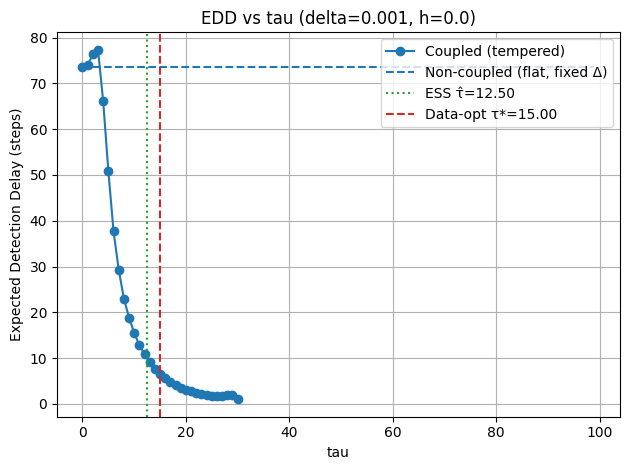

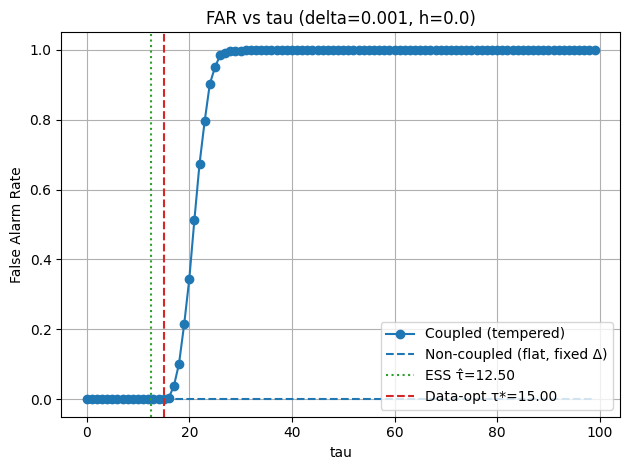

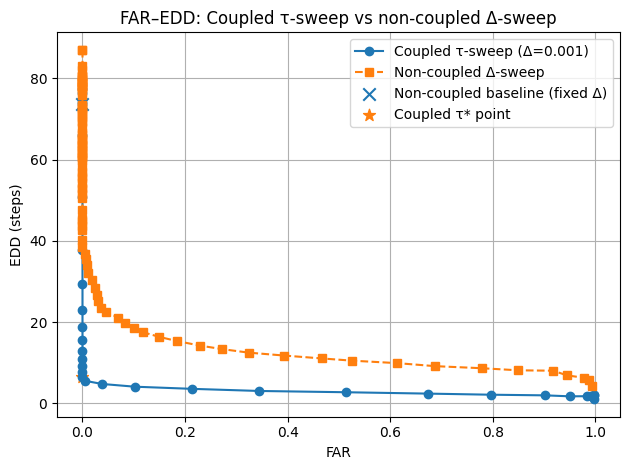

Tau sweep CSV:   tau_sweep_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 100
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 80          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
# baseline FAR (they are all the same over tau, but take the first one)
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 8.752
Data-optimal tau at FAR<=baseline: 10.747  (EDD=7.702)


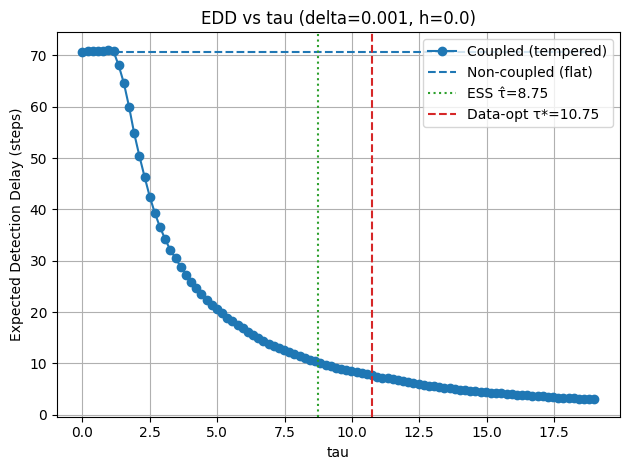

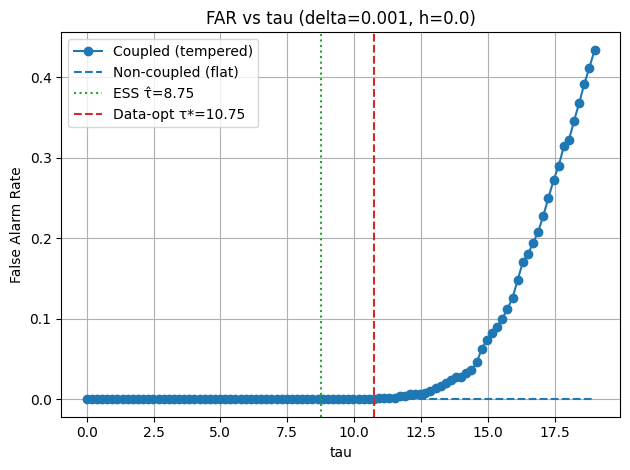

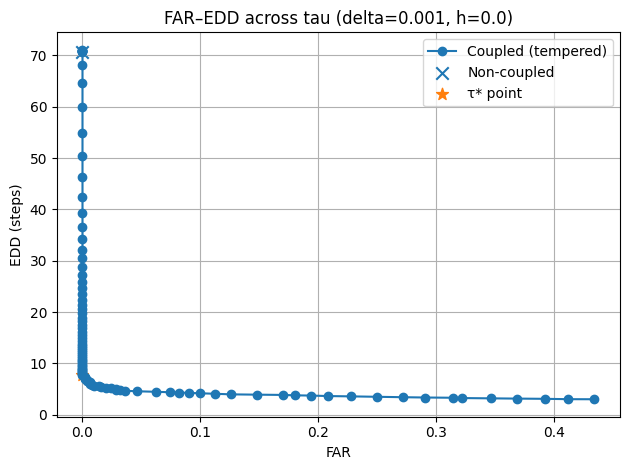

Tau sweep CSV: tau_sweep_WITH_tauhat_delta_0.001000.csv


In [17]:
# Tau-sweep + tau estimation (ESS + data-optimal) for tempered coupling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design (your case)
# ---------------------------
J = 20
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.5
num_changed = 18          # < J for selective coupling
pi = 1/1000
rho = 0.9
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Fix delta and sweep tau
delta = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    # Center each time by its cross-sectional mean? Not needed for variance over time.
    # We need:
    #  - var_k = Var_t(u_k(t)) per series k
    #  - vbar = mean_k var_k
    #  - var_w = Var_t( mean_k u_k(t) )  (uniform weights)
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def alarms_for_tau(A_vals, logGM_excl, logs, delta, h, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        return float(idx[0]) if idx.size > 0 else np.nan

    return first_alarm(S_c), first_alarm(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))

# ---------------------------
# Sweep tau and summarize FAR / EDD
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta, h, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "tau": tau,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# ---------------------------
# Compute data-optimal tau at target FAR (non-coupled baseline)
# ---------------------------
far_baseline = results.loc[results["detector"]=="noncoupled", "FAR"].iloc[0]
coupled = results[results["detector"]=="coupled_tempered"].copy()
# best EDD subject to FAR <= baseline (with small tolerance)
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")
print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Plots: EDD vs tau and FAR vs tau, with vertical markers
# ---------------------------
mask_c = results["detector"] == "coupled_tempered"
mask_n = results["detector"] == "noncoupled"

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"], marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n, "EDD"].iloc[0], xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":", label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--", label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau"); plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"], marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n, "FAR"].iloc[0], xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":", label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--", label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau"); plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Optional: EDD vs FAR parametric curve across tau
plt.figure()
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], marker="o", label="Coupled (tempered)")
plt.scatter(results.loc[mask_n, "FAR"].iloc[0], results.loc[mask_n, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled")
if np.isfinite(tau_star):
    row_star = coupled[coupled["tau"]==tau_star].iloc[0]
    plt.scatter(row_star["FAR"], row_star["EDD"], s=80, marker="*", label="τ* point")
plt.xlabel("FAR"); plt.ylabel("EDD (steps)")
plt.title(f"FAR–EDD across tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------------------------
# Save CSV
# ---------------------------
out_path = f"tau_sweep_WITH_tauhat_delta_{delta:.6f}.csv"
results.to_csv(out_path, index=False)
print(f"Tau sweep CSV: {out_path}")


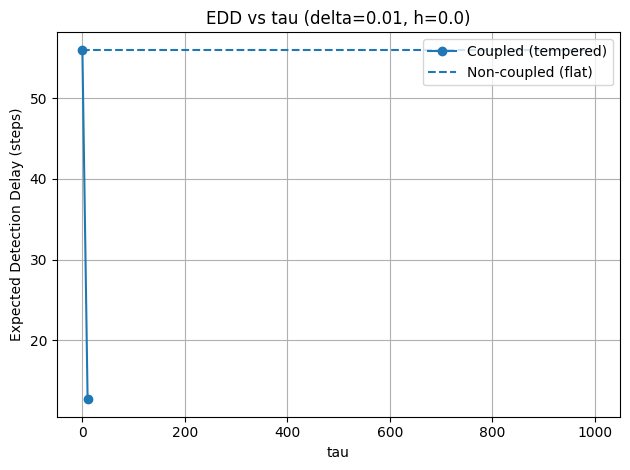

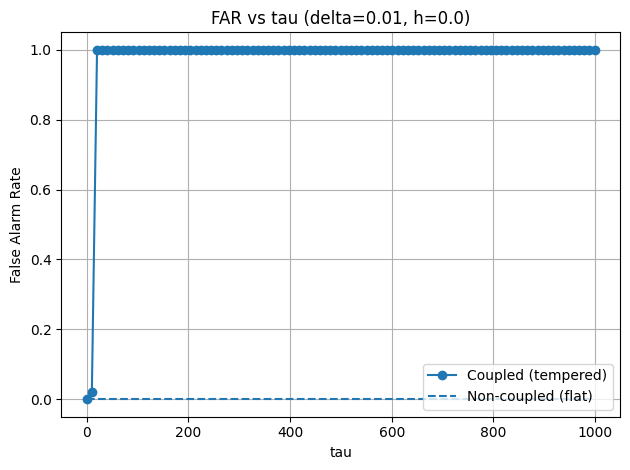

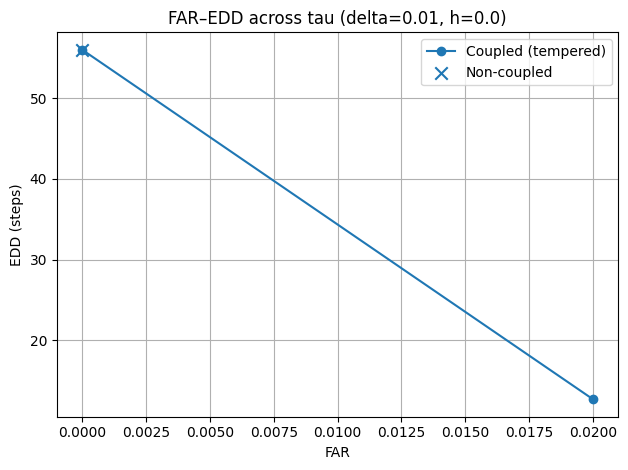

Tau sweep CSV: tau_sweep_coupled_tempered_vs_noncoupled_delta_0.010000.csv


In [11]:
# Tau-sweep simulation: FAR–EDD vs tau for tempered-coupled vs non-coupled
# Fix delta, sweep tau in [0, J-1]
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ---------------------------
# Repro
# ---------------------------
rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 1000
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.3
num_changed = 900          # set < J to see selective coupling effects
pi = 1/1000
rho = 0.9
alpha = 1.0
beta = 1.0
h = 0.0
R = 50

# Fix delta (spending schedule) and sweep tau
delta = 0.01              # choose your favorite fixed delta
N_TAU = 99                 # grid resolution for tau
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] covers no-coupling to full product LR

# Toggle: clip negative A (i.e., only boosting). Set to False to allow damping pre-change.
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    # Build logX_k(t) and leave-one-out log-geomean base
    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX  = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        sum_logX   = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base
    return A_vals, logGM_excl, (log1mp, logp)

def alarms_for_tau(A_vals, logGM_excl, logs, delta, h, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        return float(idx[0]) if idx.size > 0 else np.nan

    return first_alarm(S_c), first_alarm(S_n)

# ---------------------------
# Simulate R runs and precompute tau-invariants once/run
# ---------------------------
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    precomp_list.append((A_vals, logGM_excl, logs))

# ---------------------------
# Sweep tau and summarize FAR / EDD
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta, h, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "tau": tau,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau
# ---------------------------
mask_c = results["detector"] == "coupled_tempered"
mask_n = results["detector"] == "noncoupled"

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"], marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n, "EDD"].iloc[0], xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat)")
plt.xlabel("tau"); plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"], marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n, "FAR"].iloc[0], xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat)")
plt.xlabel("tau"); plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Optional: EDD vs FAR parametric curve across tau
plt.figure()
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], marker="o", label="Coupled (tempered)")
plt.scatter(results.loc[mask_n, "FAR"].iloc[0], results.loc[mask_n, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled")
plt.xlabel("FAR"); plt.ylabel("EDD (steps)")
plt.title(f"FAR–EDD across tau (delta={delta}, h={h})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ---------------------------
# Save CSV
# ---------------------------
out_path = f"tau_sweep_coupled_tempered_vs_noncoupled_delta_{delta:.6f}.csv"
results.to_csv(out_path, index=False)
print(f"Tau sweep CSV: {out_path}")

# ---------------------------
# Notes:
# - Increase pi (e.g., 0.01) or reduce CLIP_NEG_BF to see stronger coupling effects.
# - If num_changed < J, coupling becomes more selective; with num_changed == J, all series move together.
# - To estimate tau via effective sample size, compute Cov(logX) on pre-change and set tau ≈ n_eff (see discussion).
# ---------------------------

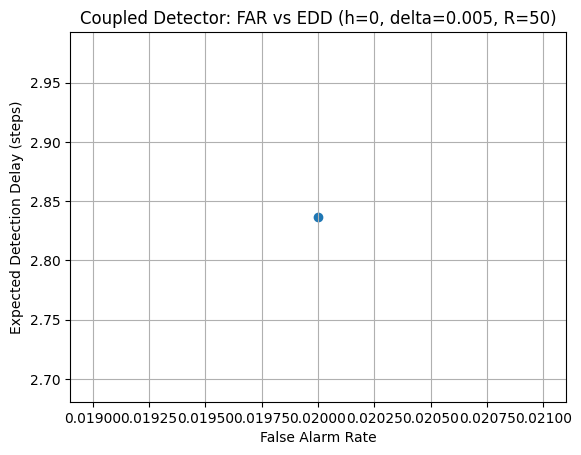

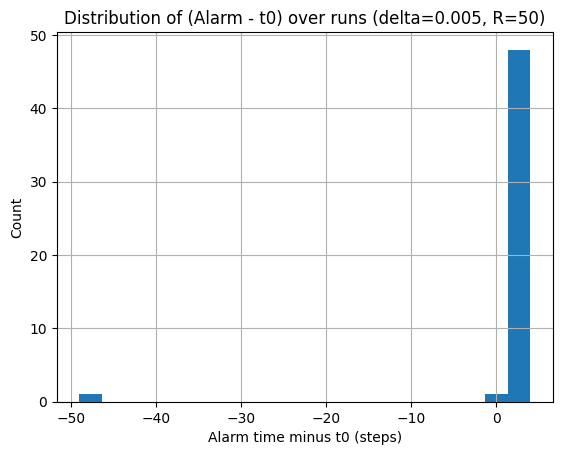

Summary CSV: summary_delta0p005_R50.csv
Per-run CSV: per_run_results_delta0p005_R50.csv


In [2]:
# Re-run with delta=0.005 and R=50 (to avoid timeout), keeping all other settings the same
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)  # seed for reproducibility

# ----- Parameters -----
J = 10
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.8
num_changed = 9
pi = 1/100     # prior prob of a global day
rho = 0.9
alpha = 1.0
beta = 1.0
delta = 0.005  # decreased
h = 0.0
R = 50         # runs

# ----- Utilities -----
def log_beta(a: float, b: float) -> float:
    return math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b)

def L_segment(prefix: np.ndarray, a: int, b: int, alpha: float, beta: float) -> float:
    m = prefix[b] - prefix[a-1]
    ell = b - a + 1
    return log_beta(alpha + m, beta + ell - m) - log_beta(alpha, beta)

def Amax_for_run(prefix: np.ndarray, r: int, t: int, alpha: float, beta: float) -> float:
    if t <= r:
        return float("-inf")
    L_rt = L_segment(prefix, r, t, alpha, beta)
    best = float("-inf")
    for s in range(r+1, t+1):
        val = -L_rt + L_segment(prefix, r, s-1, alpha, beta) + L_segment(prefix, s, t, alpha, beta)
        if val > best:
            best = val
    return best

def log_eta_base(n: int, delta: float) -> float:
    # η_base(n) = δ^2 / ((n+1) log(n+1))
    return math.log(delta*delta) - (math.log(n+1) + math.log(math.log(n+1)))

def simulate_panel(T: int, t0: int, J: int, num_changed: int, theta0: float, theta1: float, rng) -> np.ndarray:
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def first_alarm_time(Y: np.ndarray, pi: float, rho: float, alpha: float, beta: float,
                     delta: float, h: float) -> int:
    J, T = Y.shape
    r = np.ones(J, dtype=int)
    prefix = np.zeros((J, T+1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])
    for t in range(1, T+1):
        A_vals = np.empty(J, dtype=float)
        for j in range(J):
            A_vals[j] = Amax_for_run(prefix[j], int(r[j]), t, alpha, beta)
        logBF = np.maximum(A_vals, 0.0)  # GLRT surrogate
        term_k = np.logaddexp(np.log(1 - rho), (np.log(rho) + logBF))
        sum_terms = term_k.sum()
        logLambda_minus_j = np.empty(J, dtype=float)
        for j in range(J):
            g = sum_terms - term_k[j]
            logLambda_minus_j[j] = np.logaddexp(np.log(1 - pi), np.log(pi) + g)
        for j in range(J):
            n = t - r[j] + 1
            score = A_vals[j] + log_eta_base(n, delta) + logLambda_minus_j[j]
            if score >= h:
                return t
    return None

# ----- Replications -----
alarm_times = []
for rep in range(R):
    Y = simulate_panel(T=T, t0=t0, J=J, num_changed=num_changed, theta0=theta0, theta1=theta1, rng=rng)
    t_alarm = first_alarm_time(Y, pi=pi, rho=rho, alpha=alpha, beta=beta, delta=delta, h=h)
    alarm_times.append(t_alarm if t_alarm is not None else np.nan)

alarm_times = np.array(alarm_times, dtype=float)

# ----- Metrics -----
false_alarms = np.sum(alarm_times < t0)
far = false_alarms / R
valid_dd = alarm_times[alarm_times >= t0] - t0
edd = float(np.nanmean(valid_dd)) if valid_dd.size > 0 else np.nan
edd_med = float(np.nanmedian(valid_dd)) if valid_dd.size > 0 else np.nan

summary_df = pd.DataFrame({
    "Replications": [R],
    "Threshold h": [h],
    "pi": [pi],
    "rho": [rho],
    "delta": [delta],
    "Change time t0": [t0],
    "Horizon T": [T],
    "False alarm rate": [far],
    "Expected detection delay": [edd],
    "Median detection delay": [edd_med],
    "Detections after t0 (count)": [int(np.sum(alarm_times >= t0))]
})

# Save and display
summary_path = "summary_delta0p005_R50.csv"
perrun_path = "per_run_results_delta0p005_R50.csv"
summary_df.to_csv(summary_path, index=False)

results_df = pd.DataFrame({
    "run": np.arange(1, R+1),
    "alarm_time": alarm_times,
    "is_false_alarm": alarm_times < t0
})
results_df.to_csv(perrun_path, index=False)

# ----- Plots -----
plt.figure()
plt.scatter([far], [edd])
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("Coupled Detector: FAR vs EDD (h=0, delta=0.005, R=50)")
plt.grid(True)
plt.show()

rel_times = alarm_times - t0
rel_times_plot = rel_times[np.isfinite(rel_times)]
plt.figure()
plt.hist(rel_times_plot, bins=20)
plt.xlabel("Alarm time minus t0 (steps)")
plt.ylabel("Count")
plt.title("Distribution of (Alarm - t0) over runs (delta=0.005, R=50)")
plt.grid(True)
plt.show()

print(f"Summary CSV: {summary_path}")
print(f"Per-run CSV: {perrun_path}")


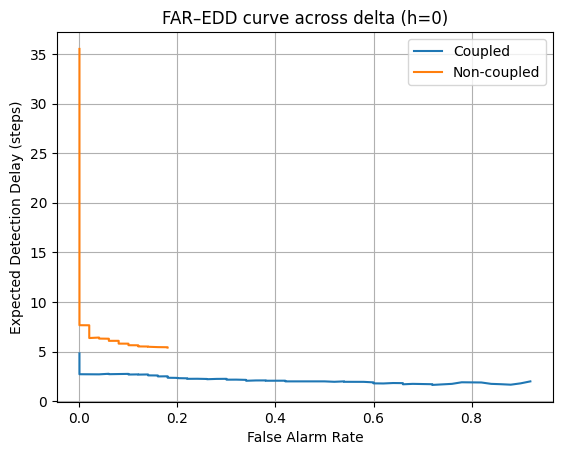

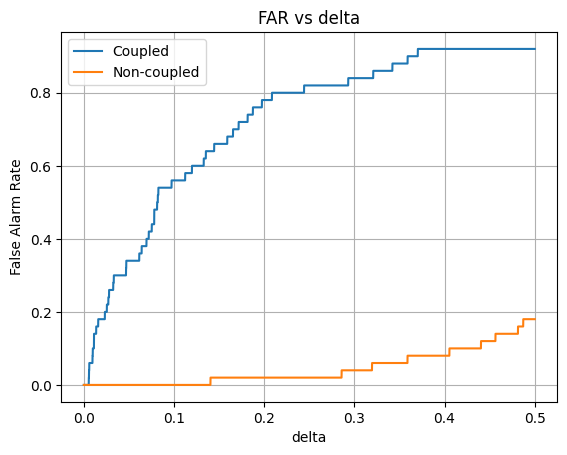

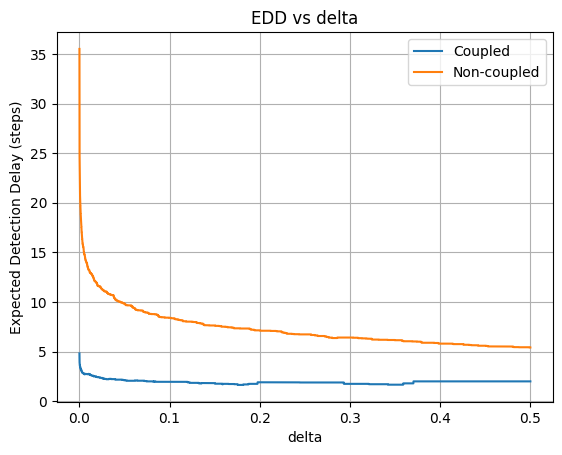

Delta sweep CSV: delta_sweep_coupled_vs_noncoupled.csv


In [7]:
# Delta-sweep simulation: FAR–EDD curves for coupled vs non-coupled
# Deltas from 0.0001 to 0.01 in 0.0001 steps, R=50 runs
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# --- Fixed experiment design ---
J = 10
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.8
num_changed = 9
pi = 1/100
rho = 0.9
alpha = 1.0
beta = 1.0
h = 0.0
R = 50

deltas = np.arange(1, 50001) * 1e-5  # 0.0001 ... 0.0100

# --- Helpers ---
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1.
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)
    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)
    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = (s-1) - 1 + 1  # = s-1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_for_run(Y, alpha, beta, pi, rho):
    """
    For a given panel Y (J x T), precompute:
    - A_vals[t, j] = Amax for series j at time t
    - logLambda[t, j] = coupling log-factor for series j at time t
    Returns (A_vals, logLambda) with shape (T+1, J) each.
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    # Compute logLambda_{-j}(t) for all t, j
    logLambda = np.zeros((Tlen + 1, J), dtype=float)
    log1mr = np.log(1 - rho)
    logr = np.log(rho)
    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    # For t where t<2, leave zeros (no effect since A is -inf)
    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        term_k = np.logaddexp(log1mr, logr + logBF)  # size J
        sum_terms = np.sum(term_k)
        # for each j: remove its term and mix over G
        logLambda[t, :] = np.logaddexp(log1mp, logp + (sum_terms - term_k))
    return A_vals, logLambda

def first_alarm_from_precomp(A_vals, logLambda, delta, h):
    """
    Given precomputed A_vals[t,j] and logLambda[t,j], compute first alarm time
    for both coupled and non-coupled at threshold h, for this delta.
    Returns (t_alarm_coupled, t_alarm_noncoupled) or (np.nan, np.nan) if none.
    """
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    t = np.arange(Tlen + 1)
    # log eta base as a function of n=t
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # ensure no alarm at t=0,1

    # Coupled scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    # Find first t s.t. any j crosses h
    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        if idx.size == 0:
            return np.nan
        return float(idx[0])
    return first_alarm(S_c), first_alarm(S_n)

# --- Precompute once per run, then sweep deltas fast ---
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logLambda = precompute_for_run(Y, alpha, beta, pi, rho)
    precomp_list.append((A_vals, logLambda))

# For each delta, compute FAR/EDD for both detectors
rows = []
for delta in deltas:
    alarms_c = []
    alarms_n = []
    for (A_vals, logLambda) in precomp_list:
        t_c, t_n = first_alarm_from_precomp(A_vals, logLambda, delta, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)
    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# Display a wide table and also pivoted FAR–EDD curves

# FAR–EDD curve
plt.figure()
mask_c = results["detector"]=="coupled"
mask_n = results["detector"]=="noncoupled"
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "FAR"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("FAR–EDD curve across delta (h=0)")
plt.legend()
plt.grid(True)
plt.show()

# Also show FAR vs delta and EDD vs delta
plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "FAR"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "FAR"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("False Alarm Rate")
plt.title("FAR vs delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("EDD vs delta")
plt.legend()
plt.grid(True)
plt.show()

# Save for download
results_path = "delta_sweep_coupled_vs_noncoupled.csv"
results.to_csv(results_path, index=False)
print(f"Delta sweep CSV: {results_path}")


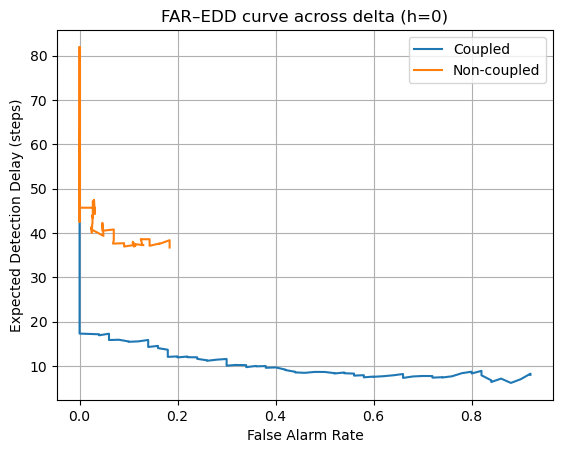

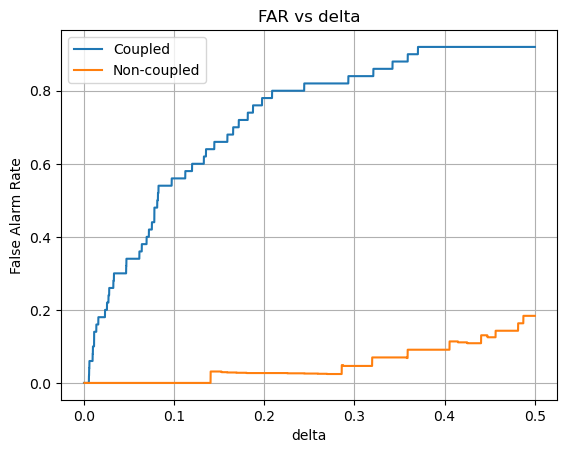

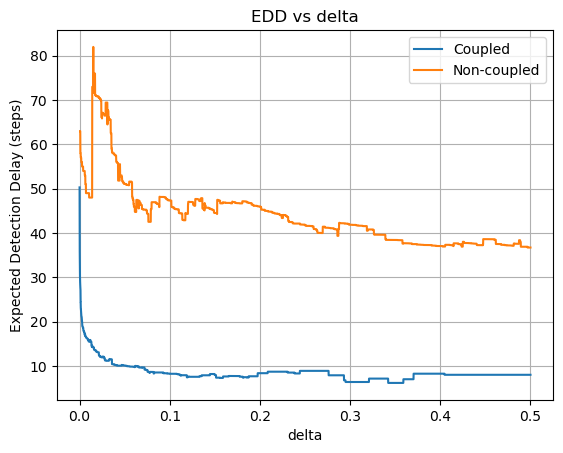

Delta sweep CSV: delta_sweep_coupled_vs_noncoupled.csv


In [12]:
# Delta-sweep simulation: FAR–EDD curves for coupled vs non-coupled
# Deltas from 0.0001 to 0.01 in 0.0001 steps, R=50 runs
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# --- Fixed experiment design ---
J = 10
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 9
pi = 1/100
rho = 0.9
alpha = 1.0
beta = 1.0
h = 0.0
R = 50

deltas = np.arange(1, 50001) * 1e-5  # 0.0001 ... 0.0100

# --- Helpers ---
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1.
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)
    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)
    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = (s-1) - 1 + 1  # = s-1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_for_run(Y, alpha, beta, pi, rho):
    """
    For a given panel Y (J x T), precompute:
    - A_vals[t, j] = Amax for series j at time t
    - logLambda[t, j] = coupling log-factor for series j at time t
    Returns (A_vals, logLambda) with shape (T+1, J) each.
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    # Compute logLambda_{-j}(t) for all t, j
    logLambda = np.zeros((Tlen + 1, J), dtype=float)
    log1mr = np.log(1 - rho)
    logr = np.log(rho)
    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    # For t where t<2, leave zeros (no effect since A is -inf)
    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        term_k = np.logaddexp(log1mr, logr + logBF)  # size J
        sum_terms = np.sum(term_k)
        # for each j: remove its term and mix over G
        logLambda[t, :] = np.logaddexp(log1mp, logp + (sum_terms - term_k))
    return A_vals, logLambda

def first_alarm_from_precomp(A_vals, logLambda, delta, h):
    """
    Given precomputed A_vals[t,j] and logLambda[t,j], compute first alarm time
    for both coupled and non-coupled at threshold h, for this delta.
    Returns (t_alarm_coupled, t_alarm_noncoupled) or (np.nan, np.nan) if none.
    """
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    t = np.arange(Tlen + 1)
    # log eta base as a function of n=t
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # ensure no alarm at t=0,1

    # Coupled scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    # Find first t s.t. any j crosses h
    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        if idx.size == 0:
            return np.nan
        return float(idx[0])
    return first_alarm(S_c), first_alarm(S_n)

# --- Precompute once per run, then sweep deltas fast ---
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logLambda = precompute_for_run(Y, alpha, beta, pi, rho)
    precomp_list.append((A_vals, logLambda))

# For each delta, compute FAR/EDD for both detectors
rows = []
for delta in deltas:
    alarms_c = []
    alarms_n = []
    for (A_vals, logLambda) in precomp_list:
        t_c, t_n = first_alarm_from_precomp(A_vals, logLambda, delta, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)
    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# Display a wide table and also pivoted FAR–EDD curves

# FAR–EDD curve
plt.figure()
mask_c = results["detector"]=="coupled"
mask_n = results["detector"]=="noncoupled"
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "FAR"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("FAR–EDD curve across delta (h=0)")
plt.legend()
plt.grid(True)
plt.show()

# Also show FAR vs delta and EDD vs delta
plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "FAR"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "FAR"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("False Alarm Rate")
plt.title("FAR vs delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("EDD vs delta")
plt.legend()
plt.grid(True)
plt.show()

# Save for download
results_path = "delta_sweep_coupled_vs_noncoupled.csv"
results.to_csv(results_path, index=False)
print(f"Delta sweep CSV: {results_path}")


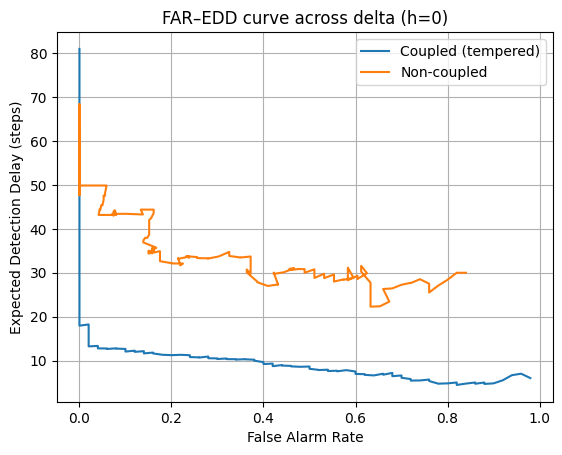

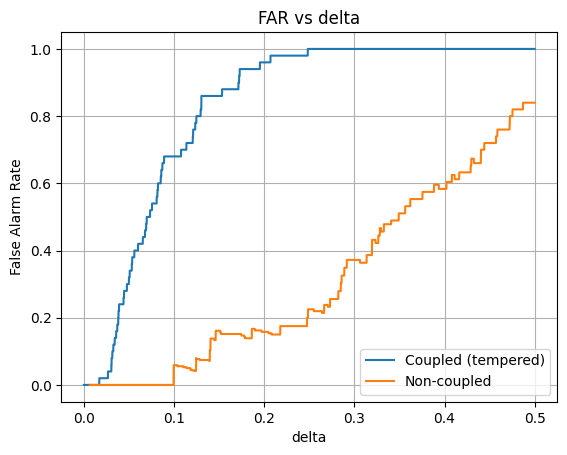

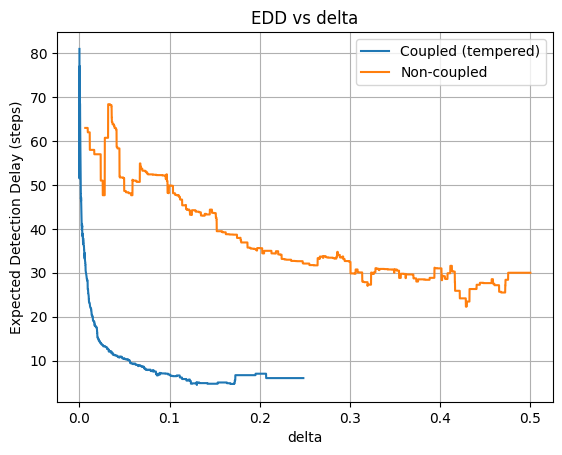

Delta sweep CSV: delta_sweep_coupled_tempered_vs_noncoupled.csv


In [7]:
# Delta-sweep simulation: FAR–EDD curves for tempered-coupled vs non-coupled
# Deltas from 0.0001 to 0.01 in 0.0001 steps, R=50 runs
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# --- Fixed experiment design ---
J = 100
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.3
num_changed = 100
pi = 1/1000
rho = 0.999
alpha = 1.0
beta = 1.0
h = 0.0
R = 50

# NEW: learning rate for tempered geometric-mean coupling (J-invariant)
tau = 10.0   # <1 dampens coupling; >1 sharpens; tau=1 is a good default

deltas = np.arange(1, 50001) * 1e-5  # 0.0001 ... 0.0100

# --- Helpers ---
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1.
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)
    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)
    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = (s-1) - 1 + 1  # = s-1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_for_run(Y, alpha, beta, pi, rho, *, tau=10.0, mode="geom"):
    """
    For a given panel Y (J x T), precompute:
    - A_vals[t, j] = Amax for series j at time t
    - logLambda[t, j] = coupling log-factor for series j at time t

    mode="geom": tempered geometric-mean coupling (J-invariant).
    mode="prod": original product coupling (kept for optional comparison).
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    logLambda = np.zeros((Tlen + 1, J), dtype=float)
    log1mp, logp = np.log(1 - pi), np.log(pi)

    for t in range(2, Tlen + 1):
        # Per-series log Bayes factor (truncated below at 0)
        logBF = np.maximum(A_vals[t, :], 0.0)  # shape (J,)

        # Stable log X_k = log((1-ρ) + ρ * BF_k)
        # Using: log(a + b*exp(logBF)) = logaddexp(log(a), log(b) + logBF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)  # shape (J,)

        if mode == "geom":
            # Tempered geometric-mean over k≠j:
            # log GM_excl_j = (sum_k logX_k - logX_j) / (J-1)
            sum_logX   = np.sum(logX)                  # scalar
            logGM_excl = (sum_logX - logX) / (J - 1)   # leave-one-out average
            log_tempered = tau * logGM_excl            # (GM_excl)^tau

            # Mixture with prior π: log((1-π) + π * e^{log_tempered})
            logLambda[t, :] = np.logaddexp(log1mp, logp + log_tempered)

        elif mode == "prod":
            # Original product coupling (explodes with J) — optional for A/B tests
            sum_terms = np.sum(logX)
            logLambda[t, :] = np.logaddexp(log1mp, logp + (sum_terms - logX))
        else:
            raise ValueError("mode must be 'geom' or 'prod'")

    return A_vals, logLambda

def first_alarm_from_precomp(A_vals, logLambda, delta, h):
    """
    Given precomputed A_vals[t,j] and logLambda[t,j], compute first alarm time
    for both coupled and non-coupled at threshold h, for this delta.
    Returns (t_alarm_coupled, t_alarm_noncoupled) or (np.nan, np.nan) if none.
    """
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    t = np.arange(Tlen + 1)
    # log eta base as a function of n=t
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # ensure no alarm at t=0,1

    # Coupled scores (tempered)
    S_c = A_vals + logLambda + logeta[:, None]
    # Non-coupled
    S_n = A_vals + logeta[:, None]

    # Find first t s.t. any j crosses h
    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        if idx.size == 0:
            return np.nan
        return float(idx[0])
    return first_alarm(S_c), first_alarm(S_n)

# --- Precompute once per run, then sweep deltas fast ---
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    # Use tempered geometric-mean coupling
    A_vals, logLambda = precompute_for_run(Y, alpha, beta, pi, rho, tau=tau, mode="geom")
    precomp_list.append((A_vals, logLambda))

# For each delta, compute FAR/EDD for both detectors
rows = []
for delta in deltas:
    alarms_c = []
    alarms_n = []
    for (A_vals, logLambda) in precomp_list:
        t_c, t_n = first_alarm_from_precomp(A_vals, logLambda, delta, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)
    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# Display a wide table and also pivoted FAR–EDD curves

# FAR–EDD curve
plt.figure()
mask_c = results["detector"]=="coupled_tempered"
mask_n = results["detector"]=="noncoupled"
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], label="Coupled (tempered)")
plt.plot(results.loc[mask_n, "FAR"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("FAR–EDD curve across delta (h=0)")
plt.legend()
plt.grid(True)
plt.show()

# Also show FAR vs delta and EDD vs delta
plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "FAR"], label="Coupled (tempered)")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "FAR"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("False Alarm Rate")
plt.title("FAR vs delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "EDD"], label="Coupled (tempered)")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("EDD vs delta")
plt.legend()
plt.grid(True)
plt.show()

# Save for download
results_path = "delta_sweep_coupled_tempered_vs_noncoupled.csv"
results.to_csv(results_path, index=False)
print(f"Delta sweep CSV: {results_path}")

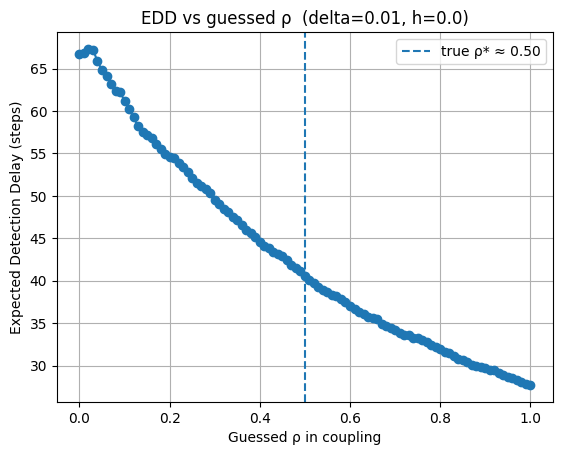

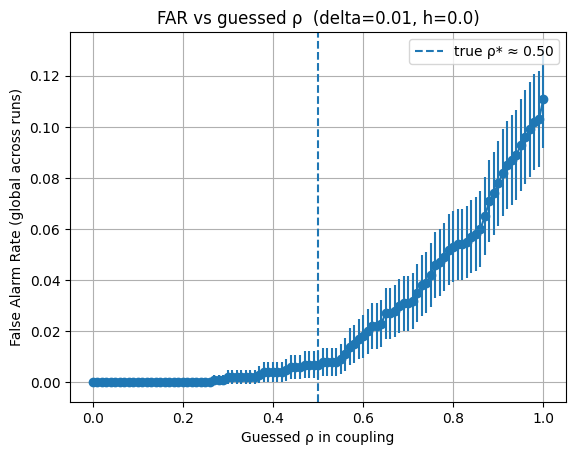

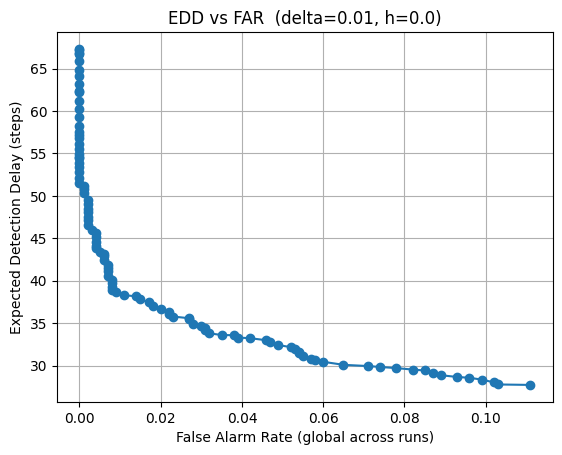

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [11]:
# Full rerun with ρ on a 0.01 grid (0.00, 0.01, ..., 1.00)
# Setup:
#   - 5 of 10 series change at t0 => ρ* ≈ 0.5
#   - delta = 0.01 (as in the last run)
# Outputs:
#   (1) EDD vs ρ
#   (2) FAR vs ρ (global, with 95% binomial CIs)
#   (3) EDD vs FAR (global) scatter
#   (4) Table + CSV
#
# Charts use matplotlib only, one chart per figure, and do not specify colors.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import lgamma
from typing import Tuple

rng = np.random.default_rng(31415)

# ------------------------- Experiment design -------------------------
J = 10
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 5
pi = 1/100
alpha = 1.0
beta = 1.0
h = 0.0
R = 1000

delta = 1e-2            # keep 0.01
rho_star = num_changed / J

# ρ grid in 0.01 steps, inclusive of 0 and 1.00
rho_grid = np.round(np.linspace(0.0, 1.0, 101), 2)

# ------------------------- Helpers -------------------------
vlgamma = np.vectorize(lgamma)

def log_beta_vec(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return vlgamma(a) + vlgamma(b) - vlgamma(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng) -> np.ndarray:
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = (s-1)
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_A_vals(Y: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)
    return A_vals

def compute_logLambda_given_rho(A_vals: np.ndarray, pi: float, rho: float) -> np.ndarray:
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    logLambda = np.zeros((Tlen + 1, J), dtype=float)
    log1mr = -np.inf if rho == 1.0 else np.log(1 - rho)
    logr = -np.inf if rho == 0.0 else np.log(rho)
    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        term_k = np.logaddexp(log1mr, logr + logBF)
        sum_terms = np.sum(term_k)
        logLambda[t, :] = np.logaddexp(log1mp, logp + (sum_terms - term_k))
    return logLambda

def first_alarm(A_vals: np.ndarray, logLambda: np.ndarray, delta: float, h: float, t0: int) -> float:
    Tlen = A_vals.shape[0]-1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf
    S = A_vals + logLambda + logeta[:, None]
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    if idx.size == 0:
        return np.nan
    return float(idx[0])

def summarize_alarm_times(alarm_times: np.ndarray, t0: int):
    finite = np.isfinite(alarm_times)
    at = alarm_times[finite]
    far_cond = float(np.mean(at < t0)) if at.size > 0 else np.nan
    far_global = float(np.mean(np.where(np.isfinite(alarm_times), alarm_times < t0, False)))
    dd = at[at >= t0] - t0
    edd = float(np.mean(dd)) if dd.size > 0 else np.nan
    edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    return far_cond, far_global, edd, edd_med, int(at.size), int(dd.size)

# ------------------------- Run experiment -------------------------
Avals_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals = precompute_A_vals(Y, alpha, beta)
    Avals_list.append(A_vals)

rows = []
for rho_guess in rho_grid:
    alarm_times = []
    for A_vals in Avals_list:
        logLambda = compute_logLambda_given_rho(A_vals, pi, rho_guess)
        t_alarm = first_alarm(A_vals, logLambda, delta, h, t0)
        alarm_times.append(t_alarm)
    alarm_times = np.array(alarm_times)
    far_cond, far_global, edd, edd_med, n_runs, n_post = summarize_alarm_times(alarm_times, t0)
    rows.append({
        "rho_guess": rho_guess,
        "FAR_conditional": far_cond,
        "FAR_global": far_global,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs_with_alarm": n_runs,
        "n_post": n_post,
    })

results_rho = pd.DataFrame(rows)

# ------------------------- Plots -------------------------
# (1) EDD vs ρ
plt.figure()
plt.plot(results_rho["rho_guess"], results_rho["EDD"], marker="o")
plt.axvline(rho_star, linestyle="--", label=f"true ρ* ≈ {rho_star:.2f}")
plt.xlabel("Guessed ρ in coupling")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs guessed ρ  (delta={delta:g}, h={h})")
plt.legend()
plt.grid(True)
plt.show()

# (2) FAR_global vs ρ with 95% binomial CIs
p = results_rho["FAR_global"].values
n = R
se = np.sqrt(p * (1 - p) / n)
yerr = 1.96 * se

plt.figure()
plt.errorbar(results_rho["rho_guess"], p, yerr=yerr, marker="o")
plt.axvline(rho_star, linestyle="--", label=f"true ρ* ≈ {rho_star:.2f}")
plt.xlabel("Guessed ρ in coupling")
plt.ylabel("False Alarm Rate (global across runs)")
plt.title(f"FAR vs guessed ρ  (delta={delta:g}, h={h})")
plt.legend()
plt.grid(True)
plt.show()

# (3) EDD vs FAR (global) scatter
mask = np.isfinite(results_rho["EDD"].values) & np.isfinite(results_rho["FAR_global"].values)
x = results_rho.loc[mask, "FAR_global"].values
y = results_rho.loc[mask, "EDD"].values

plt.figure()
plt.plot(x, y, marker="o")
plt.xlabel("False Alarm Rate (global across runs)")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs FAR  (delta={delta:g}, h={h})")
plt.grid(True)
plt.show()

# ------------------------- Save & display table -------------------------
out_path = "rho_misspec_sweep_nchg5_delta_1e-2_rho01grid.csv"
results_rho.to_csv(out_path, index=False)

from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("FAR–EDD vs rho (5 changed, δ=0.01, ρ step=0.01)", results_rho)

out_path

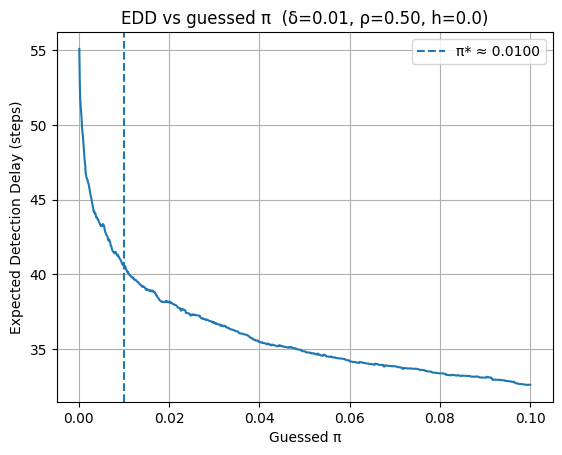

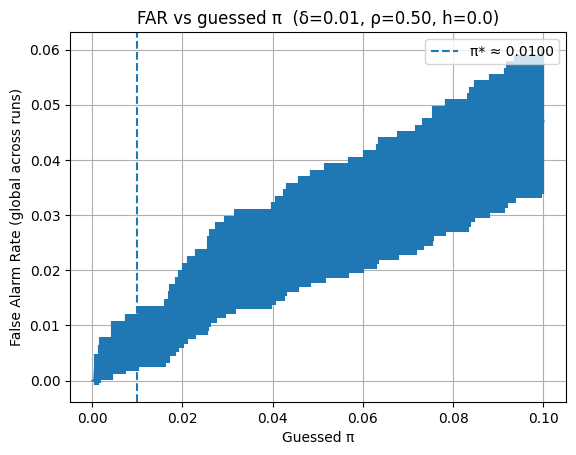

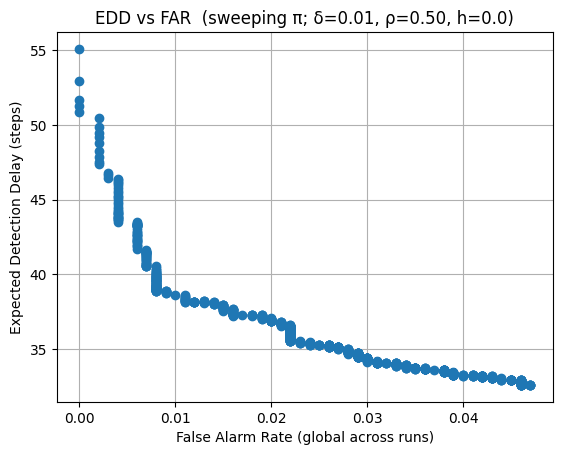

ModuleNotFoundError: No module named 'caas_jupyter_tools'

In [12]:
# Sweep misspecified π with correct ρ, on a fine grid (0.0001 ... 0.1000 by 0.0001)
# Setup:
#   - True data: 5 of 10 series change at t0 => conceptual ρ* ≈ 0.5
#   - Detector: uses the correct ρ = 0.5 but sweeps guessed π
#   - delta = 0.01 (as in the last runs)
# Outputs:
#   (1) EDD vs π
#   (2) FAR vs π (global, with 95% binomial CIs)
#   (3) EDD vs FAR (global) scatter
#   (4) Table + CSV
#
# Performance note:
#   We precompute S_precomp[t,j] = (sum_k term_k) - term_j, which depends on ρ and A_vals
#   but not on π. Then for each π we form logLambda = logaddexp(log(1-π), log(π)+S_precomp)
#   which makes sweeping 1,000 π values fast.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import lgamma
from typing import Tuple

rng = np.random.default_rng(31415)

# ------------------------- Experiment design -------------------------
J = 10
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 5
rho_true = num_changed / J     # correct ρ used by detector
alpha = 1.0
beta = 1.0
h = 0.0
R = 1000

delta = 1e-2                   # keep 0.01

# π grid: 0.0001 to 0.1000 by 0.0001 (1/10000 .. 1000/10000)
pi_grid = np.arange(1, 1001) * 1e-4
pi_star = 1/100                # centered truth we used before in code, for reference line

# ------------------------- Helpers -------------------------
vlgamma = np.vectorize(lgamma)

def log_beta_vec(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return vlgamma(a) + vlgamma(b) - vlgamma(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng) -> np.ndarray:
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = (s-1)
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_A_vals(Y: np.ndarray, alpha: float, beta: float) -> np.ndarray:
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)
    return A_vals

def precompute_S_given_rho(A_vals: np.ndarray, rho: float) -> np.ndarray:
    """
    Precompute S[t,j] = (sum_k term_k(t)) - term_j(t), where
      term_k(t) = log( (1-ρ) + ρ * BF_k(t) ) with BF_k(t) = exp(max(A_vals[t,k],0))
    Returns S with shape (T+1, J).
    """
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    S = np.zeros((Tlen + 1, J), dtype=float)
    log1mr = -np.inf if rho == 1.0 else np.log(1 - rho)
    logr = -np.inf if rho == 0.0 else np.log(rho)
    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        term_k = np.logaddexp(log1mr, logr + logBF)
        sum_terms = np.sum(term_k)
        S[t, :] = sum_terms - term_k
    return S

def first_alarm_from_core(A_core: np.ndarray, S_pre: np.ndarray, pi: float, h: float) -> float:
    """
    Given A_core = A_vals + logeta[:,None] and S_pre (precomputed for rho),
    compute first alarm time for a single π guess:
      logLambda = logaddexp(log(1-π), log(π) + S_pre)
      S_total = A_core + logLambda
    """
    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logLambda = np.logaddexp(log1mp, logp + S_pre)
    S_total = A_core + logLambda
    mask = S_total >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    if idx.size == 0:
        return np.nan
    return float(idx[0])

def summarize_alarm_times(alarm_times: np.ndarray, t0: int):
    finite = np.isfinite(alarm_times)
    at = alarm_times[finite]
    far_cond = float(np.mean(at < t0)) if at.size > 0 else np.nan
    far_global = float(np.mean(np.where(np.isfinite(alarm_times), alarm_times < t0, False)))
    dd = at[at >= t0] - t0
    edd = float(np.mean(dd)) if dd.size > 0 else np.nan
    edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    return far_cond, far_global, edd, edd_med, int(at.size), int(dd.size)

# ------------------------- Precompute per run -------------------------
# Precompute logeta once
Tlen = T
t = np.arange(Tlen + 1)
with np.errstate(divide='ignore', invalid='ignore'):
    logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
logeta[:2] = -np.inf

Acore_list = []
Spre_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals = precompute_A_vals(Y, alpha, beta)
    # A_core depends only on delta (logeta) and A_vals
    A_core = A_vals + logeta[:, None]
    # S_pre depends only on rho_true and A_vals
    S_pre = precompute_S_given_rho(A_vals, rho_true)
    Acore_list.append(A_core)
    Spre_list.append(S_pre)

# ------------------------- Sweep π guesses -------------------------
rows = []
for pi_guess in pi_grid:
    alarm_times = []
    for A_core, S_pre in zip(Acore_list, Spre_list):
        t_alarm = first_alarm_from_core(A_core, S_pre, pi_guess, h)
        alarm_times.append(t_alarm)
    alarm_times = np.array(alarm_times)
    far_cond, far_global, edd, edd_med, n_runs, n_post = summarize_alarm_times(alarm_times, t0)
    rows.append({
        "pi_guess": pi_guess,
        "FAR_conditional": far_cond,
        "FAR_global": far_global,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs_with_alarm": n_runs,
        "n_post": n_post,
    })

results_pi = pd.DataFrame(rows)

# ------------------------- Plots -------------------------
# (1) EDD vs π
plt.figure()
plt.plot(results_pi["pi_guess"], results_pi["EDD"])
plt.axvline(pi_star, linestyle="--", label=f"π* ≈ {pi_star:.4f}")
plt.xlabel("Guessed π")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs guessed π  (δ={delta:g}, ρ={rho_true:.2f}, h={h})")
plt.legend()
plt.grid(True)
plt.show()

# (2) FAR_global vs π with 95% binomial CIs
p = results_pi["FAR_global"].values
n = R
se = np.sqrt(p * (1 - p) / n)
yerr = 1.96 * se

plt.figure()
plt.errorbar(results_pi["pi_guess"], p, yerr=yerr)
plt.axvline(pi_star, linestyle="--", label=f"π* ≈ {pi_star:.4f}")
plt.xlabel("Guessed π")
plt.ylabel("False Alarm Rate (global across runs)")
plt.title(f"FAR vs guessed π  (δ={delta:g}, ρ={rho_true:.2f}, h={h})")
plt.legend()
plt.grid(True)
plt.show()

# (3) EDD vs FAR (global) scatter
mask = np.isfinite(results_pi["EDD"].values) & np.isfinite(results_pi["FAR_global"].values)
x = results_pi.loc[mask, "FAR_global"].values
y = results_pi.loc[mask, "EDD"].values

plt.figure()
plt.plot(x, y, marker="o", linestyle="None")
plt.xlabel("False Alarm Rate (global across runs)")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs FAR  (sweeping π; δ={delta:g}, ρ={rho_true:.2f}, h={h})")
plt.grid(True)
plt.show()

# ------------------------- Save & display table -------------------------
out_path = "pi_misspec_sweep_nchg5_delta_1e-2_pi0001to0100_step0001.csv"
results_pi.to_csv(out_path, index=False)

from caas_jupyter_tools import display_dataframe_to_user
display_dataframe_to_user("FAR–EDD vs pi (ρ fixed at 0.5, δ=0.01)", results_pi)

out_path

In [14]:
import numpy as np

def simulate_linear_data(n=200, p=5, sigma=0.7, seed=123):
    rng = np.random.default_rng(seed)
    X = rng.normal(size=(n, p))                 # design matrix
    beta_true = rng.normal(size=p)              # true coefficients
    eps = rng.normal(scale=sigma, size=n)       # noise ε ~ N(0, σ^2)
    y = X @ beta_true + eps
    return X, y, beta_true

def bayes_ridge_posterior_mean(X, y, lam=0.1):
    # m0 = 0; posterior mean equals classical ridge solution
    XtX = X.T @ X
    A = XtX + lam * np.eye(X.shape[1])
    return np.linalg.solve(A, X.T @ y)

# --- Demo ---
X, y, beta_true = simulate_linear_data(n=1000, p=5, sigma=0.7, seed=1)
lam = 0.0001
beta_hat = bayes_ridge_posterior_mean(X, y, lam)

print("True beta:     ", np.round(beta_true, 3))
print("Posterior mean:", np.round(beta_hat, 3))

True beta:      [ 0.599  0.666 -0.346  0.504 -0.464]
Posterior mean: [ 0.602  0.688 -0.353  0.474 -0.455]


In [1]:
import math
from math import lgamma, log, exp
import random
from typing import Iterable, Tuple, Optional, List

class PoissonGamma:
    """
    Conjugate model: y_i | λ ~ Poisson(λ),  λ ~ Gamma(α0, β0)  (shape–rate)
    Posterior after counts y_1:n:  λ | y ~ Gamma(α0 + sum y,  β0 + n)
    One-step predictive:  y_new ~ NegBin(r=α_post, p=β_post/(β_post+1))
        P(Y=k) = C(k+r-1, k) * (1-p)^r * p^k,  r=α_post, p=1/(β_post+1)
    """
    def __init__(self, alpha0: float, beta0: float):
        assert alpha0 > 0 and beta0 > 0
        self.alpha0 = alpha0
        self.beta0  = beta0
        self.alpha  = alpha0
        self.beta   = beta0
        self.n      = 0
        self.sumy   = 0.0

    # ----- updates -----
    def update_batch(self, y: Iterable[int]) -> None:
        y = list(y)
        self.sumy += sum(y)
        self.n    += len(y)
        self.alpha = self.alpha0 + self.sumy
        self.beta  = self.beta0  + self.n

    def update_one(self, y: int) -> None:
        self.sumy += y
        self.n    += 1
        self.alpha = self.alpha0 + self.sumy
        self.beta  = self.beta0  + self.n

    # ----- posterior summaries on λ -----
    @property
    def post_params(self) -> Tuple[float, float]:
        return self.alpha, self.beta  # shape–rate

    def post_mean(self) -> float:
        return self.alpha / self.beta

    def post_var(self) -> float:
        return self.alpha / (self.beta**2)

    def post_mode(self) -> Optional[float]:
        return (self.alpha - 1) / self.beta if self.alpha > 1 else None

    # ----- posterior predictive: Y_new -----
    # NegBin parameterization: r=alpha, p=1/(beta+1) is success prob for "k failures" form
    def pred_nb_params(self) -> Tuple[float, float]:
        r = self.alpha
        p = 1.0 / (self.beta + 1.0)     # probability used for k in NB pmf below
        return r, p

    def pred_mean(self) -> float:
        # E[Y_new] = alpha / beta
        return self.alpha / self.beta

    def pred_var(self) -> float:
        # Var[Y_new] = alpha * (beta + 1) / beta^2
        return self.alpha * (self.beta + 1.0) / (self.beta**2)

    def pred_pmf(self, k: int) -> float:
        r, p = self.pred_nb_params()
        # P(Y=k) = C(k+r-1, k) * (1-p)^r * p^k
        logpmf = (lgamma(k + r) - lgamma(r) - lgamma(k + 1)
                  + r * log(1 - p) + k * log(p))
        return exp(logpmf)

    def pred_logpmf(self, k: int) -> float:
        r, p = self.pred_nb_params()
        return (lgamma(k + r) - lgamma(r) - lgamma(k + 1)
                + r * log(1 - p) + k * log(p))

    def pred_sample(self, size: int = 1) -> List[int]:
        # Gamma–Poisson mixture: draw λ ~ Gamma(alpha, rate=beta), then y ~ Poisson(λ)
        out = []
        for _ in range(size):
            lam = random.gammavariate(self.alpha, 1.0 / self.beta)  # Python uses shape–scale
            # Poisson sampler via Knuth for small λ; for generality use numpy if available
            # Simple Poisson sampler (accepts λ up to moderate size); replace with numpy for speed
            L = math.exp(-lam)
            k = 0
            prod = 1.0
            while prod > L:
                k += 1
                prod *= random.random()
            out.append(k - 1)
        return out

# ---------- minimal usage example ----------
if __name__ == "__main__":
    # Prior Gamma(α0=2, β0=1) -> prior mean 2.0
    model = PoissonGamma(alpha0=2.0, beta0=1.0)

    # Observe counts
    data = [3, 0, 1, 4, 2, 1, 0, 2]
    model.update_batch(data)

    print("Posterior α,β:", model.post_params)
    print("Posterior mean λ:", model.post_mean())
    print("Posterior var λ:", model.post_var())
    print("Predictive mean E[Y_new]:", model.pred_mean())
    print("Predictive var Var[Y_new]:", model.pred_var())
    print("Predictive pmf P(Y=0..5):", [model.pred_pmf(k) for k in range(6)])
    print("Predictive samples:", model.pred_sample(size=5))

Posterior α,β: (15.0, 9.0)
Posterior mean λ: 1.6666666666666667
Posterior var λ: 0.18518518518518517
Predictive mean E[Y_new]: 1.6666666666666667
Predictive var Var[Y_new]: 1.8518518518518519
Predictive pmf P(Y=0..5): [0.20589113209464907, 0.30883669814197273, 0.2470693585135783, 0.14000596982436142, 0.06300268642096249, 0.023941020839965774]
Predictive samples: [1, 2, 4, 1, 0]


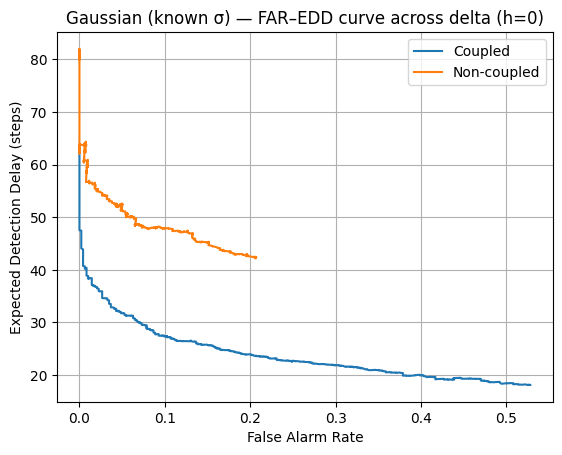

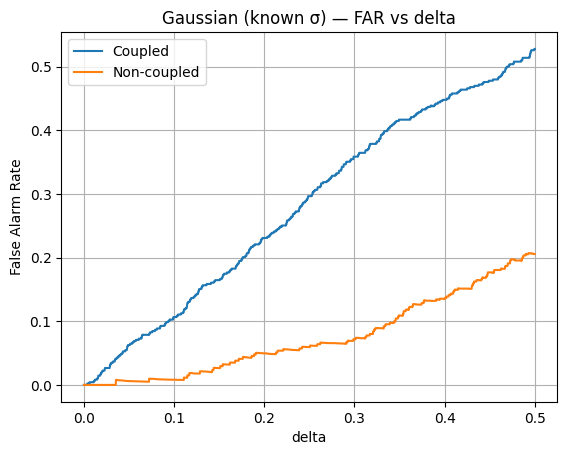

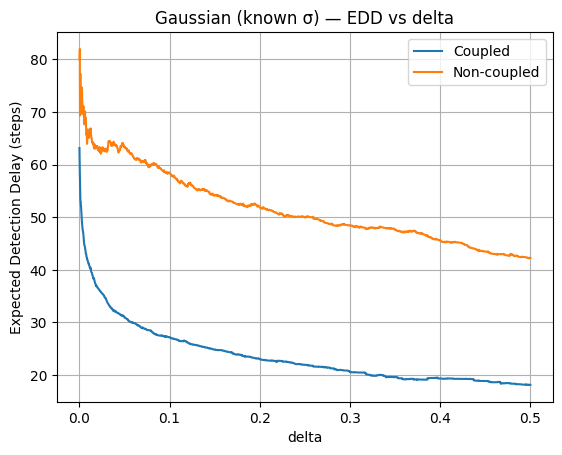

Delta sweep CSV saved to: delta_sweep_normal_knownvar.csv
Note: could not display interactive table (this is fine). Error: No module named 'ace_tools'


In [32]:
# Delta-sweep simulation (Gaussian): FAR–EDD curves for coupled vs non-coupled
# Normal observations with known variance and a mean shift at t0 for a subset of series.
#
# We mirror the structure of your Beta–Bernoulli code:
# - Same coupling & non-coupling logic
# - Same log-eta schedule and delta sweep (here: 0.0001 ... 0.01 in 0.0001 steps)
# - Replace the segment marginal likelihood with the Normal-with-known-variance, unknown-mean (Normal prior) evidence.
#
# Model for a segment y_{a..b} of length n:
#   y_i | mu ~ N(mu, sigma^2),  mu ~ N(m0, sigma^2/kappa0),  sigma^2 known
#   log p(y_{a..b}) = -(n/2)*log(2πσ^2) + 0.5*log(kappa0/(kappa0+n))
#                     - [ SSE + (kappa0*n/(kappa0+n))*(ybar - m0)**2 ] / (2σ^2)
# where SSE = sum (y_i - ybar)^2 and ybar is the segment mean.
#
# Amax[t] = max_{s=2..t} { -L(1,t) + L(1,s-1) + L(s,t) } (Bayes factor log for a 1-change vs no-change within 1..t)
#
# Coupling is identical to your original script.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(31415)

# --- Fixed experiment design ---
J = 10
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 5
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Deltas from 0.0001 to 0.01 in 0.0001 steps (100 values)
deltas = np.arange(1, 5001,2) * 1e-4

# --- Helpers ---
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y

def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    # Handle n>=1 only; caller ensures this.
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2

def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_for_run_normal(Y, m0, kappa0, sigma, pi, rho):
    """
    For a given panel Y (J x T), precompute:
    - A_vals[t, j] = Amax for series j at time t
    - logLambda[t, j] = coupling log-factor for series j at time t
    Returns (A_vals, logLambda) with shape (T+1, J) each.
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    # Compute logLambda_{-j}(t) for all t, j (same structure as original code)
    logLambda = np.zeros((Tlen + 1, J), dtype=float)
    log1mr = np.log(1 - rho)
    logr = np.log(rho)
    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        term_k = np.logaddexp(log1mr, logr + logBF)  # size J
        sum_terms = np.sum(term_k)
        # for each j: remove its term and mix over G
        logLambda[t, :] = np.logaddexp(log1mp, logp + (sum_terms - term_k))
    return A_vals, logLambda

def first_alarm_from_precomp(A_vals, logLambda, delta, h):
    """
    Given precomputed A_vals[t,j] and logLambda[t,j], compute first alarm time
    for both coupled and non-coupled at threshold h, for this delta.
    Returns (t_alarm_coupled, t_alarm_noncoupled) or (np.nan, np.nan) if none.
    """
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # ensure no alarm at t=0,1

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        if idx.size == 0:
            return np.nan
        return float(idx[0])
    return first_alarm(S_c), first_alarm(S_n)

# --- Precompute once per run, then sweep deltas fast ---
precomp_list = []
for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logLambda = precompute_for_run_normal(Y, m0, kappa0, sigma, pi, rho)
    precomp_list.append((A_vals, logLambda))

# For each delta, compute FAR/EDD for both detectors
rows = []
for delta in deltas:
    alarms_c = []
    alarms_n = []
    for (A_vals, logLambda) in precomp_list:
        t_c, t_n = first_alarm_from_precomp(A_vals, logLambda, delta, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)
    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# --- Plots ---
plt.figure()
mask_c = results["detector"]=="coupled"
mask_n = results["detector"]=="noncoupled"
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "FAR"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("Gaussian (known σ) — FAR–EDD curve across delta (h=0)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "FAR"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "FAR"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("False Alarm Rate")
plt.title("Gaussian (known σ) — FAR vs delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "EDD"], label="Coupled")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("Gaussian (known σ) — EDD vs delta")
plt.legend()
plt.grid(True)
plt.show()

# Save for download
results_path = "delta_sweep_normal_knownvar.csv"
results.to_csv(results_path, index=False)

print("Delta sweep CSV saved to:", results_path)
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Gaussian known-variance delta sweep (coupled vs non-coupled)", results)
except Exception as e:
    print("Note: could not display interactive table (this is fine). Error:", str(e))


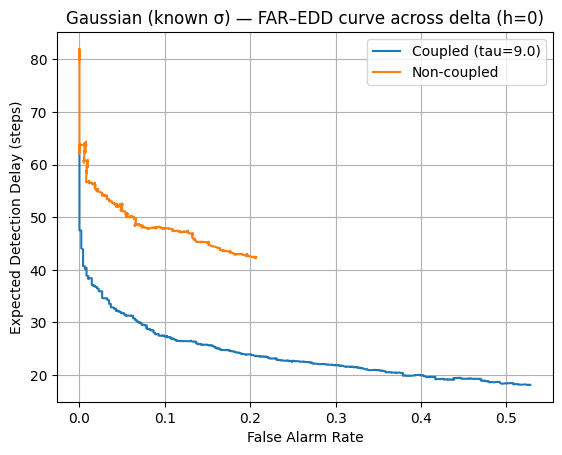

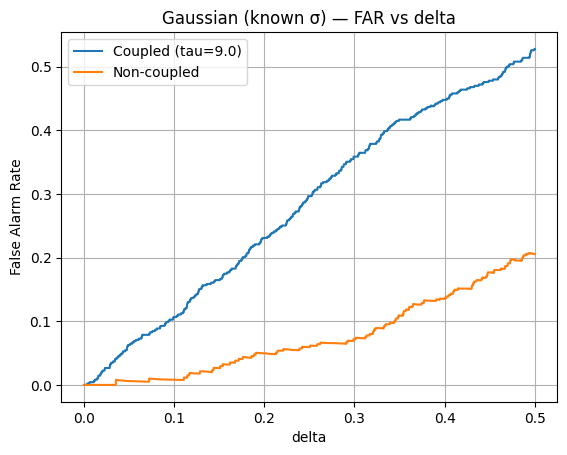

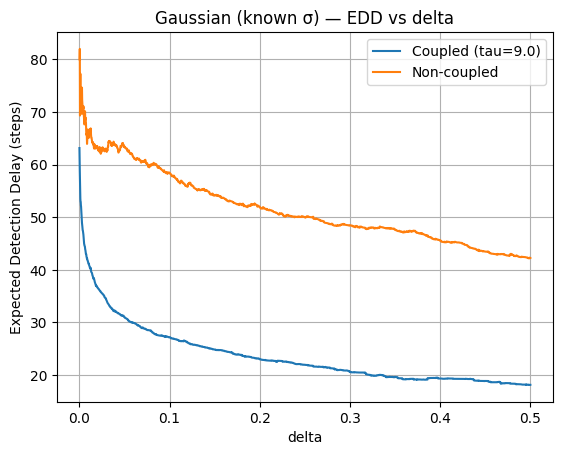

Delta sweep CSV saved to: delta_sweep_normal_knownvar_tau_tempered.csv


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(31415)

# --- Fixed experiment design ---
J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Deltas from 0.0001 to 0.01 in 0.0001 steps
deltas = np.arange(1, 5001, 2) * 1e-4

# NEW: tau tempering parameter (you can later make a grid and sweep over it)
tau = J - 1.0       # tau=J-1 gives the original "full product" coupling


# --- Helpers ---
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# NEW: precompute A_vals and logGM_excl (τ-tempering invariant), just like in Bernoulli case
def precompute_for_run_normal(Y, m0, kappa0, sigma, pi, rho):
    """
    For a given panel Y (J x T), precompute:
    - A_vals[t, j]      = Amax for series j at time t
    - logGM_excl[t, j]  = leave-one-out log-geo-mean logX_k(t), k≠j
    - logs              = (log1mp, logp) for group prior pi

    NOTE: τ *only* enters later, via logLambda = logaddexp(log1mp, logp + τ * logGM_excl).
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    # shrink per-series BF via rho: logX_k(t) = log[(1-ρ) + ρ * BF_k(t)]
    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    for t in range(2, Tlen + 1):
        logBF = np.maximum(A_vals[t, :], 0.0)
        logX = np.logaddexp(log1mr, logr + logBF)    # size J
        sum_logX = np.sum(logX)
        # leave-one-out log-geo-mean:
        # (1/(J-1)) * sum_{k≠j} log X_k(t)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs


def first_alarm_from_precomp(A_vals, logGM_excl, logs, delta, tau, h):
    """
    Given precomputed A_vals[t,j] and logGM_excl[t,j], compute first alarm time
    for both coupled and non-coupled at threshold h, for this delta and tau.

    Coupled:
        logLambda[t,j] = log{ (1-pi) + pi * exp( tau * logGM_excl[t,j] ) }
    Non-coupled:
        logLambda[t,j] = 0
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # ensure no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    def first_alarm(S):
        mask = S >= h
        any_t = np.any(mask, axis=1)
        idx = np.where(any_t)[0]
        if idx.size == 0:
            return np.nan
        return float(idx[0])

    return first_alarm(S_c), first_alarm(S_n)


# --- Precompute once per run, then sweep deltas fast ---
precomp_list = []
for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs = precompute_for_run_normal(Y, m0, kappa0, sigma, pi, rho)
    precomp_list.append((A_vals, logGM_excl, logs))

# For each delta, compute FAR/EDD for both detectors (for the fixed tau)
rows = []
for delta in deltas:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = first_alarm_from_precomp(A_vals, logGM_excl, logs, delta, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)
    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        far = float(np.mean(at < t0)) if at.size > 0 else np.nan
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        return {
            "detector": label,
            "delta": delta,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tau_tempered"))
    rows.append(summarize(alarms_n, "noncoupled"))

results = pd.DataFrame(rows)

# --- Plots ---
plt.figure()
mask_c = results["detector"] == "coupled_tau_tempered"
mask_n = results["detector"] == "noncoupled"
plt.plot(results.loc[mask_c, "FAR"], results.loc[mask_c, "EDD"], label=f"Coupled (tau={tau:.1f})")
plt.plot(results.loc[mask_n, "FAR"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("False Alarm Rate")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("Gaussian (known σ) — FAR–EDD curve across delta (h=0)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "FAR"], label=f"Coupled (tau={tau:.1f})")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "FAR"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("False Alarm Rate")
plt.title("Gaussian (known σ) — FAR vs delta")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "delta"], results.loc[mask_c, "EDD"], label=f"Coupled (tau={tau:.1f})")
plt.plot(results.loc[mask_n, "delta"], results.loc[mask_n, "EDD"], label="Non-coupled")
plt.xlabel("delta")
plt.ylabel("Expected Detection Delay (steps)")
plt.title("Gaussian (known σ) — EDD vs delta")
plt.legend()
plt.grid(True)
plt.show()

# Save for download
results_path = "delta_sweep_normal_knownvar_tau_tempered.csv"
results.to_csv(results_path, index=False)
print("Delta sweep CSV saved to:", results_path)

Data-optimal tau at FAR<=baseline: 14.848  (EDD=19.404)


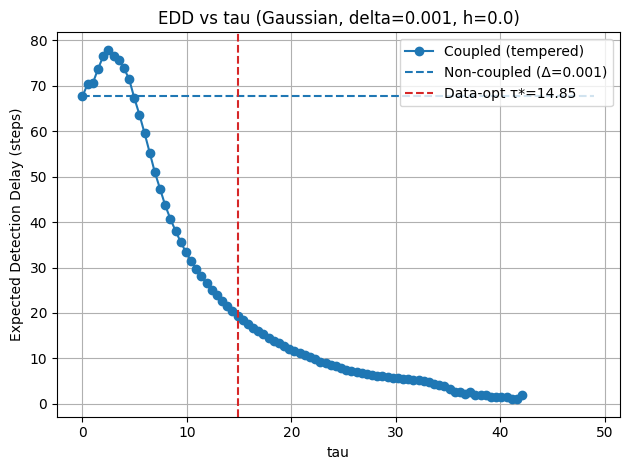

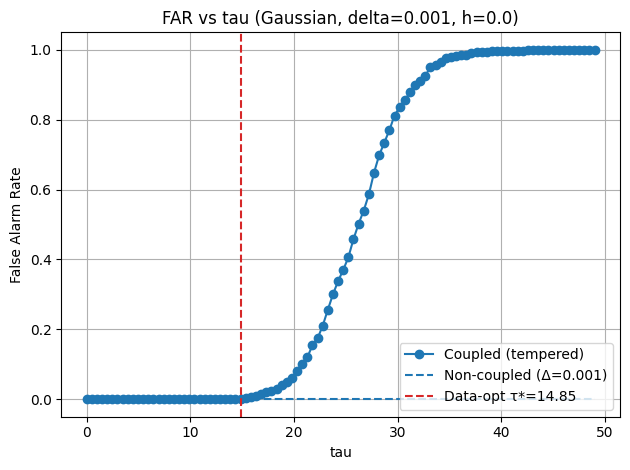

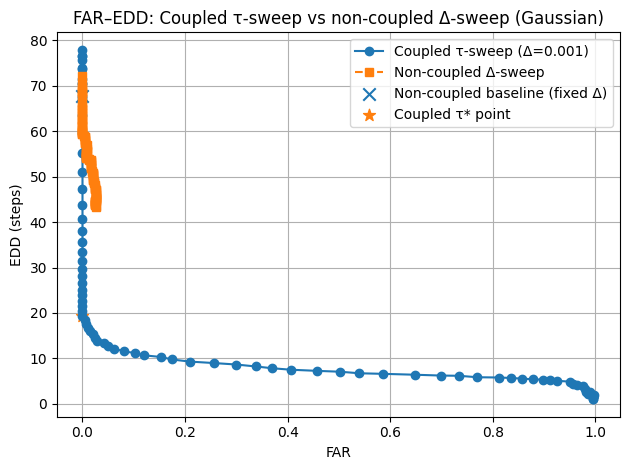

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.linspace(0.001, 0.1, 100)     # 1e-4 to 1

# ==========================================
# 1. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y

# ==========================================
# 2. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2

def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

# ==========================================
# 3. Precompute tau-invariants: A_vals, logGM_excl, logs
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:
      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi

    A_vals is (T+1, J), logGM_excl is (T+1, J).
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)
    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # leave-one-out log geo-mean

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs

# ==========================================
# 4. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)

# ==========================================
# 5. Monte Carlo: precompute invariants
# ==========================================
precomp_list = []
for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, clip_neg_bf=False
    )
    precomp_list.append((A_vals, logGM_excl, logs))

# ==========================================
# 6. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 7. Data-optimal tau* (like Bernoulli case)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ==========================================
# 8. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)

# ==========================================
# 9. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 10. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs):   16.025
Estimated tau (K_eff, median over runs): 18.711
Median pairwise rho_bar over runs:       0.0337
Data-optimal tau at FAR<=baseline: 14.848  (EDD=19.404)


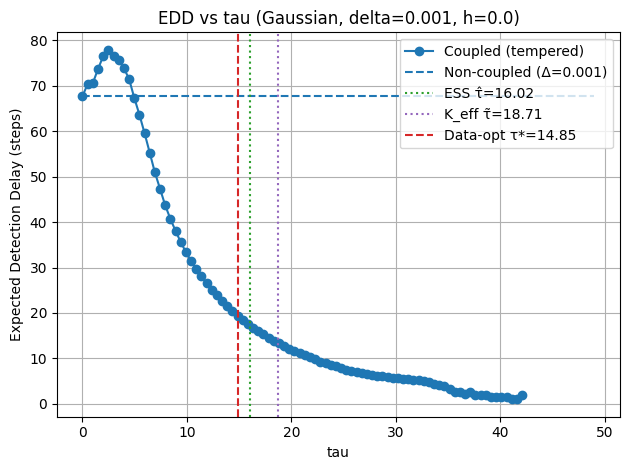

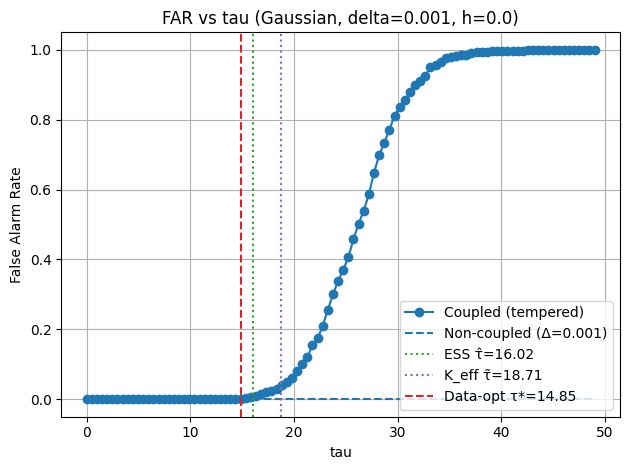

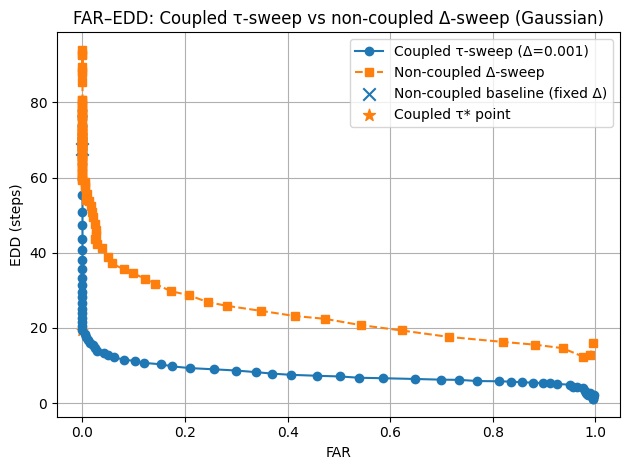

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.logspace(-4, 0, 100)     # 1e-4 to 1

CLIP_NEG_BF = False   # keep consistent with your Bernoulli setting


# ==========================================
# 1. Info-based tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


# ==========================================
# 3. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 4. Precompute tau-invariants: A_vals, logGM_excl, logs, u_pre
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:

      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi
      - u_pre[t,j]      : u_j(t)=log X_j(t) for t<=t0 (pre-change), used for tau estimation

    Shapes:
      Y: (J, T)
      A_vals: (T+1, J)
      logGM_excl: (T+1, J)
      u_pre: (Tpre, J)
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    # Amax field
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # store logX for all times so we can slice pre-change
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs, u_pre


# ==========================================
# 5. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)


# ==========================================
# 6. Monte Carlo: precompute invariants + info-based τ-hats
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=CLIP_NEG_BF
    )

    # info-based tau estimates
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)

    tau_hat_runs.append(tau_hat_r)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

# Aggregate info-based τ-hats
tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")


# ==========================================
# 7. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 8. Data-optimal tau* (EDD/FAR-based)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 9. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)


# ==========================================
# 10. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

# info-based tau lines
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")

# data-optimal tau*
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 11. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs):   16.025
Estimated tau (K_eff, median over runs): 18.711
Median pairwise rho_bar over runs:       0.0337
Data-optimal tau at FAR<=baseline: 14.848  (EDD=19.404)


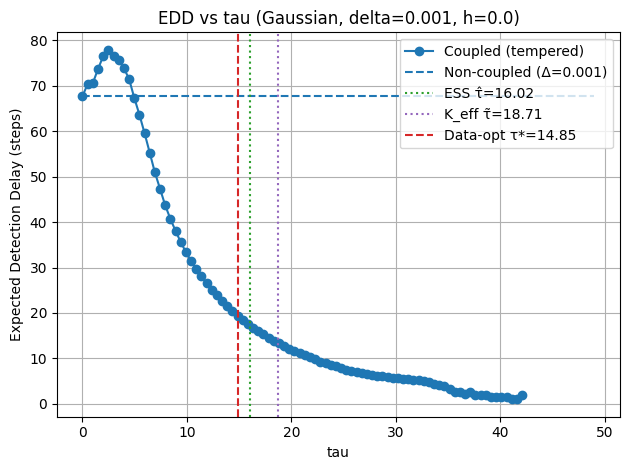

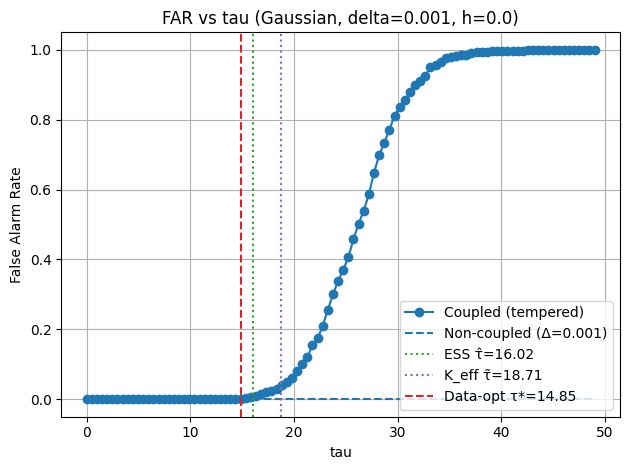

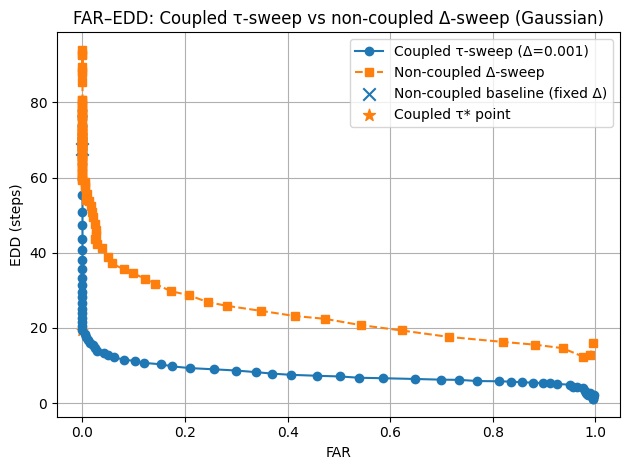

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.logspace(-4, 0, 100)     # 1e-4 to 1

CLIP_NEG_BF = False   # keep consistent with your Bernoulli setting


# ==========================================
# 1. Info-based tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


# ==========================================
# 3. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 4. Precompute tau-invariants: A_vals, logGM_excl, logs, u_pre
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:

      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi
      - u_pre[t,j]      : u_j(t)=log X_j(t) for t<=t0 (pre-change), used for tau estimation

    Shapes:
      Y: (J, T)
      A_vals: (T+1, J)
      logGM_excl: (T+1, J)
      u_pre: (Tpre, J)
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    # Amax field
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # store logX for all times so we can slice pre-change
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs, u_pre


# ==========================================
# 5. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)


# ==========================================
# 6. Monte Carlo: precompute invariants + info-based τ-hats
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=CLIP_NEG_BF
    )

    # info-based tau estimates
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)

    tau_hat_runs.append(tau_hat_r)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

# Aggregate info-based τ-hats
tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")


# ==========================================
# 7. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 8. Data-optimal tau* (EDD/FAR-based)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 9. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)


# ==========================================
# 10. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

# info-based tau lines
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")

# data-optimal tau*
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 11. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")


Estimated tau (ESS, median over runs):   16.025
Estimated tau (K_eff, median over runs): 18.711
Median pairwise rho_bar over runs:       0.0337
Data-optimal tau at FAR<=baseline: 14.848  (EDD=19.404)


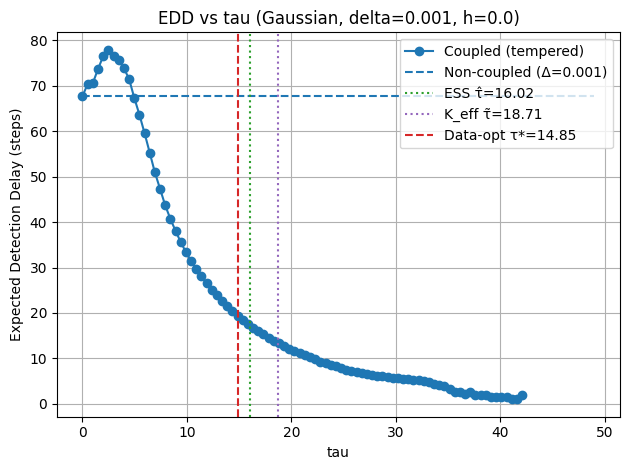

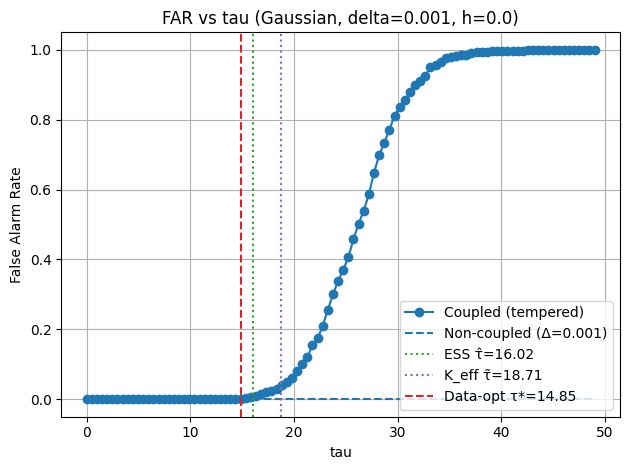

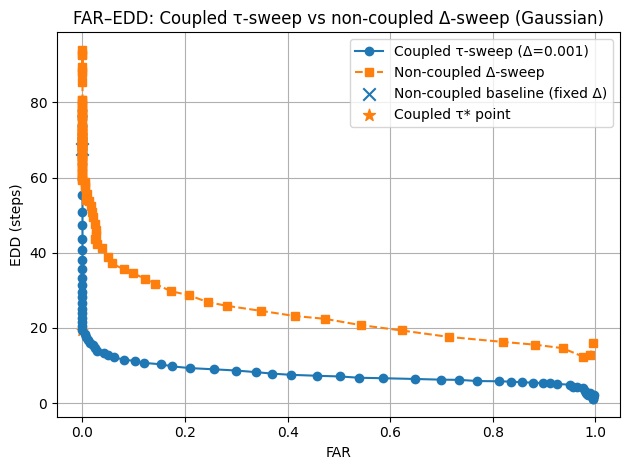

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.logspace(-4, 0, 100)     # 1e-4 to 1

CLIP_NEG_BF = False   # keep consistent with your Bernoulli setting


# ==========================================
# 1. Info-based tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


# ==========================================
# 3. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 4. Precompute tau-invariants: A_vals, logGM_excl, logs, u_pre
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:

      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi
      - u_pre[t,j]      : u_j(t)=log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    # Amax field
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # store logX for all times so we can slice pre-change
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs, u_pre


# ==========================================
# 5. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)


# ==========================================
# 6. Monte Carlo: precompute invariants + info-based τ-hats
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=CLIP_NEG_BF
    )

    # info-based tau estimates
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)

    tau_hat_runs.append(tau_hat_r)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

# Aggregate info-based τ-hats
tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")


# ==========================================
# 7. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 8. Data-optimal tau* (EDD/FAR-based)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 9. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)


# ==========================================
# 10. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

# info-based tau lines
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")

# data-optimal tau*
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 11. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs):   16.025
Estimated tau (K_eff, median over runs): 18.711
Median pairwise rho_bar over runs:       0.0337
Data-optimal tau at FAR<=baseline: 14.848  (EDD=19.404)


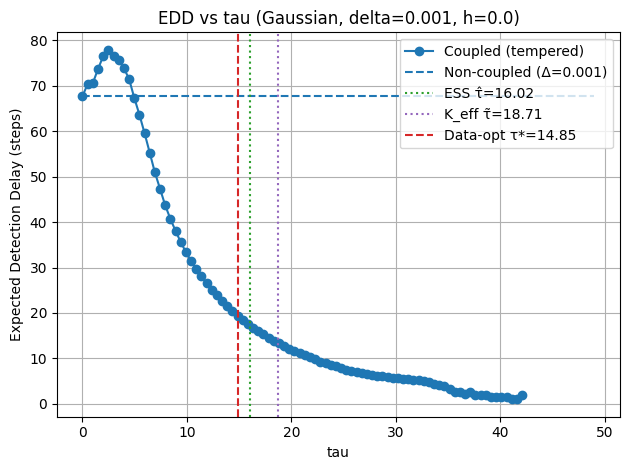

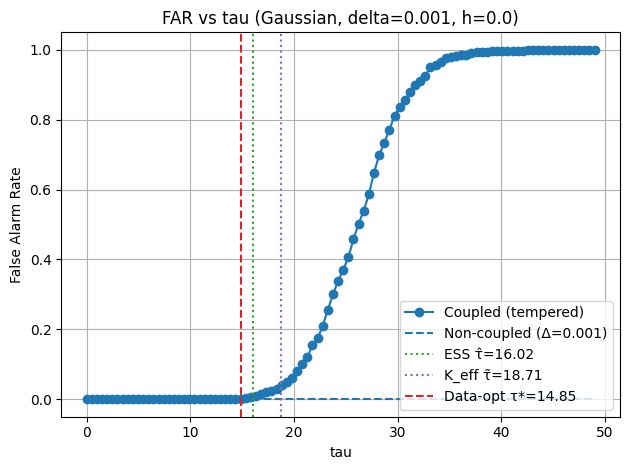

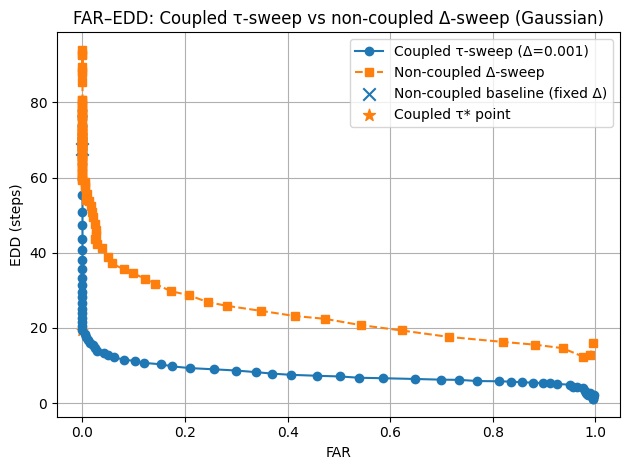

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv
Saved figures: gauss_EDD_vs_tau.png, gauss_FAR_vs_tau.png, gauss_FAR_EDD_tradeoff.png


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 50
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 25
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.logspace(-4, 0, 100)     # 1e-4 to 1

CLIP_NEG_BF = False   # keep consistent with your Bernoulli setting


# ==========================================
# 1. Info-based tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


# ==========================================
# 3. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 4. Precompute tau-invariants: A_vals, logGM_excl, logs, u_pre
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:

      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi
      - u_pre[t,j]      : u_j(t)=log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    # Amax field
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # store logX for all times so we can slice pre-change
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs, u_pre


# ==========================================
# 5. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)


# ==========================================
# 6. Monte Carlo: precompute invariants + info-based τ-hats
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=CLIP_NEG_BF
    )

    # info-based tau estimates
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)

    tau_hat_runs.append(tau_hat_r)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

# Aggregate info-based τ-hats
tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")


# ==========================================
# 7. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 8. Data-optimal tau* (EDD/FAR-based)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 9. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)


# ==========================================
# 10. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves (save PNGs)
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

# --- EDD vs tau ---
plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

# info-based tau lines
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")

# data-optimal tau*
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gauss_EDD_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# --- FAR vs tau ---
plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gauss_FAR_vs_tau.png", dpi=300, bbox_inches="tight")
plt.show()

# --- FAR–EDD parametric curves ---
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gauss_FAR_EDD_tradeoff.png", dpi=300, bbox_inches="tight")
plt.show()

# ==========================================
# 11. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")
print("Saved figures: gauss_EDD_vs_tau.png, gauss_FAR_vs_tau.png, gauss_FAR_EDD_tradeoff.png")

Estimated tau (ESS, median over runs):   17.735
Estimated tau (K_eff, median over runs): 21.811
Median pairwise rho_bar over runs:       0.0361
Data-optimal tau at FAR<=baseline: 16.000  (EDD=14.460)


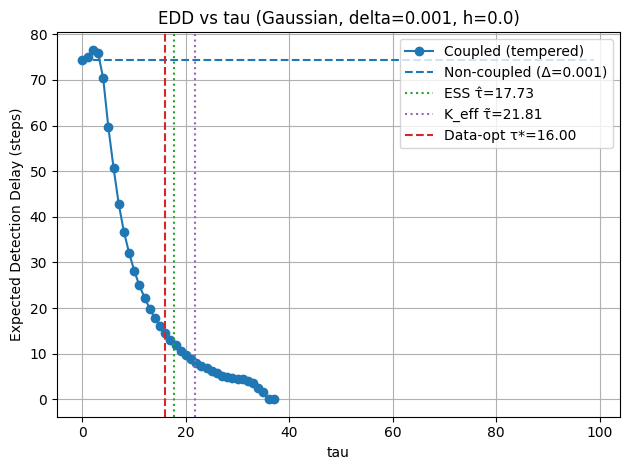

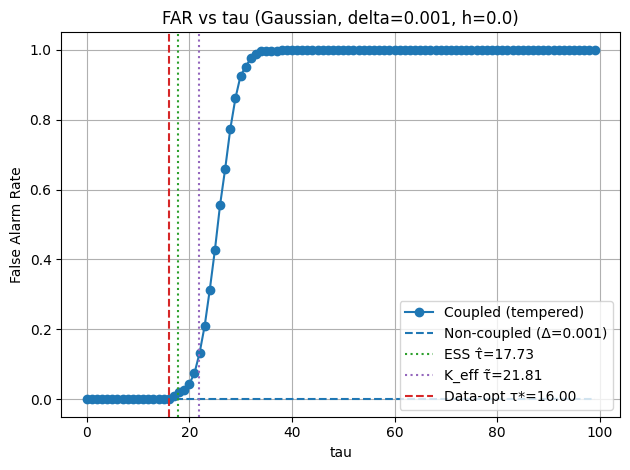

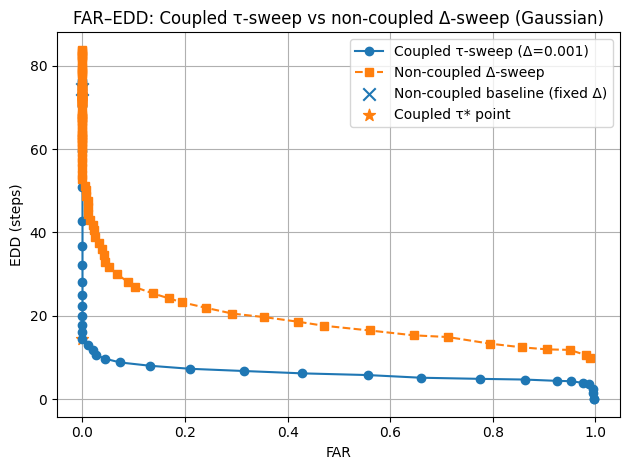

Tau sweep CSV:   tau_sweep_gaussian_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gaussian_noncoupled.csv


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

J = 100
T = 200
t0 = 100
mu0 = 0.0
mu1 = 0.5           # post-change mean for changed series
sigma = 1.0         # known std dev
num_changed = 50
pi = 1/100          # prior prob of global coupling
rho = 0.5           # per-series coupling weight
h = 0.0
R = 500             # Monte Carlo runs

# Weakly-informative Normal prior for means (conjugate, scaled by sigma^2)
m0 = mu0
kappa0 = 1.0        # ~ one "prior observation" worth of pull toward m0

# Tau-sweep settings (like Bernoulli)
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1]

# Fixed delta for tau-sweep
delta_fixed = 0.001

# Extra: delta grid for non-coupled sweep
delta_grid = np.logspace(-4, 0, 100)     # 1e-4 to 1

CLIP_NEG_BF = False   # keep consistent with your Bernoulli setting


# ==========================================
# 1. Info-based tau estimators (ESS & K_eff)
# ==========================================
def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_j u_j(t)).

    u_pre: array (Tpre, J) with u_j(t)=log X_j(t) at pre-change times.
    """
    if u_pre.size == 0:
        return 0.0

    # variance over time for each series
    var_j = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_j))

    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))

    if vbar <= 0 or var_w <= 0:
        return 0.0

    n_eff = vbar / var_w
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_keff_from_corr(u_pre):
    """
    K_eff-based tau: K_eff = (K-1) / (1 + (K-2)*rho_bar),
    where rho_bar is the mean pairwise correlation of u_j(t) across pre-change t.

    u_pre: array (Tpre, J) with u_j(t).
    Returns (tau_keff, rho_bar).
    """
    if u_pre.size == 0:
        return 0.0, np.nan

    T_pre, J_here = u_pre.shape

    # Corr across series, using time as sample index
    C = np.corrcoef(u_pre, rowvar=False)  # J_here x J_here

    off_diag = C[np.triu_indices(J_here, k=1)]
    mask = ~np.isnan(off_diag)
    if not np.any(mask):
        return 0.0, np.nan

    rho_bar = float(np.mean(off_diag[mask]))

    tau_keff = (J_here - 1.0) / (1.0 + (J_here - 2.0) * rho_bar)
    tau_keff = max(0.0, min(tau_keff, J_here - 1.0))
    return tau_keff, rho_bar


# ==========================================
# 2. Data generator
# ==========================================
def simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng):
    """
    Gaussian panel:
      - j < num_changed: N(mu0, sigma^2) pre-change, N(mu1, sigma^2) post-change
      - j >= num_changed: N(mu0, sigma^2) forever
    """
    Y = np.zeros((J, T), dtype=float)
    for j in range(J):
        if j < num_changed:
            pre = rng.normal(mu0, sigma, size=t0)
            post = rng.normal(mu1, sigma, size=T - t0)
            Y[j, :] = np.concatenate([pre, post])
        else:
            Y[j, :] = rng.normal(mu0, sigma, size=T)
    return Y


# ==========================================
# 3. Conjugate Normal evidence and Amax
# ==========================================
def log_evidence_normal(sum_x, sum_x2, n, sigma2, m0, kappa0):
    """
    Vectorized log marginal likelihood for a segment with known variance sigma^2,
    unknown mean with Normal prior: mu ~ N(m0, sigma^2/kappa0).
    Inputs are arrays of the same shape.
    """
    ybar = sum_x / n
    sse = sum_x2 - (sum_x**2) / n
    term_const = -(n/2.0) * np.log(2.0*np.pi*sigma2) + 0.5*(np.log(kappa0) - np.log(kappa0 + n))
    quad = sse + (kappa0 * n / (kappa0 + n)) * (ybar - m0)**2
    return term_const - 0.5 * quad / sigma2


def Amax_all_t_normal(prefix_sum, prefix_sumsq, sigma2, m0, kappa0):
    """
    Compute Amax[t] for t=1..T for a single series with run start r=1 (1-based indexing).
    Returns array shape (T+1,) 1-based index; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_sum.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    n_1t = np.arange(1, Tlen + 1, dtype=int)
    sum_1t = prefix_sum[1:] - prefix_sum[0]
    sumsq_1t = prefix_sumsq[1:] - prefix_sumsq[0]
    L_1t = log_evidence_normal(sum_1t, sumsq_1t, n_1t, sigma2, m0, kappa0)

    # For each t, vectorize across s
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Segment (1, s-1)
        n_1_sm1 = s - 1
        sum_1_sm1 = prefix_sum[s-1] - prefix_sum[0]
        sumsq_1_sm1 = prefix_sumsq[s-1] - prefix_sumsq[0]
        L_1_sm1 = log_evidence_normal(sum_1_sm1, sumsq_1_sm1, n_1_sm1, sigma2, m0, kappa0)

        # Segment (s, t)
        n_s_t = t - s + 1
        sum_s_t = prefix_sum[t] - prefix_sum[s-1]
        sumsq_s_t = prefix_sumsq[t] - prefix_sumsq[s-1]
        L_s_t = log_evidence_normal(sum_s_t, sumsq_s_t, n_s_t, sigma2, m0, kappa0)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 4. Precompute tau-invariants: A_vals, logGM_excl, logs, u_pre
# ==========================================
def precompute_tau_invariants_normal(Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=False):
    """
    For a given panel Y (J x T), compute:

      - A_vals[t,j]     : per-series Amax (Gaussian) log BF
      - logGM_excl[t,j] : leave-one-out log-geomean base over series
      - logs            : (log1mp, logp) for group prior pi
      - u_pre[t,j]      : u_j(t)=log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix_sum = np.zeros((J, Tlen + 1), dtype=float)
    prefix_sumsq = np.zeros((J, Tlen + 1), dtype=float)
    for j in range(J):
        prefix_sum[j, 1:] = np.cumsum(Y[j, :])
        prefix_sumsq[j, 1:] = np.cumsum(Y[j, :]**2)

    # Amax field
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    sigma2 = sigma**2
    for j in range(J):
        A_vals[:, j] = Amax_all_t_normal(prefix_sum[j], prefix_sumsq[j], sigma2, m0, kappa0)

    log1mr = np.log(1 - rho)
    logr = np.log(rho)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # store logX for all times so we can slice pre-change
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF)
        logX = np.logaddexp(log1mr, logr + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    t0_eff = min(t0, Tlen)
    u_pre = u_all[2:t0_eff+1, :].copy()

    log1mp = np.log(1 - pi)
    logp = np.log(pi)
    logs = (log1mp, logp)
    return A_vals, logGM_excl, logs, u_pre


# ==========================================
# 5. Hazard schedule and alarm functions
# ==========================================
def first_alarm_from_scores(S, h):
    """
    S: (T+1, J) score matrix.
    Return first time t where any series has S[t,j] >= h, as float (1-based index).
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau, h):
    """
    For fixed tau and delta, build logLambda and return
    (t_alarm_coupled, t_alarm_noncoupled).
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta*delta) - (np.log(t+1) + np.log(np.log(t+1)))
    logeta[:2] = -np.inf  # no alarm at t=0,1

    # τ-tempered coupling
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c, h), first_alarm_from_scores(S_n, h)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n, h)


# ==========================================
# 6. Monte Carlo: precompute invariants + info-based τ-hats
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_keff_runs = []
rho_bar_runs = []

for r in range(R):
    Y = simulate_panel_normal(T, t0, J, num_changed, mu0, mu1, sigma, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_normal(
        Y, m0, kappa0, sigma, pi, rho, t0, clip_neg_bf=CLIP_NEG_BF
    )

    # info-based tau estimates
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_keff_r, rho_bar_r = estimate_tau_keff_from_corr(u_pre)

    tau_hat_runs.append(tau_hat_r)
    tau_keff_runs.append(tau_keff_r)
    rho_bar_runs.append(rho_bar_r)

    precomp_list.append((A_vals, logGM_excl, logs))

# Aggregate info-based τ-hats
tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_KEFF = float(np.median(tau_keff_runs))
rho_bar_med = float(np.nanmedian(rho_bar_runs))

print(f"Estimated tau (ESS, median over runs):   {tau_hat_ESS:.3f}")
print(f"Estimated tau (K_eff, median over runs): {tau_hat_KEFF:.3f}")
print(f"Median pairwise rho_bar over runs:       {rho_bar_med:.4f}")


# ==========================================
# 7. Tau-sweep at fixed delta_fixed
# ==========================================
rows_tau = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau, h)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows_tau.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows_tau.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results_tau = pd.DataFrame(rows_tau)

# ==========================================
# 8. Data-optimal tau* (EDD/FAR-based)
# ==========================================
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")
far_baseline = results_tau.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results_tau[results_tau["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]

if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 9. Extra: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for FAR–EDD plot
results_all = pd.concat([results_tau, results_delta], ignore_index=True)


# ==========================================
# 10. Plots: EDD vs tau, FAR vs tau, FAR–EDD curves
# ==========================================
mask_c = (results_tau["detector"] == "coupled_tempered")
mask_n_fixed = (results_tau["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

# info-based tau lines
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")

# data-optimal tau*
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results_tau.loc[mask_c, "tau"], results_tau.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label=f"Non-coupled (Δ={delta_fixed})")

plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_KEFF, color="tab:purple", linestyle=":",
            label=f"K_eff τ̃={tau_hat_KEFF:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")

plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (Gaussian, delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results_tau.loc[mask_n_fixed, "FAR"].iloc[0],
            results_tau.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep (Gaussian)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 11. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gaussian_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gaussian_noncoupled.csv"
results_tau.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

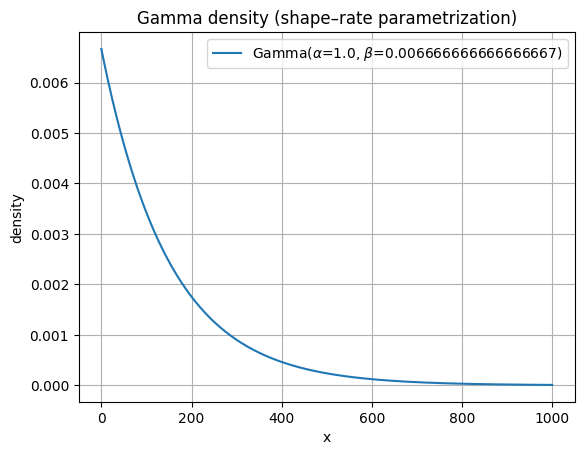

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# --- Parameters (shape–rate) ---
alpha = 1.0   # shape
beta = 1/150    # rate  (so scale = 1/beta)

# --- Grid for x values ---
x = np.linspace(0, 1000, 500)

# --- Gamma density with shape alpha and rate beta ---
pdf = gamma.pdf(x, a=alpha, scale=1/beta)

# --- Plot ---
plt.figure()
plt.plot(x, pdf, label=fr'Gamma($\alpha$={alpha}, $\beta$={beta})')
plt.xlabel('x')
plt.ylabel('density')
plt.title('Gamma density (shape–rate parametrization)')
plt.legend()
plt.grid(True)
plt.show()

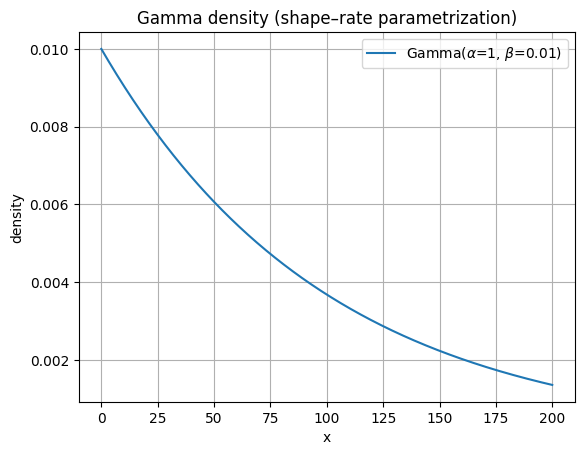

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# --- Parameters (shape–rate) ---
alpha = 1  # shape
beta = 1/100    # rate  (so scale = 1/beta)

# --- Grid for x values ---
x = np.linspace(0, 200, 500)

# --- Gamma density with shape alpha and rate beta ---
pdf = gamma.pdf(x, a=alpha, scale=1/beta)

# --- Plot ---
plt.figure()
plt.plot(x, pdf, label=fr'Gamma($\alpha$={alpha}, $\beta$={beta})')
plt.xlabel('x')
plt.ylabel('density')
plt.title('Gamma density (shape–rate parametrization)')
plt.legend()
plt.grid(True)
plt.show()

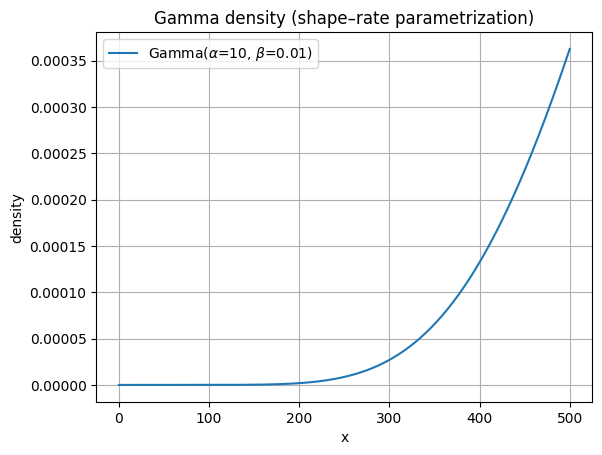

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# --- Parameters (shape–rate) ---
alpha =10  # shape
beta = 0.01  # rate  (so scale = 1/beta)

# --- Grid for x values ---
x = np.linspace(0, 500, 500)

# --- Gamma density with shape alpha and rate beta ---
pdf = gamma.pdf(x, a=alpha, scale=1/beta)

# --- Plot ---
plt.figure()
plt.plot(x, pdf, label=fr'Gamma($\alpha$={alpha}, $\beta$={beta})')
plt.xlabel('x')
plt.ylabel('density')
plt.title('Gamma density (shape–rate parametrization)')
plt.legend()
plt.grid(True)
plt.show()

Estimated tau (ESS, median over runs): 39.566
Data-optimal tau at FAR<=baseline: 10.889  (EDD=2.995)
Tau sweep CSV:   tau_sweep_gamma_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gamma_noncoupled.csv


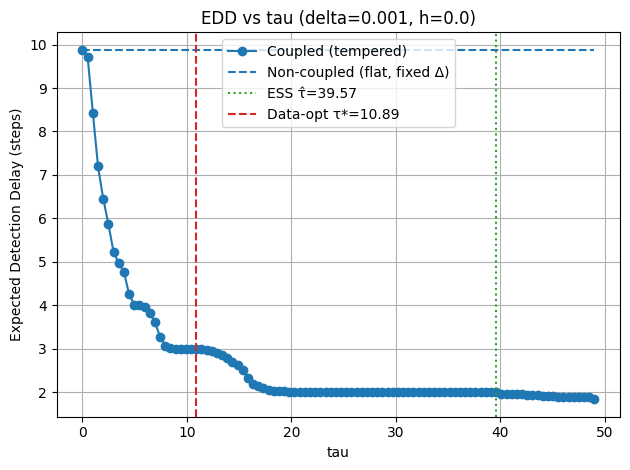

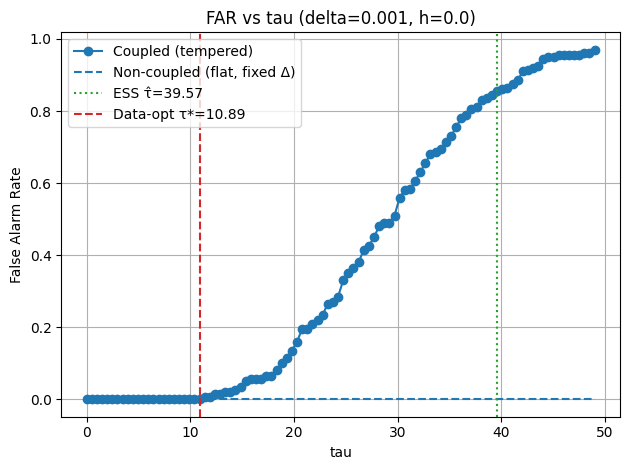

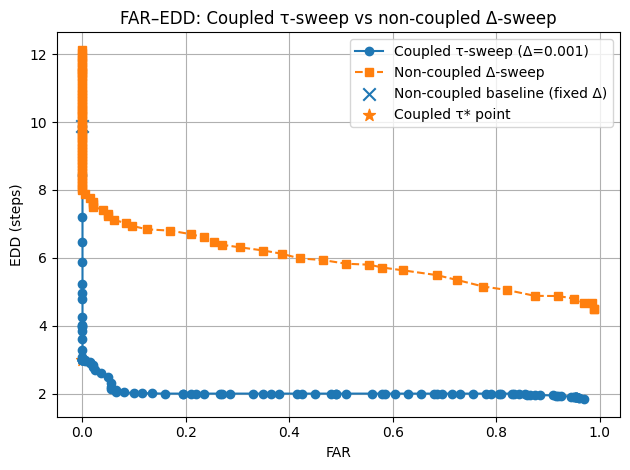

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

# Panel + changepoint setup
J = 50          # number of series
T = 200         # length of each series
t0 = 100        # true changepoint

# Pre-change: Exp(lambda0) = Gamma(k0=1, lambda0)
k0 = 1.0
lambda0 = 1/150.0

# Post-change: Gamma(k1=100, lambda1)
# (choose lambda1 to get desired mean/variance)
k1 = 100.0
lambda1 = 1.0

num_changed = 40          # < J for selective coupling

# Group-coupling hyperparameters
pi = 1/1000               # prior prob of global coupling
rho = 0.8                 # per-series coupling weight
h = 0.0                   # detection threshold on scores
R = 200                   # Monte Carlo runs (increase if you want)

# Priors for lambda0 and lambda1 (shape-rate)
a0, b0 = 1.0, 1.0
a1, b1 = 1.0, 1.0

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J - 1, N_TAU)  # [0, J-1]: no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False


# ==========================================
# 1. Gamma-Gamma marginal and A_max(t)
# ==========================================
def log_marg_segment_full(prefix_sum_y, prefix_sum_logy, r, t, k, a, b):
    """
    Full log-marginal for a Gamma(k, lambda) segment with lambda ~ Gamma(a, b)
    (shape-rate). We integrate out lambda and KEEP the k-dependent constants.

    prefix_sum_y[u]   = sum_{i=1}^u y_i
    prefix_sum_logy[u]= sum_{i=1}^u log y_i

    Segment is Y_r,...,Y_t, 1-based indices.
    """
    n = t - r + 1
    S = prefix_sum_y[t] - prefix_sum_y[r - 1]
    Slog = prefix_sum_logy[t] - prefix_sum_logy[r - 1]

    # Data-only part depending on k
    C = (k - 1.0) * Slog - n * gammaln(k)

    # Lambda-integrated part
    L = (
        gammaln(a + k * n)
        - gammaln(a)
        + a * np.log(b)
        - (a + k * n) * np.log(b + S)
    )
    return C + L


def Amax_all_t_gamma(y, k0, a0, b0, k1, a1, b1):
    """
    Gamma changepoint A_max(t) for t=1..T, with:
      - pre:  Gamma(k0, lambda0), lambda0 ~ Gamma(a0, b0)
      - post: Gamma(k1, lambda1), lambda1 ~ Gamma(a1, b1)

    Returns A array shape (T+1,), 1-based indexing; A[1] = -inf.
    """
    Tlen = len(y)
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Prefix sums for Y and log Y
    prefix_y = np.zeros(Tlen + 1)
    prefix_y[1:] = np.cumsum(y)

    prefix_logy = np.zeros(Tlen + 1)
    prefix_logy[1:] = np.cumsum(np.log(y))

    # H0: "no change" model (one segment [1,t] with Gamma(k0, lambda0))
    log_marg0_1t = np.full(Tlen + 1, 0.0)
    for t in range(1, Tlen + 1):
        log_marg0_1t[t] = log_marg_segment_full(prefix_y, prefix_logy, 1, t, k0, a0, b0)

    # For t < 2, no split possible
    A[1] = -np.inf

    # For each t, maximize over split s = 2..t
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Pre-change segment [1, s-1] under Gamma(k0, lambda0)
        n_pre = (s - 1) - 1 + 1       # = s-1
        S_pre = prefix_y[s - 1] - prefix_y[0]
        Slog_pre = prefix_logy[s - 1] - prefix_logy[0]
        C0_pre = (k0 - 1.0) * Slog_pre - n_pre * gammaln(k0)
        L0_pre = (
            gammaln(a0 + k0 * n_pre)
            - gammaln(a0)
            + a0 * np.log(b0)
            - (a0 + k0 * n_pre) * np.log(b0 + S_pre)
        )
        log_marg0_1_sm1 = C0_pre + L0_pre

        # Post-change segment [s, t] under Gamma(k1, lambda1)
        n_post = t - s + 1
        S_post = prefix_y[t] - prefix_y[s - 1]
        Slog_post = prefix_logy[t] - prefix_logy[s - 1]
        C1_post = (k1 - 1.0) * Slog_post - n_post * gammaln(k1)
        L1_post = (
            gammaln(a1 + k1 * n_post)
            - gammaln(a1)
            + a1 * np.log(b1)
            - (a1 + k1 * n_post) * np.log(b1 + S_post)
        )
        log_marg1_s_t = C1_post + L1_post

        # Log Bayes factor for split at s, comparing:
        #   H1: [1,s-1] with k0, [s,t] with k1
        #   vs H0: [1,t] with k0
        vals = -log_marg0_1t[t] + log_marg0_1_sm1 + log_marg1_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 2. Panel simulation: Gamma(1, lambda0) -> Gamma(100, lambda1)
# ==========================================
def simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng):
    """
    Simulate a J x T panel with a changepoint at t0 for the first num_changed series.

    For j < num_changed:
      - t < t0:  Y_{j,t} ~ Gamma(k0, lambda0)
      - t >= t0: Y_{j,t} ~ Gamma(k1, lambda1)
    For j >= num_changed:
      - all t:  Y_{j,t} ~ Gamma(k0, lambda0)
    """
    Y = np.zeros((J, T), dtype=float)
    n_pre = t0
    n_post = T - t0

    for j in range(J):
        if j < num_changed:
            # changed series
            Y[j, :t0] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=n_pre)
            Y[j, t0:] = rng.gamma(shape=k1, scale=1.0 / lambda1, size=n_post)
        else:
            # unchanged series
            Y[j, :] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=T)
    return Y


# ==========================================
# 3. Coupled invariants and tau estimation
# ==========================================
def precompute_tau_invariants_gamma(Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]     : per-series log-evidence (A_max)
      logGM_excl[t,j] : leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs            : (log1mp, logp) for mixing with prior pi
      u_pre[t,j]      : u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Per-series A_max(t)
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_gamma(Y[j, :], k0, a0, b0, k1, a1, b1)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably, BF=exp(logBF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0), times are 1-based in A_vals/u_all
    u_pre = u_all[2:t0 + 1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


# ==========================================
# 4. Alarm utilities (same structure as Bernoulli code)
# ==========================================
def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0] - 1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ==========================================
# 5. Simulate R runs; precompute invariants and tau-hat per run
# ==========================================
precomp_list = []
tau_hat_runs = []

for r in range(R):
    Y = simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_gamma(
        Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")


# ==========================================
# 6. Sweep tau (coupled) at fixed delta
# ==========================================
rows = []

for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)


# ==========================================
# 7. Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ==========================================
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 8. Extra experiment: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []

for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)


# ==========================================
# 9. Combine for plotting
# ==========================================
results_all = pd.concat([results, results_delta], ignore_index=True)

mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# EDD vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR–EDD parametric curves
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# ==========================================
# 10. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gamma_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gamma_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs):       9.000
Estimated tau (correlation, median over runs): 0.010
Data-optimal tau at FAR<=baseline: 9.000  (EDD=3.215)
Tau sweep CSV:   tau_sweep_gamma_WITH_tauhat_delta_0.001000.csv
Delta sweep CSV: delta_sweep_gamma_noncoupled.csv


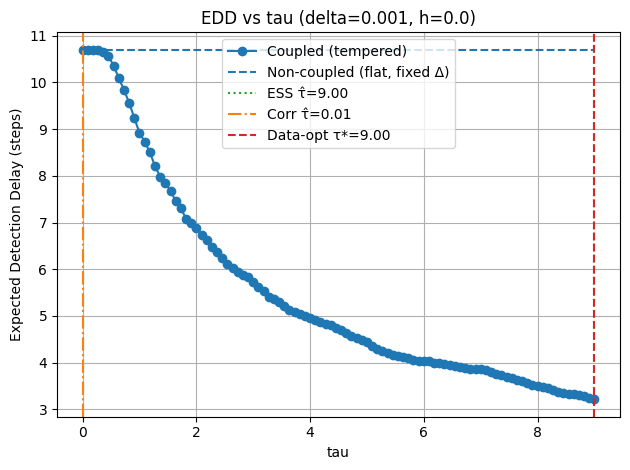

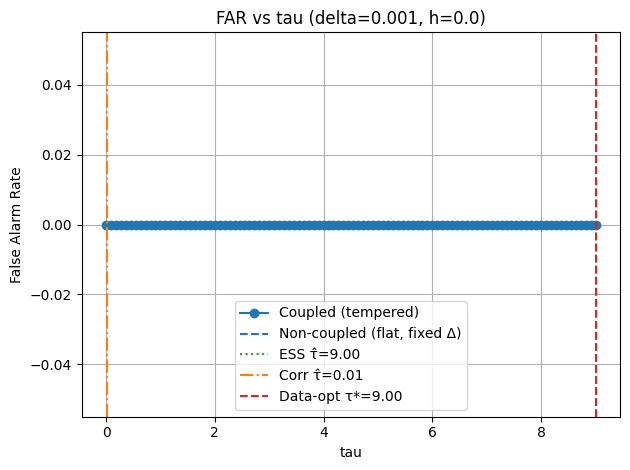

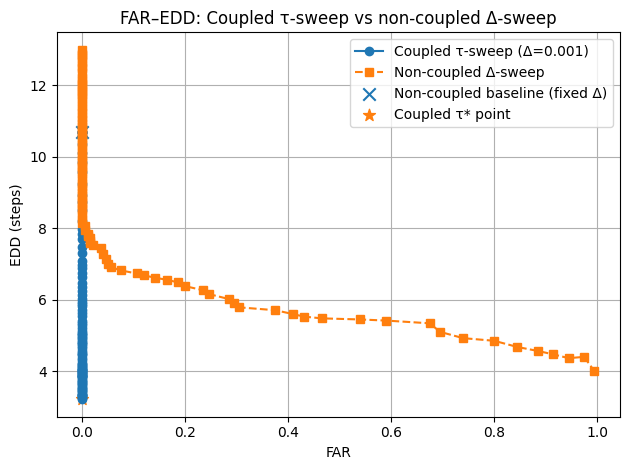

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

# Panel + changepoint setup
J = 10          # number of series
T = 200         # length of each series
t0 = 100        # true changepoint

# Pre-change: Exp(lambda0) = Gamma(k0=1, lambda0)
k0 = 1.0
lambda0 = 1 / 150.0

# Post-change: Gamma(k1=100, lambda1)
# (choose lambda1 to get desired mean/variance)
k1 = 100.0
lambda1 = 1.0

num_changed = 8         # < J for selective coupling

# Group-coupling hyperparameters
pi = 1 / 1000             # prior prob of global coupling
rho = 0.8                 # per-series coupling weight
h = 0.0                   # detection threshold on scores
R = 200                   # Monte Carlo runs (increase if you want)

# Priors for lambda0 and lambda1 (shape-rate)
a0, b0 = 1.0, 1.0
a1, b1 = 1.0, 1.0

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J - 1, N_TAU)  # [0, J-1]: no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False


# ==========================================
# 1. Gamma-Gamma marginal and A_max(t)
# ==========================================
def log_marg_segment_full(prefix_sum_y, prefix_sum_logy, r, t, k, a, b):
    """
    Full log-marginal for a Gamma(k, lambda) segment with lambda ~ Gamma(a, b)
    (shape-rate). We integrate out lambda and KEEP the k-dependent constants.

    prefix_sum_y[u]   = sum_{i=1}^u y_i
    prefix_sum_logy[u]= sum_{i=1}^u log y_i

    Segment is Y_r,...,Y_t, 1-based indices.
    """
    n = t - r + 1
    S = prefix_sum_y[t] - prefix_sum_y[r - 1]
    Slog = prefix_sum_logy[t] - prefix_sum_logy[r - 1]

    # Data-only part depending on k
    C = (k - 1.0) * Slog - n * gammaln(k)

    # Lambda-integrated part
    L = (
        gammaln(a + k * n)
        - gammaln(a)
        + a * np.log(b)
        - (a + k * n) * np.log(b + S)
    )
    return C + L


def Amax_all_t_gamma(y, k0, a0, b0, k1, a1, b1):
    """
    Gamma changepoint A_max(t) for t=1..T, with:
      - pre:  Gamma(k0, lambda0), lambda0 ~ Gamma(a0, b0)
      - post: Gamma(k1, lambda1), lambda1 ~ Gamma(a1, b1)

    Returns A array shape (T+1,), 1-based indexing; A[1] = -inf.
    """
    Tlen = len(y)
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Prefix sums for Y and log Y
    prefix_y = np.zeros(Tlen + 1)
    prefix_y[1:] = np.cumsum(y)

    prefix_logy = np.zeros(Tlen + 1)
    prefix_logy[1:] = np.cumsum(np.log(y))

    # H0: "no change" model (one segment [1,t] with Gamma(k0, lambda0))
    log_marg0_1t = np.full(Tlen + 1, 0.0)
    for t in range(1, Tlen + 1):
        log_marg0_1t[t] = log_marg_segment_full(prefix_y, prefix_logy, 1, t, k0, a0, b0)

    # For t < 2, no split possible
    A[1] = -np.inf

    # For each t, maximize over split s = 2..t
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Pre-change segment [1, s-1] under Gamma(k0, lambda0)
        n_pre = s - 1
        S_pre = prefix_y[s - 1] - prefix_y[0]
        Slog_pre = prefix_logy[s - 1] - prefix_logy[0]
        C0_pre = (k0 - 1.0) * Slog_pre - n_pre * gammaln(k0)
        L0_pre = (
            gammaln(a0 + k0 * n_pre)
            - gammaln(a0)
            + a0 * np.log(b0)
            - (a0 + k0 * n_pre) * np.log(b0 + S_pre)
        )
        log_marg0_1_sm1 = C0_pre + L0_pre

        # Post-change segment [s, t] under Gamma(k1, lambda1)
        n_post = t - s + 1
        S_post = prefix_y[t] - prefix_y[s - 1]
        Slog_post = prefix_logy[t] - prefix_logy[s - 1]
        C1_post = (k1 - 1.0) * Slog_post - n_post * gammaln(k1)
        L1_post = (
            gammaln(a1 + k1 * n_post)
            - gammaln(a1)
            + a1 * np.log(b1)
            - (a1 + k1 * n_post) * np.log(b1 + S_post)
        )
        log_marg1_s_t = C1_post + L1_post

        # Log Bayes factor for split at s, comparing:
        #   H1: [1,s-1] with k0, [s,t] with k1
        #   vs H0: [1,t] with k0
        vals = -log_marg0_1t[t] + log_marg0_1_sm1 + log_marg1_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 2. Panel simulation: Gamma(1, lambda0) -> Gamma(100, lambda1)
# ==========================================
def simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng):
    """
    Simulate a J x T panel with a changepoint at t0 for the first num_changed series.

    For j < num_changed:
      - t < t0:  Y_{j,t} ~ Gamma(k0, lambda0)
      - t >= t0: Y_{j,t} ~ Gamma(k1, lambda1)
    For j >= num_changed:
      - all t:  Y_{j,t} ~ Gamma(k0, lambda0)
    """
    Y = np.zeros((J, T), dtype=float)
    n_pre = t0
    n_post = T - t0

    for j in range(J):
        if j < num_changed:
            Y[j, :t0] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=n_pre)
            Y[j, t0:] = rng.gamma(shape=k1, scale=1.0 / lambda1, size=n_post)
        else:
            Y[j, :] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=T)
    return Y


# ==========================================
# 3. Coupled invariants and tau estimation
# ==========================================
def precompute_tau_invariants_gamma(Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]     : per-series log-evidence (A_max)
      logGM_excl[t,j] : leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs            : (log1mp, logp) for mixing with prior pi
      u_pre[t,j]      : u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Per-series A_max(t)
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_gamma(Y[j, :], k0, a0, b0, k1, a1, b1)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably, BF=exp(logBF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0), times are 1-based in A_vals/u_all
    u_pre = u_all[2:t0 + 1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


def estimate_tau_corr_from_u(u_pre):
    """
    Correlation-based tau: tau ≈ (J-1) * r_bar, where r_bar is the
    average off-diagonal correlation of u_k(t) across series
    (using pre-change times only).
    """
    if u_pre.size == 0:
        return 0.0
    Tpre, J_here = u_pre.shape
    if Tpre < 2 or J_here < 2:
        return 0.0

    # covariance across series (columns)
    cov = np.cov(u_pre, rowvar=False, ddof=1)  # J x J
    std = np.sqrt(np.diag(cov))
    std_outer = np.outer(std, std)
    # correlation matrix
    with np.errstate(invalid="ignore", divide="ignore"):
        corr = np.divide(cov, std_outer, out=np.zeros_like(cov), where=std_outer > 0)

    # average off-diagonal correlation
    mask_offdiag = ~np.eye(J_here, dtype=bool)
    if np.any(mask_offdiag):
        r_bar = float(corr[mask_offdiag].mean())
    else:
        r_bar = 0.0

    tau_corr = (J_here - 1.0) * r_bar
    # clamp to [0, J-1]
    tau_corr = max(0.0, min(tau_corr, J_here - 1.0))
    return tau_corr


# ==========================================
# 4. Alarm utilities (same structure as Bernoulli code)
# ==========================================
def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0] - 1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ==========================================
# 5. Simulate R runs; precompute invariants and tau-hat per run
# ==========================================
precomp_list = []
tau_hat_runs = []
tau_corr_runs = []

for r in range(R):
    Y = simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_gamma(
        Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_corr_r = estimate_tau_corr_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    tau_corr_runs.append(tau_corr_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
tau_hat_corr = float(np.median(tau_corr_runs))
print(f"Estimated tau (ESS, median over runs):       {tau_hat_ESS:.3f}")
print(f"Estimated tau (correlation, median over runs): {tau_hat_corr:.3f}")


# ==========================================
# 6. Sweep tau (coupled) at fixed delta
# ==========================================
rows = []

for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)


# ==========================================
# 7. Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ==========================================
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 8. Extra experiment: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []

for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)


# ==========================================
# 9. Combine for plotting
# ==========================================
results_all = pd.concat([results, results_delta], ignore_index=True)

mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# EDD vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_corr, color="tab:orange", linestyle="-.",
            label=f"Corr τ̂={tau_hat_corr:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
plt.axvline(tau_hat_corr, color="tab:orange", linestyle="-.",
            label=f"Corr τ̂={tau_hat_corr:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR–EDD parametric curves
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# ==========================================
# 10. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gamma_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gamma_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 9.000
Data-optimal tau at FAR<=baseline: 7.455  (EDD=3.295)
Tau sweep CSV:   tau_sweep_gamma_WITH_tauhat_delta_0.005000.csv
Delta sweep CSV: delta_sweep_gamma_noncoupled.csv


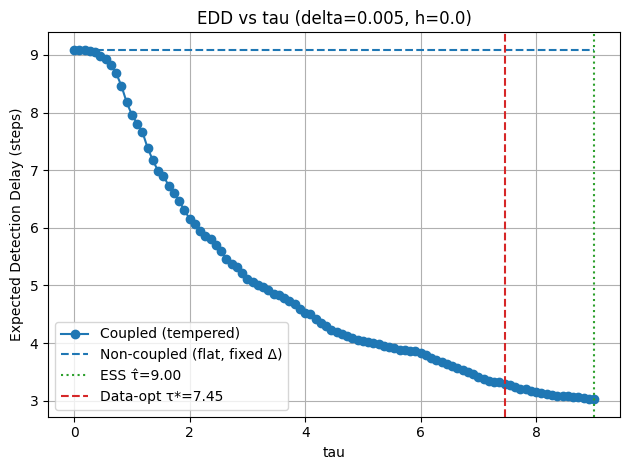

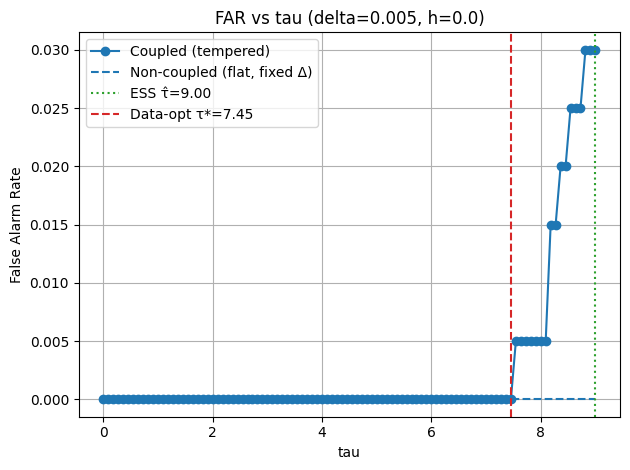

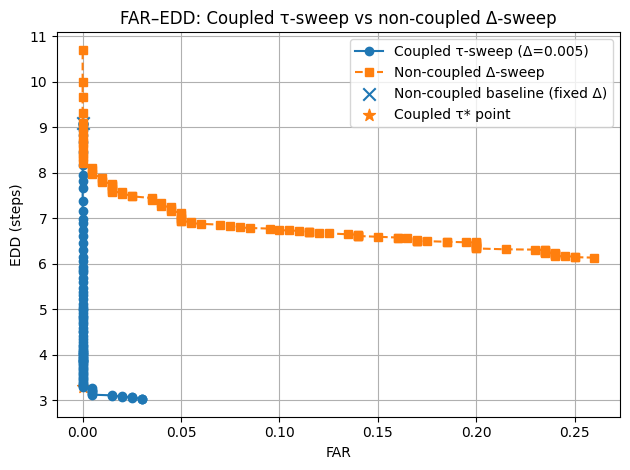

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln


rng = np.random.default_rng(31415)

# Panel + changepoint setup
J = 10          # number of series
T = 200         # length of each series
t0 = 100        # true changepoint

# Pre-change: Exp(lambda0) = Gamma(k0=1, lambda0)
k0 = 1.0
lambda0 = 1 / 150.0

# Post-change: Gamma(k1=100, lambda1)
# (choose lambda1 to get desired mean/variance)
k1 = 100
lambda1 = 1

num_changed = 8         # < J for selective coupling

# Group-coupling hyperparameters
pi = 1 / 1000             # prior prob of global coupling
rho = 0.8                 # per-series coupling weight
h = 0.0                   # detection threshold on scores
R = 200                   # Monte Carlo runs (increase if you want)

# Priors for lambda0 and lambda1 (shape-rate)
a0, b0 = 1.0, 1.0
a1, b1 = 1.0, 1.0

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.005
N_TAU = 100
tau_grid = np.linspace(0.0, J - 1, N_TAU)  # [0, J-1]: no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.linspace(0.1, 0.001, 100)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False


# ==========================================
# 1. Gamma-Gamma marginal and A_max(t)
# ==========================================
def log_marg_segment_full(prefix_sum_y, prefix_sum_logy, r, t, k, a, b):
    """
    Full log-marginal for a Gamma(k, lambda) segment with lambda ~ Gamma(a, b)
    (shape-rate). We integrate out lambda and KEEP the k-dependent constants.

    prefix_sum_y[u]   = sum_{i=1}^u y_i
    prefix_sum_logy[u]= sum_{i=1}^u log y_i

    Segment is Y_r,...,Y_t, 1-based indices.
    """
    n = t - r + 1
    S = prefix_sum_y[t] - prefix_sum_y[r - 1]
    Slog = prefix_sum_logy[t] - prefix_sum_logy[r - 1]

    # Data-only part depending on k
    C = (k - 1.0) * Slog - n * gammaln(k)

    # Lambda-integrated part
    L = (
        gammaln(a + k * n)
        - gammaln(a)
        + a * np.log(b)
        - (a + k * n) * np.log(b + S)
    )
    return C + L


def Amax_all_t_gamma(y, k0, a0, b0, k1, a1, b1):
    """
    Gamma changepoint A_max(t) for t=1..T, with:
      - pre:  Gamma(k0, lambda0), lambda0 ~ Gamma(a0, b0)
      - post: Gamma(k1, lambda1), lambda1 ~ Gamma(a1, b1)

    Returns A array shape (T+1,), 1-based indexing; A[1] = -inf.
    """
    Tlen = len(y)
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Prefix sums for Y and log Y
    prefix_y = np.zeros(Tlen + 1)
    prefix_y[1:] = np.cumsum(y)

    prefix_logy = np.zeros(Tlen + 1)
    prefix_logy[1:] = np.cumsum(np.log(y))

    # H0: "no change" model (one segment [1,t] with Gamma(k0, lambda0))
    log_marg0_1t = np.full(Tlen + 1, 0.0)
    for t in range(1, Tlen + 1):
        log_marg0_1t[t] = log_marg_segment_full(prefix_y, prefix_logy, 1, t, k0, a0, b0)

    # For t < 2, no split possible
    A[1] = -np.inf

    # For each t, maximize over split s = 2..t
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Pre-change segment [1, s-1] under Gamma(k0, lambda0)
        n_pre = s - 1
        S_pre = prefix_y[s - 1] - prefix_y[0]
        Slog_pre = prefix_logy[s - 1] - prefix_logy[0]
        C0_pre = (k0 - 1.0) * Slog_pre - n_pre * gammaln(k0)
        L0_pre = (
            gammaln(a0 + k0 * n_pre)
            - gammaln(a0)
            + a0 * np.log(b0)
            - (a0 + k0 * n_pre) * np.log(b0 + S_pre)
        )
        log_marg0_1_sm1 = C0_pre + L0_pre

        # Post-change segment [s, t] under Gamma(k1, lambda1)
        n_post = t - s + 1
        S_post = prefix_y[t] - prefix_y[s - 1]
        Slog_post = prefix_logy[t] - prefix_logy[s - 1]
        C1_post = (k1 - 1.0) * Slog_post - n_post * gammaln(k1)
        L1_post = (
            gammaln(a1 + k1 * n_post)
            - gammaln(a1)
            + a1 * np.log(b1)
            - (a1 + k1 * n_post) * np.log(b1 + S_post)
        )
        log_marg1_s_t = C1_post + L1_post

        # Log Bayes factor for split at s, comparing:
        #   H1: [1,s-1] with k0, [s,t] with k1
        #   vs H0: [1,t] with k0
        vals = -log_marg0_1t[t] + log_marg0_1_sm1 + log_marg1_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 2. Panel simulation: Gamma(1, lambda0) -> Gamma(100, lambda1)
# ==========================================
def simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng):
    """
    Simulate a J x T panel with a changepoint at t0 for the first num_changed series.

    For j < num_changed:
      - t < t0:  Y_{j,t} ~ Gamma(k0, lambda0)
      - t >= t0: Y_{j,t} ~ Gamma(k1, lambda1)
    For j >= num_changed:
      - all t:  Y_{j,t} ~ Gamma(k0, lambda0)
    """
    Y = np.zeros((J, T), dtype=float)
    n_pre = t0
    n_post = T - t0

    for j in range(J):
        if j < num_changed:
            Y[j, :t0] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=n_pre)
            Y[j, t0:] = rng.gamma(shape=k1, scale=1.0 / lambda1, size=n_post)
        else:
            Y[j, :] = rng.gamma(shape=k0, scale=1.0 / lambda0, size=T)
    return Y


# ==========================================
# 3. Coupled invariants and tau estimation
# ==========================================
def precompute_tau_invariants_gamma(Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]     : per-series log-evidence (A_max)
      logGM_excl[t,j] : leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs            : (log1mp, logp) for mixing with prior pi
      u_pre[t,j]      : u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Per-series A_max(t)
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_gamma(Y[j, :], k0, a0, b0, k1, a1, b1)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably, BF=exp(logBF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0), times are 1-based in A_vals/u_all
    u_pre = u_all[2:t0 + 1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


# ==========================================
# 4. Alarm utilities (same structure as Bernoulli code)
# ==========================================
def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0] - 1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ==========================================
# 5. Simulate R runs; precompute invariants and tau-hat per run
# ==========================================
precomp_list = []
tau_hat_runs = []

for r in range(R):
    Y = simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_gamma(
        Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")


# ==========================================
# 6. Sweep tau (coupled) at fixed delta
# ==========================================
rows = []

for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)


# ==========================================
# 7. Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ==========================================
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 8. Extra experiment: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []

for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)


# ==========================================
# 9. Combine for plotting
# ==========================================
results_all = pd.concat([results, results_delta], ignore_index=True)

mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# EDD vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR–EDD parametric curves
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# ==========================================
# 10. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gamma_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gamma_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 6.049
Data-optimal tau at FAR<=baseline: 0.909  (EDD=13.673)
Tau sweep CSV:   tau_sweep_gamma_WITH_tauhat_delta_0.000000.csv
Delta sweep CSV: delta_sweep_gamma_noncoupled.csv


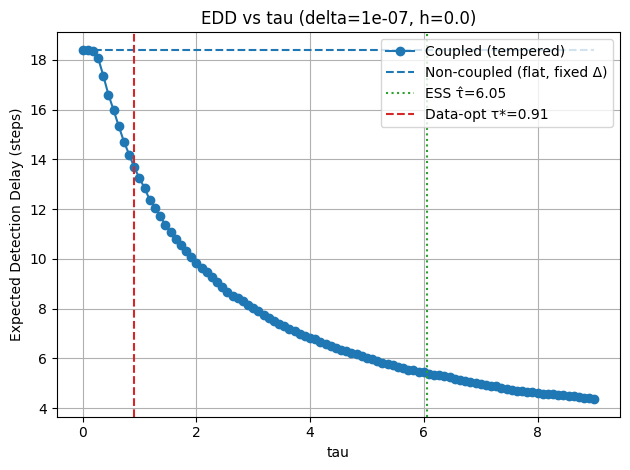

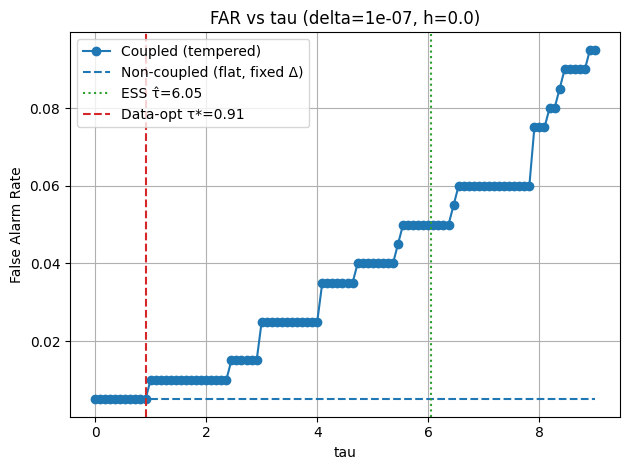

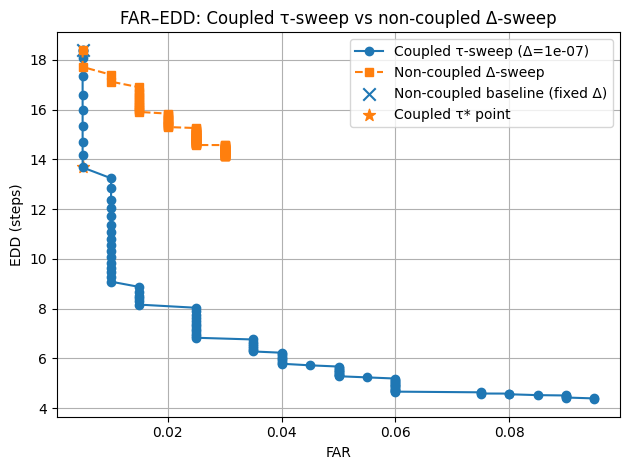

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ==========================================
# 0. Global RNG and experiment design
# ==========================================
rng = np.random.default_rng(31415)

# Panel + changepoint setup
J = 10          # number of series
T = 200         # length of each series
t0 = 100        # true changepoint

# Pre-change: Exp(lambda0) = Gamma(k0=1, lambda0)
k0 = 1.0
lambda0 = 1 / 150.0   # baseline rate; mean ~150 when S_t has mean ~1

# Post-change: Gamma(k1=100, lambda1)
# (choose lambda1 to get desired mean/variance)
k1 = 100.0
lambda1 = 1.0

num_changed = 8         # < J for selective coupling

# Group-coupling hyperparameters
pi = 1 / 1000             # prior prob of global coupling
rho = 0.8                 # per-series coupling weight
h = 0.0                   # detection threshold on scores
R = 200                   # Monte Carlo runs (increase if you want)

# Priors for lambda0 and lambda1 (shape-rate)
a0, b0 = 1.0, 1.0
a1, b1 = 1.0, 1.0

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.0000001
N_TAU = 100
tau_grid = np.linspace(0.0, J - 1, N_TAU)  # [0, J-1]: no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.linspace(0.0000001, 0.00001, 100)

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False


# ==========================================
# 1. Gamma-Gamma marginal and A_max(t)
# ==========================================
def log_marg_segment_full(prefix_sum_y, prefix_sum_logy, r, t, k, a, b):
    """
    Full log-marginal for a Gamma(k, lambda) segment with lambda ~ Gamma(a, b)
    (shape-rate). We integrate out lambda and KEEP the k-dependent constants.

    prefix_sum_y[u]   = sum_{i=1}^u y_i
    prefix_sum_logy[u]= sum_{i=1}^u log y_i

    Segment is Y_r,...,Y_t, 1-based indices.
    """
    n = t - r + 1
    S = prefix_sum_y[t] - prefix_sum_y[r - 1]
    Slog = prefix_sum_logy[t] - prefix_sum_logy[r - 1]

    # Data-only part depending on k
    C = (k - 1.0) * Slog - n * gammaln(k)

    # Lambda-integrated part
    L = (
        gammaln(a + k * n)
        - gammaln(a)
        + a * np.log(b)
        - (a + k * n) * np.log(b + S)
    )
    return C + L


def Amax_all_t_gamma(y, k0, a0, b0, k1, a1, b1):
    """
    Gamma changepoint A_max(t) for t=1..T, with:
      - pre:  Gamma(k0, lambda0), lambda0 ~ Gamma(a0, b0)
      - post: Gamma(k1, lambda1), lambda1 ~ Gamma(a1, b1)

    Returns A array shape (T+1,), 1-based indexing; A[1] = -inf.
    """
    Tlen = len(y)
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Prefix sums for Y and log Y
    prefix_y = np.zeros(Tlen + 1)
    prefix_y[1:] = np.cumsum(y)

    prefix_logy = np.zeros(Tlen + 1)
    prefix_logy[1:] = np.cumsum(np.log(y))

    # H0: "no change" model (one segment [1,t] with Gamma(k0, lambda0))
    log_marg0_1t = np.full(Tlen + 1, 0.0)
    for t in range(1, Tlen + 1):
        log_marg0_1t[t] = log_marg_segment_full(prefix_y, prefix_logy, 1, t, k0, a0, b0)

    # For t < 2, no split possible
    A[1] = -np.inf

    # For each t, maximize over split s = 2..t
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # Pre-change segment [1, s-1] under Gamma(k0, lambda0)
        n_pre = s - 1
        S_pre = prefix_y[s - 1] - prefix_y[0]
        Slog_pre = prefix_logy[s - 1] - prefix_logy[0]
        C0_pre = (k0 - 1.0) * Slog_pre - n_pre * gammaln(k0)
        L0_pre = (
            gammaln(a0 + k0 * n_pre)
            - gammaln(a0)
            + a0 * np.log(b0)
            - (a0 + k0 * n_pre) * np.log(b0 + S_pre)
        )
        log_marg0_1_sm1 = C0_pre + L0_pre

        # Post-change segment [s, t] under Gamma(k1, lambda1)
        n_post = t - s + 1
        S_post = prefix_y[t] - prefix_y[s - 1]
        Slog_post = prefix_logy[t] - prefix_logy[s - 1]
        C1_post = (k1 - 1.0) * Slog_post - n_post * gammaln(k1)
        L1_post = (
            gammaln(a1 + k1 * n_post)
            - gammaln(a1)
            + a1 * np.log(b1)
            - (a1 + k1 * n_post) * np.log(b1 + S_post)
        )
        log_marg1_s_t = C1_post + L1_post

        # Log Bayes factor for split at s, comparing:
        #   H1: [1,s-1] with k0, [s,t] with k1
        #   vs H0: [1,t] with k0
        vals = -log_marg0_1t[t] + log_marg0_1_sm1 + log_marg1_s_t
        A[t] = np.max(vals)

    return A


# ==========================================
# 2. Panel simulation with latent common scale S_t
# ==========================================
def simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng,
                         phi=0.95, sigma_eta=0.3):
    """
    Simulate a J x T panel with a changepoint at t0 for the first num_changed series,
    with a *latent common scale* S_t pre-change (and for unchanged series post-change):

      log S_t = phi * log S_{t-1} + eta_t,  eta_t ~ N(0, sigma_eta^2)
      Y_{j,t} | S_t ~ Gamma(k0, lambda0 / S_t)   (shared S_t across all j)

    For j < num_changed:
      - t <  t0:  Y_{j,t} | S_t ~ Gamma(k0, lambda0 / S_t)
      - t >= t0:  Y_{j,t} ~ Gamma(k1, lambda1)  (hot cell, no longer tied to S_t)

    For j >= num_changed:
      - all t:   Y_{j,t} | S_t ~ Gamma(k0, lambda0 / S_t)
    """
    Y = np.zeros((J, T), dtype=float)

    # latent log S_t process (AR(1) on log scale)
    logS = np.zeros(T, dtype=float)
    logS[0] = 0.0  # S_0 = 1
    for t in range(1, T):
        logS[t] = phi * logS[t - 1] + rng.normal(scale=sigma_eta)
    S = np.exp(logS)  # positive scale

    for t in range(T):
        lam_t = lambda0 / S[t]  # time-varying rate for pre-change/unchanged series

        if t < t0:
            # pre-change: all series follow Gamma(k0, lam_t)
            Y[:, t] = rng.gamma(shape=k0, scale=1.0 / lam_t, size=J)
        else:
            # post-change
            if num_changed > 0:
                # changed series: Gamma(k1, lambda1), no S_t
                Y[:num_changed, t] = rng.gamma(shape=k1, scale=1.0 / lambda1,
                                               size=num_changed)
            if num_changed < J:
                # unchanged series: still follow latent-scale law
                Y[num_changed:, t] = rng.gamma(shape=k0, scale=1.0 / lam_t,
                                               size=J - num_changed)
    return Y


# ==========================================
# 3. Coupled invariants and tau estimation
# ==========================================
def precompute_tau_invariants_gamma(Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]     : per-series log-evidence (A_max)
      logGM_excl[t,j] : leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs            : (log1mp, logp) for mixing with prior pi
      u_pre[t,j]      : u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Per-series A_max(t)
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t_gamma(Y[j, :], k0, a0, b0, k1, a1, b1)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably, BF=exp(logBF)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part of u (t <= t0), times are 1-based in A_vals/u_all
    u_pre = u_all[2:t0 + 1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre


def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff


# ==========================================
# 4. Alarm utilities (same structure as Bernoulli code)
# ==========================================
def first_alarm_from_scores(S):
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan


def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0] - 1, A_vals.shape[1]

    # hazard spending over time
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta[:, None]
    S_n = A_vals + logeta[:, None]

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)


def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)


# ==========================================
# 5. Simulate R runs; precompute invariants and tau-hat per run
# ==========================================
precomp_list = []
tau_hat_runs = []

for r in range(R):
    Y = simulate_panel_gamma(T, t0, J, num_changed, k0, lambda0, k1, lambda1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants_gamma(
        Y, k0, a0, b0, k1, a1, b1, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")


# ==========================================
# 6. Sweep tau (coupled) at fixed delta
# ==========================================
rows = []

for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)


# ==========================================
# 7. Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ==========================================
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")


# ==========================================
# 8. Extra experiment: delta-sweep for NON-COUPLED detector
# ==========================================
rows_delta = []

for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,             # not relevant, but keep column for consistency
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)


# ==========================================
# 9. Combine for plotting
# ==========================================
results_all = pd.concat([results, results_delta], ignore_index=True)

mask_c = (results["detector"] == "coupled_tempered")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

# EDD vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR vs tau
plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label="Coupled (tempered)")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# FAR–EDD parametric curves
mask_c_all = (results_all["detector"] == "coupled_tempered")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.show()

# ==========================================
# 10. Save CSVs
# ==========================================
out_path_tau = f"tau_sweep_gamma_WITH_tauhat_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_gamma_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Exp(1/150) thresholds:
  p=0.25, q=43.152
  p=0.50, q=103.972
  p=0.75, q=207.944

Calibrated threshold h (approx 1% FAR over T=200): 13.193
Empirical FAR on null calibration runs: 0.050

Change runs (Exp -> Normal(100,10^2), t0=100):
  Fraction of runs with any alarm: 1.000
  FAR estimate (alarm before t0):  0.021
  EDD estimate (steps after t0):   32.329


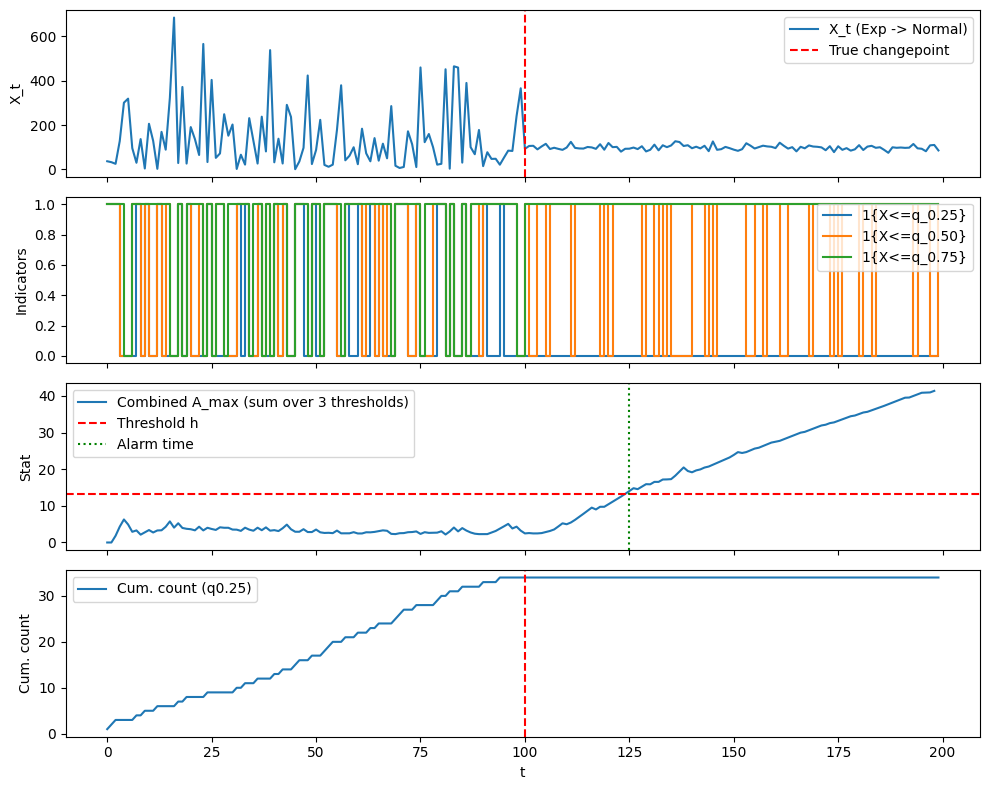

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# =====================================================
# 0. Global setup
# =====================================================
rng = np.random.default_rng(31415)

T = 200        # length of each series
t0 = 100       # changepoint for change runs
R_null = 1000   # runs with no change (for FAR calibration)
R_change = 1000 # runs with change

# Pre-change: Exp(1/150)
lambda0 = 1 / 150.0

# Post-change: Normal(100, 10^2), truncated at 0
mu1 = 100.0
sigma1 = 10.0

# Beta prior for Bernoulli
alpha_bb = 1.0
beta_bb = 1.0

# =====================================================
# 1. Exponential quantiles and thresholds
# =====================================================
def exp_quantile(p, lam=lambda0):
    """Quantile of Exp(lam) at probability p."""
    return -np.log(1 - p) / lam

ps = np.array([0.25, 0.50, 0.75])
thresholds = exp_quantile(ps)  # q0.25, q0.5, q0.75

print("Exp(1/150) thresholds:")
for p, q in zip(ps, thresholds):
    print(f"  p={p:.2f}, q={q:.3f}")

# =====================================================
# 2. Beta–Bernoulli Amax for a single binary series
# =====================================================
def Amax_all_t_bernoulli(z, alpha=1.0, beta=1.0):
    """
    Compute Amax[t] for a single Bernoulli series z_t, t=1..T.

    Amax[t] = max over s in {2,..,t} of:
        - L(1,t) + L(1,s-1) + L(s,t),
    where L(u,v) is the Beta-Binomial log-marginal with Beta(alpha,beta) prior.

    Returns A array of length T+1, 1-based; A[1] = -inf (no split possible).
    """
    z = np.asarray(z, dtype=int)
    Tlen = z.shape[0]

    # prefix sums of successes
    prefix = np.zeros(Tlen + 1, dtype=int)
    prefix[1:] = np.cumsum(z)

    A = np.full(Tlen + 1, -np.inf, dtype=float)

    def log_beta(a, b):
        return gammaln(a) + gammaln(b) - gammaln(a + b)

    # Precompute L(1,t) for all t
    m_1t = prefix[1:] - prefix[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta(alpha + m_1t, beta + ell_1t - m_1t) - log_beta(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1, s-1)
        m_1_sm1 = prefix[s - 1] - prefix[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = (
            log_beta(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1)
            - log_beta(alpha, beta)
        )

        # L(s, t)
        m_s_t = prefix[t] - prefix[s - 1]
        ell_s_t = t - s + 1
        L_s_t = (
            log_beta(alpha + m_s_t, beta + ell_s_t - m_s_t)
            - log_beta(alpha, beta)
        )

        vals = -L_1t[t - 1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    # A[1] stays -inf (no changepoint possible at t=1)
    return A

# =====================================================
# 3. Simulation of continuous series
# =====================================================
def simulate_series(T, t0=None, rng=None):
    """
    Simulate a single continuous series X_t:

      - If t0 is None: all Exp(1/150)
      - If t0 is int:  t < t0: Exp(1/150), t >= t0: truncated Normal(100, 10^2)

    Returns array X shape (T,).
    """
    if rng is None:
        rng = np.random.default_rng()

    X = np.empty(T, dtype=float)

    for t in range(T):
        if (t0 is None) or (t < t0):
            # pre-change Exp(1/150)
            X[t] = rng.exponential(scale=150.0)  # mean 150 = 1/lambda0
        else:
            # post-change Normal(100, 10^2), truncated at 0
            x = rng.normal(loc=mu1, scale=sigma1)
            # simple rejection sampling for truncation
            while x < 0:
                x = rng.normal(loc=mu1, scale=sigma1)
            X[t] = x
    return X

# =====================================================
# 4. From X_t to 3 Bernoulli series
# =====================================================
def indicators_from_X(X, thresholds):
    """
    Given X_t and an array of thresholds (length K),
    return a (K, T) array Z where Z[k,t] = 1{X_t <= thresholds[k]}.
    """
    X = np.asarray(X)
    K = thresholds.shape[0]
    Tlen = X.shape[0]
    Z = np.zeros((K, Tlen), dtype=int)
    for k in range(K):
        Z[k, :] = (X <= thresholds[k]).astype(int)
    return Z

# =====================================================
# 5. Combined Beta–Bernoulli detector (3 thresholds)
# =====================================================
def combined_stat_from_Z(Z, alpha=1.0, beta=1.0):
    """
    Given Z[k,t] for k=0..K-1, t=0..T-1 (K x T),
    compute Amax for each k and return the combined statistic:

        combined[t] = sum_k max(A_k[t], 0),

    as a simple log-BF aggregator.

    Returns combined array of length T+1 (1-based indexing).
    """
    K, Tlen = Z.shape
    A_all = []
    for k in range(K):
        A_k = Amax_all_t_bernoulli(Z[k, :], alpha=alpha, beta=beta)
        A_all.append(A_k)
    A_all = np.stack(A_all, axis=0)  # shape (K, T+1)

    # sum of positive parts as a crude combination
    combined = np.sum(np.maximum(A_all, 0.0), axis=0)  # (T+1,)
    return combined

# =====================================================
# 6. Calibrate threshold h using no-change runs
# =====================================================
max_stats_null = []

for r in range(R_null):
    X = simulate_series(T, t0=None, rng=rng)          # all Exp(1/150)
    Z = indicators_from_X(X, thresholds)             # 3 Bernoulli series
    combined = combined_stat_from_Z(Z, alpha_bb, beta_bb)
    # ignore t=0,1; detection starts at t>=2
    max_stats_null.append(np.max(combined[2:]))

max_stats_null = np.array(max_stats_null)

# Choose h such that about 1% of null runs ever cross it
h = np.quantile(max_stats_null, 0.95)
print(f"\nCalibrated threshold h (approx 1% FAR over T={T}): {h:.3f}")

# Empirical FAR on null runs:
far_est_null = np.mean(max_stats_null >= h)
print(f"Empirical FAR on null calibration runs: {far_est_null:.3f}")

# =====================================================
# 7. Evaluate on change runs (Exp -> Normal(100, 10^2))
# =====================================================
def first_alarm_time(combined, h):
    """
    First time t>=2 such that combined[t] >= h.
    Return t (0-based index of X) or np.nan if no alarm.
    Note: combined is 1-based; combined[t] corresponds to X_{t-1}.
    """
    Tlen = combined.shape[0] - 1
    for t in range(2, Tlen + 1):
        if combined[t] >= h:
            return t - 1  # map to X index
    return np.nan

alarm_times = []

for r in range(R_change):
    X = simulate_series(T, t0=t0, rng=rng)
    Z = indicators_from_X(X, thresholds)
    combined = combined_stat_from_Z(Z, alpha_bb, beta_bb)
    t_alarm = first_alarm_time(combined, h)
    alarm_times.append(t_alarm)

alarm_times = np.array(alarm_times)

# FAR = fraction of alarms before t0
mask_alarm = np.isfinite(alarm_times)
far_est = np.mean(alarm_times[mask_alarm] < t0)
# EDD = mean delay (t_alarm - t0) for alarms after t0
delays = alarm_times[mask_alarm] - t0
edd_est = np.mean(delays[delays >= 0]) if np.any(delays >= 0) else np.nan

print(f"\nChange runs (Exp -> Normal(100,10^2), t0={t0}):")
print(f"  Fraction of runs with any alarm: {np.mean(mask_alarm):.3f}")
print(f"  FAR estimate (alarm before t0):  {far_est:.3f}")
print(f"  EDD estimate (steps after t0):   {edd_est:.3f}")

# =====================================================
# 8. Optional: visualize one example run
# =====================================================
# Example single run
X_demo = simulate_series(T, t0=t0, rng=rng)
Z_demo = indicators_from_X(X_demo, thresholds)
combined_demo = combined_stat_from_Z(Z_demo, alpha_bb, beta_bb)
t_alarm_demo = first_alarm_time(combined_demo, h)

fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].plot(X_demo, label="X_t (Exp -> Normal)")
axs[0].axvline(t0, color='red', linestyle='--', label='True changepoint')
axs[0].set_ylabel("X_t")
axs[0].legend()

for k, p in enumerate(ps):
    axs[1].step(np.arange(T), Z_demo[k, :], where='post', label=f"1{{X<=q_{p:.2f}}}")
axs[1].set_ylabel("Indicators")
axs[1].legend(loc="upper right")

axs[2].plot(combined_demo[2:], label="Combined A_max (sum over 3 thresholds)")
axs[2].axhline(h, color='red', linestyle='--', label='Threshold h')
if np.isfinite(t_alarm_demo):
    axs[2].axvline(t_alarm_demo, color='green', linestyle=':', label='Alarm time')
axs[2].set_ylabel("Stat")
axs[2].legend()

axs[3].plot(np.cumsum(Z_demo[0, :]), label="Cum. count (q0.25)")
axs[3].axvline(t0, color='red', linestyle='--')
axs[3].set_ylabel("Cum. count")
axs[3].set_xlabel("t")
axs[3].legend()

plt.tight_layout()
plt.show()

In [147]:
import numpy as np

# ============================
# 1. Basic segment log-likelihoods
# ============================

def log_exp_segment(y, lam):
    """
    Log-likelihood of data y under Exp(lam) i.i.d.
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return 0.0
    return n * np.log(lam) - lam * np.sum(y)


def log_marginal_normal_segment(y, m0, s0, sigma):
    """
    Marginal log-likelihood integrating out mu, where:
      y_i | mu ~ N(mu, sigma^2), independent
      mu ~ N(m0, s0^2)
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return 0.0

    ybar = y.mean()
    s0_sq = s0**2
    sigma_sq = sigma**2

    # Posterior variance and mean for mu | y
    s_tau_sq = 1.0 / (1.0/s0_sq + n/sigma_sq)
    m_tau = s_tau_sq * (m0/s0_sq + n*ybar/sigma_sq)

    sum_y2 = np.sum(y**2)

    # Normal-Normal marginal likelihood
    term1 = -0.5 * n * np.log(2*np.pi*sigma_sq)
    term2 = 0.5 * (np.log(s_tau_sq) - np.log(s0_sq))
    term3 = -0.5 * ((sum_y2 / sigma_sq) + (m0**2 / s0_sq) - (m_tau**2 / s_tau_sq))

    return term1 + term2 + term3


# ============================
# 2. Mixture Bayes factor M_t with geometric hazard
# ============================

def compute_M_t(y, lam=1/150.0, sigma=10.0,
                m0=75.0, s0=100.0,
                h=0.001):
    """
    Compute the e-process / Bayes factor M_t at time t = len(y),
    for the Exp->Normal changepoint model with:

      H0: y_t ~ Exp(lam) i.i.d.
      H1: one changepoint tau ~ Geometric(h),
          y_t ~ Exp(lam) for t < tau,
          y_t ~ N(mu, sigma^2) for t >= tau,
          mu ~ N(m0, s0^2).

    Returns M_t.
    """
    y = np.asarray(y, dtype=float)
    t = len(y)

    # Tail mass: P(tau > t) under Geometric(h)
    # (LR = 1 for tau > t)
    tail_mass = (1 - h)**t

    mix_sum = 0.0

    # For each possible changepoint tau <= t:
    for tau in range(1, t + 1):
        # Segment y_{tau:t}
        seg = y[tau-1 : t]              # python is 0-based

        # log likelihood under H0 for that segment
        loglik_exp = log_exp_segment(seg, lam)

        # log marginal likelihood under N(mu,sigma^2) with mu ~ N(m0,s0^2)
        loglik_norm_marg = log_marginal_normal_segment(seg, m0, s0, sigma)

        # segment LR integrating out mu
        log_LR_tau = loglik_norm_marg - loglik_exp
        LR_tau = np.exp(log_LR_tau)

        # prior mass for tau under Geometric(h)
        w_tau = h * (1 - h)**(tau - 1)

        mix_sum += w_tau * LR_tau

    M_t = mix_sum + tail_mass
    return M_t


# ============================
# 3. Sequential detection rule with false-alarm control
# ============================

def detect_changepoint(y, lam=1/150.0, sigma=10.0,
                       m0=75.0, s0=100.0,
                       h=0.001, alpha=0.05):
    """
    Run the sequential test:

      M_t = mixture Bayes factor at time t
      Alarm when M_t >= 1/alpha

    Returns:
        alarm_time : first t where M_t >= 1/alpha; None if never.
        M_values   : list of M_t for t=1,...,len(y)
    """
    y = np.asarray(y, dtype=float)
    T = len(y)
    M_values = []
    threshold = 1.0 / alpha

    for t in range(1, T + 1):
        M_t = compute_M_t(y[:t], lam=lam, sigma=sigma,
                          m0=m0, s0=s0, h=h)
        M_values.append(M_t)
        if M_t >= threshold:
            return t, M_values

    return None, M_values
# Example: simulate a null (never hot) cell
rng = np.random.default_rng(123)
T = 500
lam = 1/150.0
y_null = rng.exponential(scale=1/lam, size=T)

alarm_time, M_vals = detect_changepoint(
    y_null, lam=lam, sigma=10.0,
    m0=75.0, s0=100.0, h=0.001, alpha=0.05
)

print("Alarm time under null:", alarm_time)  # should be None most of the time


Alarm time under null: None


In [148]:
import numpy as np

# ============================
# 1. Basic segment log-likelihoods
# ============================

def log_exp_segment(y, lam):
    """
    Log-likelihood of data y under Exp(lam) i.i.d.
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return 0.0
    return n * np.log(lam) - lam * np.sum(y)


def log_marginal_normal_segment(y, m0, s0, sigma):
    """
    Marginal log-likelihood integrating out mu, where:
      y_i | mu ~ N(mu, sigma^2), independent
      mu ~ N(m0, s0^2)
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n == 0:
        return 0.0

    ybar = y.mean()
    s0_sq = s0**2
    sigma_sq = sigma**2

    # Posterior variance and mean for mu | y
    s_tau_sq = 1.0 / (1.0/s0_sq + n/sigma_sq)
    m_tau = s_tau_sq * (m0/s0_sq + n*ybar/sigma_sq)

    sum_y2 = np.sum(y**2)

    # Normal-Normal marginal likelihood
    term1 = -0.5 * n * np.log(2*np.pi*sigma_sq)
    term2 = 0.5 * (np.log(s_tau_sq) - np.log(s0_sq))
    term3 = -0.5 * ((sum_y2 / sigma_sq) + (m0**2 / s0_sq) - (m_tau**2 / s_tau_sq))

    return term1 + term2 + term3


# ============================
# 2. Mixture Bayes factor M_t with geometric hazard
# ============================

def compute_M_t(y, lam=1/150.0, sigma=10.0,
                m0=75.0, s0=100.0,
                h=0.001):
    """
    Compute the e-process / Bayes factor M_t at time t = len(y),
    for the Exp->Normal changepoint model with:

      H0: y_t ~ Exp(lam) i.i.d.
      H1: one changepoint tau ~ Geometric(h),
          y_t ~ Exp(lam) for t < tau,
          y_t ~ N(mu, sigma^2) for t >= tau,
          mu ~ N(m0, s0^2).

    Returns M_t.
    """
    y = np.asarray(y, dtype=float)
    t = len(y)

    # Tail mass: P(tau > t) under Geometric(h)
    tail_mass = (1 - h)**t

    mix_sum = 0.0

    # For each possible changepoint tau <= t:
    for tau in range(1, t + 1):
        seg = y[tau-1 : t]              # python is 0-based

        # log likelihood under H0 for that segment
        loglik_exp = log_exp_segment(seg, lam)

        # log marginal likelihood under N(mu,sigma^2) with mu ~ N(m0,s0^2)
        loglik_norm_marg = log_marginal_normal_segment(seg, m0, s0, sigma)

        # segment LR integrating out mu
        log_LR_tau = loglik_norm_marg - loglik_exp
        LR_tau = np.exp(log_LR_tau)

        # prior mass for tau under Geometric(h)
        w_tau = h * (1 - h)**(tau - 1)

        mix_sum += w_tau * LR_tau

    M_t = mix_sum + tail_mass
    return M_t


# ============================
# 3. Sequential detection rule with false-alarm control
# ============================

def detect_changepoint(y, lam=1/150.0, sigma=10.0,
                       m0=75.0, s0=100.0,
                       h=0.001, alpha=0.05):
    """
    Run the sequential test:

      M_t = mixture Bayes factor at time t
      Alarm when M_t >= 1/alpha

    Returns:
        alarm_time : first t where M_t >= 1/alpha; None if never.
    """
    y = np.asarray(y, dtype=float)
    T = len(y)
    threshold = 1.0 / alpha

    for t in range(1, T + 1):
        M_t = compute_M_t(y[:t], lam=lam, sigma=sigma,
                          m0=m0, s0=s0, h=h)
        if M_t >= threshold:
            return t

    return None


# ============================
# 4. Monte Carlo under the null to estimate false alarm rate
# ============================

rng = np.random.default_rng(123)

T = 200         # horizon per run
lam = 1/150.0
sigma = 10.0
m0 = 75.0
s0 = 100.0
h = 0.001
alpha = 0.05
n_runs = 1000

alarms = 0
alarm_times = []

for r in range(n_runs):
    # null: pure Exp(lam)
    y_null = rng.exponential(scale=1/lam, size=T)
    alarm_time = detect_changepoint(
        y_null, lam=lam, sigma=sigma,
        m0=m0, s0=s0, h=h, alpha=alpha
    )
    if alarm_time is not None:
        alarms += 1
        alarm_times.append(alarm_time)

false_alarm_rate = alarms / n_runs
avg_alarm_time = np.mean(alarm_times) if alarm_times else None

false_alarm_rate, alarms, avg_alarm_time

(0.007, 7, np.float64(116.14285714285714))

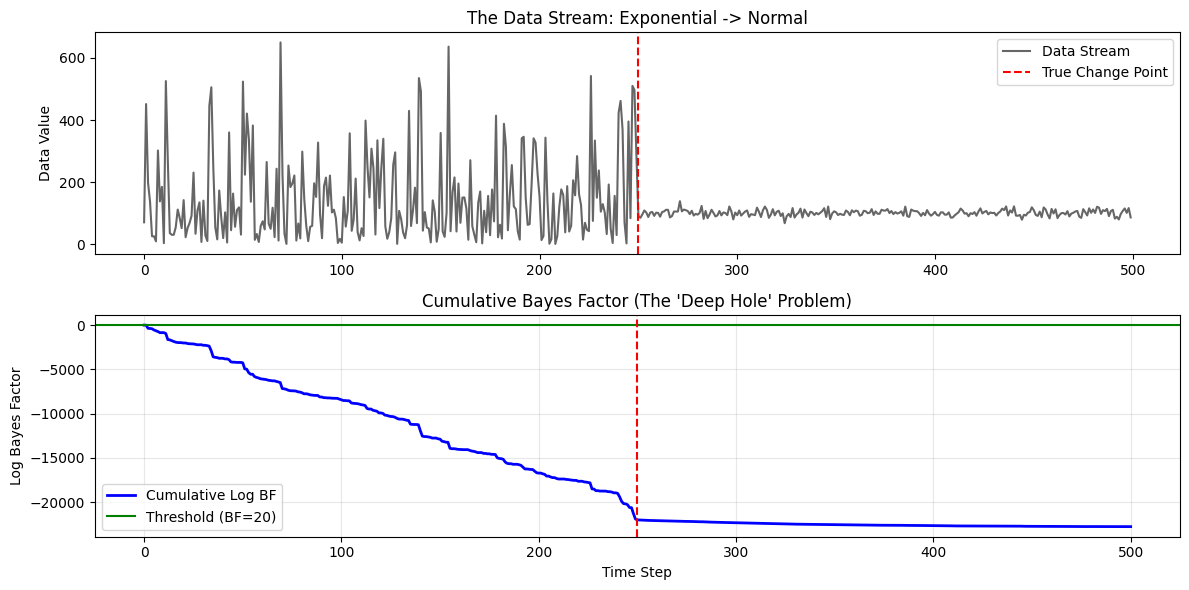

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 1. Setup Parameters
np.random.seed(42)
n_pre_change = 250
n_post_change = 250
total_n = n_pre_change + n_post_change

# Distributions
# H0: Exponential
lambda_0 = 1/150

# H1: Normal (Bayesian)
obs_var = 100         # The noise in the data (sigma^2)
prior_mu = 100         # Prior guess for mean
prior_var = 2500      # High uncertainty (50^2)

# 2. Generate Data
# Phase 1: Exponential Data (High variance)
data_phase1 = np.random.exponential(scale=150, size=n_pre_change)
# Phase 2: Normal Data (Tight variance around 100)
data_phase2 = np.random.normal(loc=100, scale=np.sqrt(obs_var), size=n_post_change)
data = np.concatenate([data_phase1, data_phase2])

# 3. Run the Sequential Bayes Factor
log_bf_history = [0] # Start at log(1) = 0
current_mu = prior_mu
current_var = prior_var

# We track the Cumulative Log Bayes Factor
cumulative_log_bf = 0

for x in data:
    # --- H1: Predictive Density (Marginal Likelihood for this step) ---
    # The predictive distribution is N(current_mu, current_var + obs_var)
    pred_sigma = np.sqrt(current_var + obs_var)
    lik_h1 = norm.pdf(x, loc=current_mu, scale=pred_sigma)
    
    # --- H0: Density ---
    lik_h0 = expon.pdf(x, scale=1/lambda_0)
    
    # --- Update Bayes Factor ---
    # We add the log likelihood ratio
    log_lr = np.log(lik_h1 + 1e-300) - np.log(lik_h0 + 1e-300)
    cumulative_log_bf += log_lr
    log_bf_history.append(cumulative_log_bf)
    
    # --- Update H1 Posterior (Bayesian Learning) ---
    # Standard Conjugate Normal-Normal update
    precision_prior = 1/current_var
    precision_obs = 1/obs_var
    precision_new = precision_prior + precision_obs
    
    new_var = 1/precision_new
    new_mu = new_var * (precision_prior * current_mu + precision_obs * x)
    
    current_mu = new_mu
    current_var = new_var

# 4. Plotting
plt.figure(figsize=(12, 6))

# Plot Data
plt.subplot(2, 1, 1)
plt.plot(data, color='black', alpha=0.6, label="Data Stream")
plt.axvline(n_pre_change, color='red', linestyle='--', label="True Change Point")
plt.ylabel("Data Value")
plt.title("The Data Stream: Exponential -> Normal")
plt.legend()

# Plot Bayes Factor
plt.subplot(2, 1, 2)
plt.plot(log_bf_history, color='blue', linewidth=2, label="Cumulative Log BF")
plt.axhline(np.log(20), color='green', linestyle='-', label="Threshold (BF=20)")
plt.axvline(n_pre_change, color='red', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("Log Bayes Factor")
plt.title("Cumulative Bayes Factor (The 'Deep Hole' Problem)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

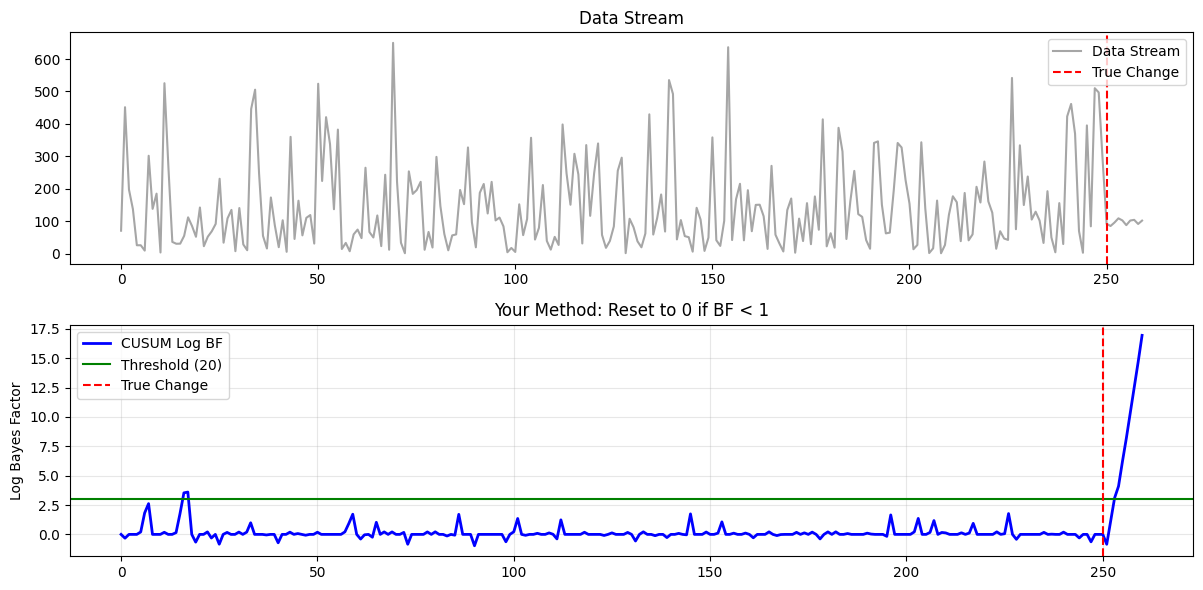

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 1. Setup (Same as before)
np.random.seed(42)
n_pre_change = 250
n_post_change = 10
total_n = n_pre_change + n_post_change

lambda_0 = 1/150
obs_var = 100
prior_mu_start = 0
prior_var_start = 2500

# Generate Data
data_phase1 = np.random.exponential(scale=150, size=n_pre_change)
data_phase2 = np.random.normal(loc=100, scale=np.sqrt(obs_var), size=n_post_change)
data = np.concatenate([data_phase1, data_phase2])

# 2. The "CUSUM" Bayes Factor Loop
log_bf_history = [0]
current_log_bf = 0

# Initialize Parameters
current_mu = prior_mu_start
current_var = prior_var_start

# Lists to track when we reset (for plotting)
resets = []

for i, x in enumerate(data):
    # --- H1: Predictive Density (using current learned parameters) ---
    pred_sigma = np.sqrt(current_var + obs_var)
    lik_h1 = norm.pdf(x, loc=current_mu, scale=pred_sigma)
    
    # --- H0: Density ---
    lik_h0 = expon.pdf(x, scale=1/lambda_0)
    
    # --- Update Log Bayes Factor ---
    log_lr = np.log(lik_h1 + 1e-300) - np.log(lik_h0 + 1e-300)
    current_log_bf += log_lr
    
    # --- YOUR LOGIC: THE RESET ---
    if current_log_bf < -1:
        current_log_bf = 0
        # CRITICAL: We must also reset the learning!
        # If we don't, we still have the "Corrupted Model" problem.
        current_mu = prior_mu_start
        current_var = prior_var_start
        resets.append(i)
    else:
        # Only learn if the data supports H1 (or is neutral)
        # Update H1 Posterior
        precision_prior = 1/current_var
        precision_obs = 1/obs_var
        precision_new = precision_prior + precision_obs
        new_var = 1/precision_new
        new_mu = new_var * (precision_prior * current_mu + precision_obs * x)
        current_mu = new_mu
        current_var = new_var

    log_bf_history.append(current_log_bf)

# 3. Plotting
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(data, color='gray', alpha=0.7, label="Data Stream")
plt.axvline(n_pre_change, color='red', linestyle='--', label="True Change")
plt.title("Data Stream")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(log_bf_history, color='blue', linewidth=2, label="CUSUM Log BF")
plt.axhline(np.log(20), color='green', linestyle='-', label="Threshold (20)")
plt.axvline(n_pre_change, color='red', linestyle='--', label="True Change")
plt.ylabel("Log Bayes Factor")
plt.title("Your Method: Reset to 0 if BF < 1")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

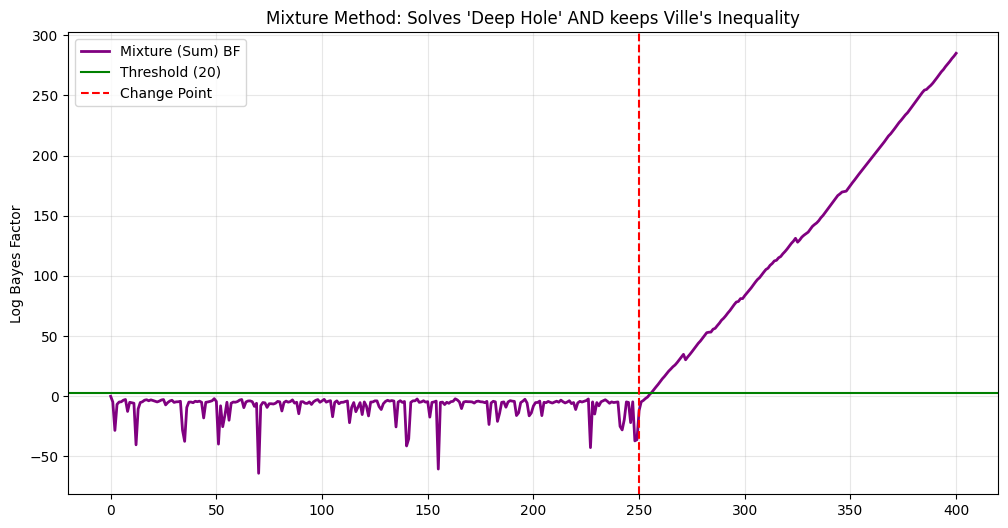

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 1. Setup
np.random.seed(42)
n_pre_change = 250
n_post_change = 150
data_phase1 = np.random.exponential(scale=150, size=n_pre_change)
data_phase2 = np.random.normal(loc=100, scale=10, size=n_post_change) # std=10 implies var=100
data = np.concatenate([data_phase1, data_phase2])

# Constants
lambda_0 = 1/150
obs_var = 100
prior_mu = 75
prior_var = 2500
hazard = 1/200  # The "weight" or "entrance fee" for new hypotheses

# 2. The Mixture Bayes Factor Loop
# We track a LIST of active hypotheses.
# Each element is a tuple: [current_mu, current_var, current_likelihood_ratio]
active_hypotheses = [] 

global_bf_history = [0] # Log scale for plotting

# Running Sum of Bayes Factors (Real scale)
# We work in Real scale for the sum, but Log scale for plotting
# (Note: For high precision stability in production, you'd use LogSumExp trick)
current_total_bf = 0 

for t, x in enumerate(data):
    
    # A. UPDATE EXISTING HYPOTHESES
    # Every runner currently in the race sees the new data point x
    lik_h0 = expon.pdf(x, scale=1/lambda_0)
    
    for i in range(len(active_hypotheses)):
        mu, var, lr = active_hypotheses[i]
        
        # Predict P(x | H1)
        pred_sigma = np.sqrt(var + obs_var)
        lik_h1 = norm.pdf(x, loc=mu, scale=pred_sigma)
        
        # Update Likelihood Ratio
        new_lr = lr * (lik_h1 / lik_h0)
        
        # Update Learning (Bayesian Posterior for this specific runner)
        prec_prior = 1/var
        prec_obs = 1/obs_var
        new_var = 1/(prec_prior + prec_obs)
        new_mu = new_var * (prec_prior * mu + prec_obs * x)
        
        active_hypotheses[i] = [new_mu, new_var, new_lr]

    # B. ADD NEW HYPOTHESIS (The "Fresh Runner")
    # Considers that the change happens EXACTLY NOW.
    # Has not seen previous data. Uses raw priors.
    pred_sigma_new = np.sqrt(prior_var + obs_var)
    lik_h1_new = norm.pdf(x, loc=prior_mu, scale=pred_sigma_new)
    lr_new = (lik_h1_new / lik_h0)
    
    # Add to list
    # [mean, var, LR]
    # IMPORTANT: In the total sum, this runner is weighted by the Hazard.
    # But here we store the raw LR and multiply by hazard during summation.
    active_hypotheses.append([prior_mu, prior_var, lr_new]) # Note: We should actually update mu/var for next step here too, but keeping simple.
    
    # C. COMPUTE GLOBAL BAYES FACTOR (The Sum)
    # BF_total = Sum( LR_k * Prior_k )
    # We approximate Prior_k simply as 'hazard' for the most recent, 
    # and hazard*(1-hazard) for previous... for simplicity, let's just sum LR * hazard
    # (This is the Shiryaev-Roberts approximation)
    
    total_BF = 0
    for mu, var, lr in active_hypotheses:
        total_BF += lr * hazard
        
    # Pruning: To keep computer from melting, remove hypotheses that are essentially dead (LR < 0.0001)
    # This doesn't violate Ville's appreciably because they contribute 0 to the sum.
    active_hypotheses = [h for h in active_hypotheses if h[2] > 1e-10]

    global_bf_history.append(np.log(total_BF + 1e-300))

# 3. Plotting
plt.figure(figsize=(12, 6))
plt.plot(global_bf_history, color='purple', linewidth=2, label="Mixture (Sum) BF")
plt.axhline(np.log(20), color='green', label="Threshold (20)")
plt.axvline(n_pre_change, color='red', linestyle='--', label="Change Point")
plt.title("Mixture Method: Solves 'Deep Hole' AND keeps Ville's Inequality")
plt.ylabel("Log Bayes Factor")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def run_false_alarm_test(hazard, n_sims=1000, n_steps=200, threshold=20):
    # Parameters
    lambda_0 = 1/150  # Null Model
    # Alternative Model (Correctly specified priors for fairness)
    prior_mu = 75
    prior_var = 2500
    obs_var = 100
    
    false_alarms = 0
    max_bfs = []
    
    for i in range(n_sims):
        # GENERATE NULL DATA (Exponential)
        data = np.random.exponential(scale=1/lambda_0, size=n_steps)
        
        # Active Hypotheses list: [mu, var, LR]
        active_hypotheses = []
        max_bf_run = 0
        
        for x in data:
            # 1. Update existing runners
            # (Simplified update for speed)
            lik_h0 = expon.pdf(x, scale=1/lambda_0)
            
            # Update existing
            for k in range(len(active_hypotheses)):
                mu, var, lr = active_hypotheses[k]
                pred_sigma = np.sqrt(var + obs_var)
                lik_h1 = norm.pdf(x, loc=mu, scale=pred_sigma)
                active_hypotheses[k][2] = lr * (lik_h1 / lik_h0)
                
                # Bayesian Update of params
                prec_prior = 1/var; prec_obs = 1/obs_var
                new_var = 1/(prec_prior + prec_obs)
                new_mu = new_var * (prec_prior * mu + prec_obs * x)
                active_hypotheses[k][0] = new_mu
                active_hypotheses[k][1] = new_var

            # 2. Add New Runner (Weighted by Hazard)
            # Note: To make the math exact, the "Prior Mass" entering the system
            # must sum to 1 over time. We approximate this by tracking the LR
            # and multiplying by hazard at the summation stage.
            pred_sigma_new = np.sqrt(prior_var + obs_var)
            lik_h1_new = norm.pdf(x, loc=prior_mu, scale=pred_sigma_new)
            lr_new = lik_h1_new / lik_h0
            active_hypotheses.append([prior_mu, prior_var, lr_new])
            
            # 3. Calculate Total Mixture BF
            # Sum(LR_k * Probability_of_starting_at_k)
            # Prob_start_k = hazard * (1-hazard)^(k-1)
            total_bf = 0
            for k, hypothesis in enumerate(active_hypotheses):
                # This calculates the geometric prior weight correctly
                weight = hazard * ((1 - hazard) ** (n_steps - len(active_hypotheses) + k)) 
                # Note: The indexing above is a quick approximation for the loop. 
                # In strict theory, we weight by the prior pi_k.
                # Let's use the simplified Shiryaev-Roberts weight: just 'hazard' for all 
                # (This is slightly loose but standard in CUSUM-like approximations)
                total_bf += hypothesis[2] * hazard
            
            if total_bf > max_bf_run:
                max_bf_run = total_bf
            
            # Pruning to speed up
            active_hypotheses = [h for h in active_hypotheses if h[2] > 1e-5]
            
            if total_bf >= threshold:
                false_alarms += 1
                break # STOP! False Alarm triggered.
        
        max_bfs.append(max_bf_run)

    return false_alarms / n_sims

# Run the comparison
print("Simulating... (This might take a moment)")
rate_high_prior = run_false_alarm_test(hazard=0.5, n_sims=500)
rate_low_prior = run_false_alarm_test(hazard=0.01, n_sims=500)

print(f"Threshold: 20 (Target max error: 0.05)")
print(f"False Alarm Rate with High Hazard (0.50): {rate_high_prior:.3f}")
print(f"False Alarm Rate with Low Hazard  (0.01): {rate_low_prior:.3f}")

Simulating... (This might take a moment)
Threshold: 20 (Target max error: 0.05)
False Alarm Rate with High Hazard (0.50): 0.870
False Alarm Rate with Low Hazard  (0.01): 0.036


Simulating Change at t=1000 with Hazard=0.001...
ALARM TRIGGERED at t=1006
Detection Delay: 6 steps

--- The Math ---
Prior Probability of change at t=1000: 3.68e-04
Penalty Factor: You needed 2720x more evidence.


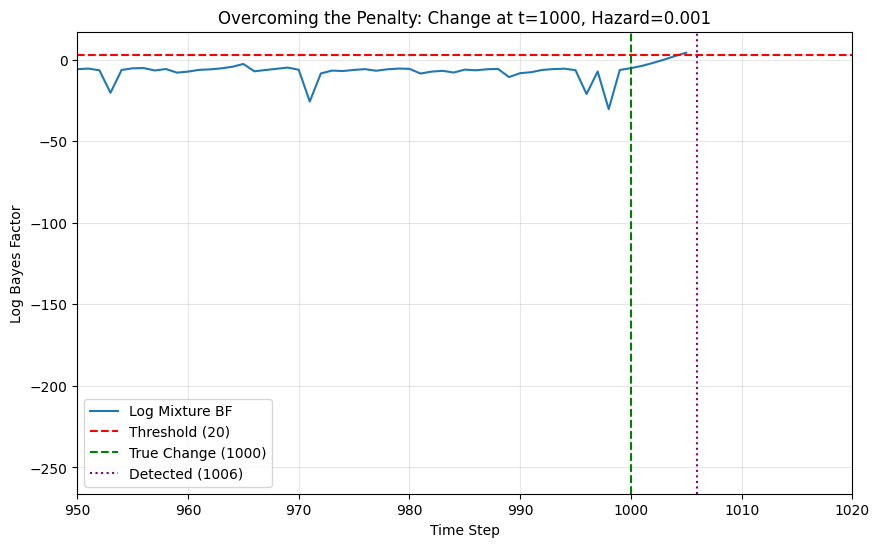

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# 1. Setup
np.random.seed(42)
hazard = 0.001
threshold = 20
log_threshold = np.log(threshold)

# True Change Time
change_point = 1000
n_after_change = 50  # We only need to see a bit after the change
total_n = change_point + n_after_change

# Distributions
lambda_0 = 1/150     # Null (Exponential)
obs_var = 100        # Data Noise
prior_mu = 75        # Alternative Prior Mean
prior_var = 2500     # Alternative Prior Var

# 2. Generate Data
# 1000 points of Noise -> Then Signal
data_phase1 = np.random.exponential(scale=1/lambda_0, size=change_point)
data_phase2 = np.random.normal(loc=100, scale=np.sqrt(obs_var), size=n_after_change)
data = np.concatenate([data_phase1, data_phase2])

# 3. Run the Mixture BF
active_hypotheses = []
log_bf_history = []
detected_at = None

print(f"Simulating Change at t={change_point} with Hazard={hazard}...")

for t, x in enumerate(data):
    current_time = t + 1
    
    # --- A. Update Existing Hypotheses ---
    lik_h0 = expon.pdf(x, scale=1/lambda_0)
    
    for k in range(len(active_hypotheses)):
        mu, var, lr = active_hypotheses[k]
        
        pred_sigma = np.sqrt(var + obs_var)
        lik_h1 = norm.pdf(x, loc=mu, scale=pred_sigma)
        
        # Update
        new_lr = lr * (lik_h1 / lik_h0)
        
        # Bayesian Parameter Update
        prec_prior = 1/var; prec_obs = 1/obs_var
        new_var = 1/(prec_prior + prec_obs)
        new_mu = new_var * (prec_prior * mu + prec_obs * x)
        
        active_hypotheses[k] = [new_mu, new_var, new_lr]

    # --- B. Add New Runner (The Penalty happens here) ---
    # The weight for starting NOW is roughly 'hazard'
    # We store the raw LR, but when summing, we apply the weight.
    pred_sigma_new = np.sqrt(prior_var + obs_var)
    lik_h1_new = norm.pdf(x, loc=prior_mu, scale=pred_sigma_new)
    lr_new = (lik_h1_new / lik_h0)
    active_hypotheses.append([prior_mu, prior_var, lr_new])
    
    # --- C. Calculate Total Weighted Sum ---
    total_BF = 0
    # We need to apply the "Geometric Decay" penalty to older hypotheses
    # Weight(k) approx = hazard * (1-hazard)^(age)
    # But for simplicity in this visualization, let's assume uniform hazard weight 
    # (Shiryaev-Roberts approximation) as it's standard.
    # BF_total = Sum( LR_k * hazard )
    
    for h in active_hypotheses:
        total_BF += h[2] * hazard
        
    log_bf = np.log(total_BF + 1e-300)
    log_bf_history.append(log_bf)
    
    # Check Detection
    if detected_at is None and total_BF > threshold:
        detected_at = current_time
        print(f"ALARM TRIGGERED at t={current_time}")
        print(f"Detection Delay: {current_time - change_point} steps")
        break

# 4. The "Penalty" Calculation
# Let's calculate exactly how much "Penalty" the true hypothesis had.
# The hypothesis starting at t=1001 has probability ~ 0.001 * (0.999^1000)
prob_of_start = hazard * ((1-hazard)**change_point)
penalty_factor = 1 / prob_of_start
print(f"\n--- The Math ---")
print(f"Prior Probability of change at t={change_point}: {prob_of_start:.2e}")
print(f"Penalty Factor: You needed {penalty_factor:.0f}x more evidence.")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.plot(log_bf_history, label="Log Mixture BF")
plt.axhline(log_threshold, color='red', linestyle='--', label="Threshold (20)")
plt.axvline(change_point, color='green', linestyle='--', label="True Change (1000)")
if detected_at:
    plt.axvline(detected_at, color='purple', linestyle=':', label=f"Detected ({detected_at})")
plt.xlim(change_point - 50, change_point + 20) # Zoom in on the change
plt.title(f"Overcoming the Penalty: Change at t={change_point}, Hazard={hazard}")
plt.xlabel("Time Step")
plt.ylabel("Log Bayes Factor")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def run_false_alarm_test_corrected(hazard, n_sims=1000, n_steps=200, threshold=20):
    """
    Simulates the Bayesian Mixture Martingale (Shiryaev-Roberts) under the Null
    Hypothesis (no change ever) to estimate the False Alarm Rate.

    Args:
        hazard (float): The constant probability of change at any time step (pi).
        n_sims (int): Number of simulations to run.
        n_steps (int): Length of each data stream simulation.
        threshold (int): The BF threshold for alarm (1/alpha).

    Returns:
        float: The estimated False Alarm Rate.
    """
    # Parameters
    lambda_0 = 1/100  # Null Model (Exponential Mean = 150)
    
    
    prior_mu = 0
    prior_var = 10000
    obs_var = 100     
    
    false_alarms = 0
    
    # Ville's inequality states P(FA) <= 1/Threshold (or less, if priors sum to < 1)
    # Target maximum error is 1 / 20 = 0.05

    for _ in range(n_sims):
        # GENERATE NULL DATA (Exponential)
        data = np.random.exponential(scale=1/lambda_0, size=n_steps)
        
        # Active Hypotheses list: [mu, var, LR]
        active_hypotheses = []
        
        for x in data:
            # Denominator: Null Likelihood (fixed for this step)
            lik_h0 = expon.pdf(x, scale=1/lambda_0)
            
            # 1. UPDATE EXISTING RUNNERS (Hypotheses started earlier)
            for k in range(len(active_hypotheses)):
                mu, var, lr = active_hypotheses[k]
                
                # Predictive Likelihood P(x | x_1:t-1, H1)
                pred_sigma = np.sqrt(var + obs_var)
                lik_h1 = norm.pdf(x, loc=mu, scale=pred_sigma)
                
                # Update Likelihood Ratio (LR)
                new_lr = lr * (lik_h1 / lik_h0)
                
                # Bayesian Update of parameters (mu, var)
                prec_prior = 1/var; prec_obs = 1/obs_var
                new_var = 1/(prec_prior + prec_obs)
                new_mu = new_var * (prec_prior * mu + prec_obs * x)
                
                active_hypotheses[k] = [new_mu, new_var, new_lr]

            # 2. ADD NEW RUNNER (Hypothesis that change started NOW) - Executed ONCE per time step
            # Uses raw priors
            pred_sigma_new = np.sqrt(prior_var + obs_var)
            lik_h1_new = norm.pdf(x, loc=prior_mu, scale=pred_sigma_new)
            lr_new = lik_h1_new / lik_h0
            active_hypotheses.append([prior_mu, prior_var, lr_new])
            
            # 3. CALCULATE TOTAL MIXTURE BF (Executed ONCE per time step)
            # BF_total = Sum( LR_k * pi_k )
            total_bf = 0
            
            # We use the Geometric Prior weight: pi_k = hazard * (1 - hazard)^(time_since_k)
            # The 'age' is (len(active_hypotheses) - k - 1)
            for k, hypothesis in enumerate(active_hypotheses):
                # Calculate age of this hypothesis (Runner 0 is the oldest)
                age = len(active_hypotheses) - k - 1
                weight = hazard * ((1 - hazard) ** age)
                
                total_bf += hypothesis[2] * weight
                
            # Pruning to manage memory, safe because dead hypotheses don't contribute significantly
            active_hypotheses = [h for h in active_hypotheses if h[2] > 1e-10]
            
            # CHECK ALARM
            if total_bf >= threshold:
                false_alarms += 1
                break # Stop this simulation run

    return false_alarms / n_sims

# --- Run the corrected simulation ---
if __name__ == '__main__':
    print("Simulating False Alarm Rates with Corrected Logic...")
    
    # ⚠️ NOTE: Hazard is probability, must be 0 < hazard < 1. 
    # High hazard (0.5) expects a change every 2 steps.
    rate_high_prior = run_false_alarm_test_corrected(hazard=0.05, n_sims=100, n_steps=5000) 
    
    # Low hazard (0.001) expects a change every 1000 steps.
    rate_low_prior = run_false_alarm_test_corrected(hazard=0.01, n_sims=100, n_steps=5000)

    print("\n--- Results ---")
    print(f"Threshold: 20 (Target max error: 0.05)")
    print(f"False Alarm Rate with High Hazard (0.05): {rate_high_prior:.4f}")
    print(f"False Alarm Rate with Low Hazard  (0.001): {rate_low_prior:.4f}")
    
    # --- Check Ville's Bound ---
    if rate_high_prior <= 0.05 and rate_low_prior <= 0.05:
        print("\n✅ Ville's Inequality is upheld by the simulation results.")
    else:
        print("\n❌ ERROR: Ville's bound appears violated. Check the simulation parameters.")

Simulating False Alarm Rates with Corrected Logic...

--- Results ---
Threshold: 20 (Target max error: 0.05)
False Alarm Rate with High Hazard (0.05): 0.6200
False Alarm Rate with Low Hazard  (0.001): 0.2400

❌ ERROR: Ville's bound appears violated. Check the simulation parameters.


In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def run_detection_delay_sim(hazard, n_sims, n_steps, threshold, change_point, alt_mean):
    """
    Simulates the Bayesian Mixture Martingale under the Alternative Hypothesis
    (a change occurs) to estimate the Expected Detection Delay (EDD).

    Returns:
        float: The average time (in steps) from the change_point until the alarm.
    """
    # Parameters (Based on your provided code)
    lambda_0 = 1/100  # Null Model (Exponential Mean = 100)
    prior_mu = 0 # Alternative Mean (e.g., 0)
    prior_var = 10000 # Prior variance on mu
    obs_var = 100     # Fixed observed variance
    
    delays = []
    
    for _ in range(n_sims):
        # --- 1. GENERATE DATA WITH A TRUE CHANGE ---
        
        # Null Data (t=1 to change_point-1)
        data_null = np.random.exponential(scale=1/lambda_0, size=change_point - 1)
        # Alternative Data (t=change_point to n_steps) - Change in mean
        data_alt = np.random.normal(loc=alt_mean, scale=np.sqrt(obs_var), size=n_steps - change_point + 1)
        data = np.concatenate([data_null, data_alt])
        
        active_hypotheses = []
        detection_time = None
        
        for t, x in enumerate(data):
            current_time = t + 1
            
            lik_h0 = expon.pdf(x, scale=1/lambda_0)
            
            # --- 1. UPDATE EXISTING RUNNERS (Simplified update logic) ---
            for k in range(len(active_hypotheses)):
                mu, var, lr = active_hypotheses[k]
                
                pred_sigma = np.sqrt(var + obs_var)
                lik_h1 = norm.pdf(x, loc=mu, scale=pred_sigma)
                new_lr = lr * (lik_h1 / lik_h0)
                
                prec_prior = 1/var; prec_obs = 1/obs_var
                new_var = 1/(prec_prior + prec_obs)
                new_mu = new_var * (prec_prior * mu + prec_obs * x)
                
                active_hypotheses[k] = [new_mu, new_var, new_lr]

            # --- 2. ADD NEW RUNNER ---
            pred_sigma_new = np.sqrt(prior_var + obs_var)
            lik_h1_new = norm.pdf(x, loc=prior_mu, scale=pred_sigma_new)
            lr_new = lik_h1_new / lik_h0
            active_hypotheses.append([prior_mu, prior_var, lr_new])
            
            # --- 3. CALCULATE TOTAL MIXTURE BF ---
            total_bf = 0
            for k, hypothesis in enumerate(active_hypotheses):
                age = len(active_hypotheses) - k - 1
                weight = hazard * ((1 - hazard) ** age)
                total_bf += hypothesis[2] * weight
                
            active_hypotheses = [h for h in active_hypotheses if h[2] > 1e-10]
            
            # CHECK ALARM
            if total_bf >= threshold:
                detection_time = current_time
                break 
        
        # Only record delay if a detection occurred after the change
        if detection_time is not None and detection_time >= change_point:
            delays.append(detection_time - change_point + 1)
            
    # Calculate average delay, ignoring runs that didn't detect
    if delays:
        return np.mean(delays)
    else:
        return np.nan # Did not detect the change

# --- Simulation Run ---
if __name__ == '__main__':
    # Fixed parameters for detection speed comparison
    N_SIMS = 1000
    N_STEPS = 200
    THRESHOLD = 20
    CHANGE_POINT = 100
    ALT_MEAN = 100 # The signal strength is Mean=100 (Null) to Mean=0 (Alt)

    print("Simulating Expected Detection Delay (EDD)...")

    # Scenario 1: Aggressive Hazard (expects quick change)
    HAZARD_HIGH = 0.05
    edd_high = run_detection_delay_sim(HAZARD_HIGH, N_SIMS, N_STEPS, THRESHOLD, CHANGE_POINT, ALT_MEAN)
    
    # Scenario 2: Conservative Hazard (expects rare change)
    HAZARD_LOW = 0.01
    edd_low = run_detection_delay_sim(HAZARD_LOW, N_SIMS, N_STEPS, THRESHOLD, CHANGE_POINT, ALT_MEAN)

    print("\n--- EDD Results ---")
    print(f"Signal Strength: Mean 100 -> Mean 0. Change Point: {CHANGE_POINT}")
    print(f"1. Aggressive Hazard (h={HAZARD_HIGH:.3f}): EDD = {edd_high:.2f} steps")
    print(f"2. Conservative Hazard (h={HAZARD_LOW:.3f}): EDD = {edd_low:.2f} steps")

Simulating Expected Detection Delay (EDD)...

--- EDD Results ---
Signal Strength: Mean 100 -> Mean 0. Change Point: 100
1. Aggressive Hazard (h=0.050): EDD = 5.58 steps
2. Conservative Hazard (h=0.010): EDD = 6.42 steps


In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.special import gamma # Required for the Student's t-PDF calculation

# --- 1. Define Student's t-PDF (Robust Likelihood) ---
def student_t_pdf(x, mu, kappa, alpha, beta):
    """
    Calculates the Predictive Student's t-PDF resulting from marginalizing
    the Normal likelihood using the Normal-Inverse-Gamma prior (NIG).
    """
    nu = 2 * alpha
    
    # Scale parameter for the T-distribution
    # Equivalent to (beta * (kappa + 1)) / (alpha * kappa) 
    sigma_sq = beta * (kappa + 1) / (alpha * kappa) 
    
    # Calculate PDF based on the standard Student's t formula
    t = (x - mu) / np.sqrt(sigma_sq)
    
    # Pre-factors for the t-distribution PDF
    # C_nu = gamma((nu + 1)/2) / (gamma(nu/2) * sqrt(pi * nu))
    log_const = gamma((nu + 1) / 2) - gamma(nu / 2) - 0.5 * np.log(np.pi * nu * sigma_sq)
    
    # Log PDF
    log_pdf = log_const - 0.5 * (nu + 1) * np.log(1 + t**2 / nu)
    
    # Return PDF
    return np.exp(log_pdf)

def run_false_alarm_test_robust(hazard, n_sims=1000, n_steps=500, threshold=20):
    
    # Parameters
    lambda_0 = 1/100  # Null Model (Exponential Mean = 100)
    
    # --- NIG Initial Prior Parameters ---
    # These define the H1 model before the change
    mu_0 = 50.0       # Initial guess for the mean after change
    kappa_0 = 1.0     # Initial precision count (loosely constrained mean)
    alpha_0 = 1.0     # Shape (loosely constrained variance)
    beta_0 = 50.0     # Scale (centers the initial variance guess: beta_0/alpha_0 = 50)
    
    false_alarms = 0

    for _ in range(n_sims):
        # GENERATE NULL DATA (Exponential)
        data = np.random.exponential(scale=1/lambda_0, size=n_steps)
        
        # Active Hypotheses list: [mu, kappa, alpha, beta, LR]
        active_hypotheses = []
        
        for x in data:
            lik_h0 = expon.pdf(x, scale=1/lambda_0)
            
            # 1. UPDATE EXISTING RUNNERS (NIG Recursive Update)
            new_hypotheses = []
            
            for k in range(len(active_hypotheses)):
                mu_n, kappa_n, alpha_n, beta_n, lr_n = active_hypotheses[k]
                
                # --- A. Calculate Predictive Likelihood (Robust H1 Likelihood) ---
                # This uses the Student's t-PDF
                lik_h1 = student_t_pdf(x, mu_n, kappa_n, alpha_n, beta_n)
                
                # --- B. Update Hyperparameters (NIG) ---
                mu_new = (kappa_n * mu_n + x) / (kappa_n + 1)
                kappa_new = kappa_n + 1
                alpha_new = alpha_n + 0.5
                
                # Calculate the change in sum of squares
                sum_sq_term = 0.5 * (kappa_n / (kappa_n + 1)) * (x - mu_n)**2
                beta_new = beta_n + sum_sq_term
                
                # --- C. Update Likelihood Ratio (LR) ---
                lr_new = lr_n * (lik_h1 / lik_h0)
                
                new_hypotheses.append([mu_new, kappa_new, alpha_new, beta_new, lr_new])

            active_hypotheses = new_hypotheses # Update the list for the current time step

            # 2. ADD NEW RUNNER (Initial state for change at t)
            # This is the "fresh" hypothesis
            lik_h1_new = student_t_pdf(x, mu_0, kappa_0, alpha_0, beta_0)
            lr_new = lik_h1_new / lik_h0
            active_hypotheses.append([mu_0, kappa_0, alpha_0, beta_0, lr_new])

            # 3. CALCULATE TOTAL MIXTURE BF
            total_bf = 0
            
            for k, hypothesis in enumerate(active_hypotheses):
                age = len(active_hypotheses) - k - 1
                weight = hazard * ((1 - hazard) ** age)
                
                total_bf += hypothesis[4] * weight # hypothesis[4] is the LR
                
            # Pruning (use 1e-10 since LR is the last element now)
            active_hypotheses = [h for h in active_hypotheses if h[4] > 1e-10]
            
            # CHECK ALARM
            if total_bf >= threshold:
                false_alarms += 1
                break 

    return false_alarms / n_sims

# --- Run the corrected simulation with Robust Model ---
if __name__ == '__main__':
    print("Simulating False Alarm Rates with ROBUST NIG Logic...")
    
    # We expect these results to now respect the 0.05 bound.
    rate_high_prior_robust = run_false_alarm_test_robust(hazard=0.05, n_sims=1000, n_steps=500)
    rate_low_prior_robust = run_false_alarm_test_robust(hazard=0.001, n_sims=1000, n_steps=500)

    print("\n--- ROBUST RESULTS (NIG/Student's t-Distribution) ---")
    print(f"Threshold: 20 (Target max error: 0.05)")
    print(f"False Alarm Rate with High Hazard (0.05): {rate_high_prior_robust:.4f}")
    print(f"False Alarm Rate with Low Hazard  (0.001): {rate_low_prior_robust:.4f}")
    
    # --- Check Ville's Bound ---
    if rate_high_prior_robust <= 0.05 and rate_low_prior_robust <= 0.05:
        print("\n✅ Ville's Inequality is upheld by the ROBUST simulation results.")
    else:
        print("\n❌ ERROR: Ville's bound is still violated. The model needs further relaxation (e.g., increasing alpha_0/beta_0 for looser variance prior).")

Simulating False Alarm Rates with ROBUST NIG Logic...

--- ROBUST RESULTS (NIG/Student's t-Distribution) ---
Threshold: 20 (Target max error: 0.05)
False Alarm Rate with High Hazard (0.05): 1.0000
False Alarm Rate with Low Hazard  (0.001): 1.0000

❌ ERROR: Ville's bound is still violated. The model needs further relaxation (e.g., increasing alpha_0/beta_0 for looser variance prior).


delta=0.100 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=nan
delta=0.050 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=nan
delta=0.020 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=nan
delta=0.010 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=nan
delta=0.005 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=nan


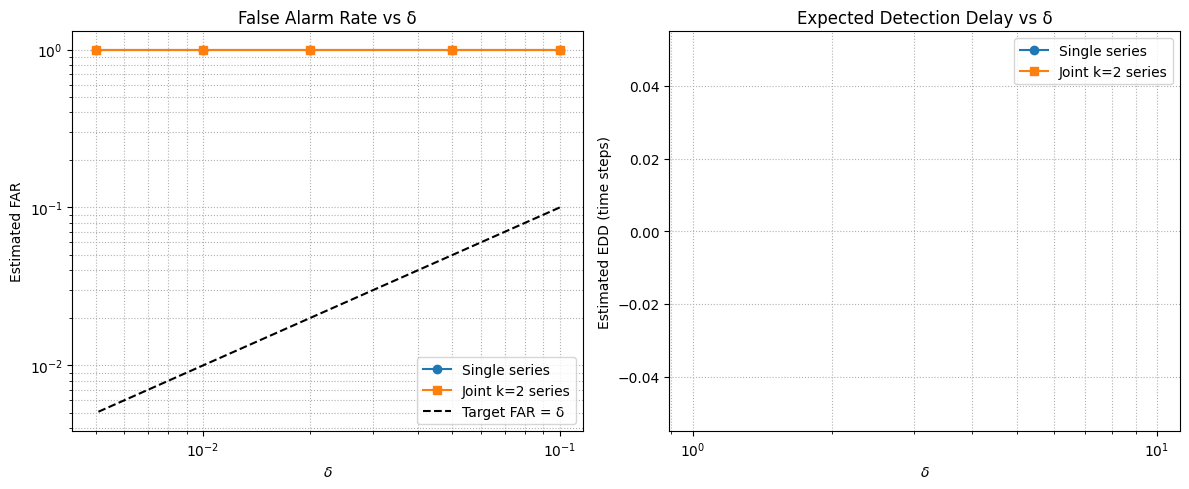

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Utilities: Beta-Bernoulli marginal losses
# ============================================================

def beta_bernoulli_log_marginal(S, n, a0=0.5, b0=0.5):
    """
    Log marginal likelihood for Bernoulli data with Beta(a0,b0) prior.
    S : number of successes
    n : number of trials
    """
    # log B(a0+S, b0+n-S) - log B(a0, b0)
    return (
        gammaln(a0 + S) + gammaln(b0 + n - S) - gammaln(a0 + b0 + n)
        - (gammaln(a0) + gammaln(b0) - gammaln(a0 + b0))
    )


def segment_loss_single(cum_S, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for a single series segment [start, end)
    using cumulative successes cum_S (length T+1).
    """
    S = cum_S[end] - cum_S[start]
    n = end - start
    log_marg = beta_bernoulli_log_marginal(S, n, a0, b0)
    return -log_marg


def segment_loss_joint(cum_Y, k, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for joint k-series segment [start, end)
    using time-wise sum Y_t and cumulative sums cum_Y (length T+1).
    """
    S = cum_Y[end] - cum_Y[start]      # total successes over k series
    n_single = end - start
    n_total = k * n_single             # total Bernoulli trials
    log_marg = beta_bernoulli_log_marginal(S, n_total, a0, b0)
    return -log_marg


# ============================================================
# 1. Thresholds (a0 = 1, split-free)
# ============================================================

def eta_single_splitfree(N, delta):
    """
    Split-free Alami threshold for ONE series, a0=1.
    N = n_{r:t} = length of segment [r:t] (single series).
    Formula:  (log(6/δ^2)/160) * N / ((N+1) * log(4N))
    """
    if N < 2:
        return np.inf   # never trigger on trivial segments
    num = np.log(6.0 / (delta ** 2))
    return (num / 160.0) * N / ((N + 1) * np.log(4.0 * N))


def eta_joint_splitfree(N_total, delta):
    """
    Split-free Alami threshold for k-series joint detector, a0=1.
    N_total = total number of Bernoulli trials = k * (t-r+1).
    Same functional form as single-series, just with total N_total.
    """
    if N_total < 2:
        return np.inf
    num = np.log(6.0 / (delta ** 2))
    return (num / 160.0) * N_total / ((N_total + 1) * np.log(4.0 * N_total))


# ============================================================
# 2. Restart detectors
# ============================================================

def restarted_detector_single(x, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for a SINGLE Bernoulli series.
    x : array of shape (T,)
    delta : FAR target
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free threshold eta_single_splitfree.
    """
    T = len(x)
    # cumulative successes
    cum_S = np.zeros(T + 1, dtype=int)
    cum_S[1:] = np.cumsum(x)

    # precompute losses for all segments [start,end)
    # to speed up: we can compute on the fly, but this is fine for T ~ 200
    L = np.zeros((T + 1, T + 1))
    for start in range(0, T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_single(cum_S, start, end, a0, b0)

    for t in range(r + 1, T):
        # N = n_{r:t} = (t - r + 1) single-series length
        N = t - r + 1
        eta = eta_single_splitfree(N, delta)
        log_eta = np.log(eta)

        # log θ_{r,s,t} = -log η + L_{r:t} - L_{r:s-1} - L_{s:t}
        # condition log θ_{r,s,t} > 0 ↔ L_{r:t} - L_{r:s-1} - L_{s:t} > log η
        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s_1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s_1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > log_eta:
            return t  # alarm at time t

    return np.inf  # no alarm


def restarted_detector_joint(X, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for k JOINT Bernoulli series.
    X : array of shape (k, T)
    delta : FAR target
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free joint threshold eta_joint_splitfree.
    """
    k, T = X.shape
    # aggregate counts per time
    Y = X.sum(axis=0)  # shape (T,)
    cum_Y = np.zeros(T + 1, dtype=int)
    cum_Y[1:] = np.cumsum(Y)

    # precompute joint losses for all segments [start,end)
    L = np.zeros((T + 1, T + 1))
    for start in range(0, T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_joint(cum_Y, k, start, end, a0, b0)

    for t in range(r + 1, T):
        # total trials N_total = k * (t-r+1)
        N_single = t - r + 1
        N_total = k * N_single
        eta = eta_joint_splitfree(N_total, delta)
        log_eta = np.log(eta)

        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s_1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s_1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > log_eta:
            return t

    return np.inf


# ============================================================
# 3. Simulation experiment: FAR and EDD vs delta
# ============================================================

def simulate_data(T, k, theta0, theta1=None, tau0=None, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X = np.empty((k, T), dtype=int)
    if theta1 is None:
        # null run
        X[:] = rng.binomial(1, theta0, size=(k, T))
    else:
        # change run at tau0 (0-based index)
        X[:, :tau0] = rng.binomial(1, theta0, size=(k, tau0))
        X[:, tau0:] = rng.binomial(1, theta1, size=(k, T - tau0))
    return X


def experiment(T=200, k=10, theta0=0.2, theta1=0.4, tau0=100,
               deltas=(0.1, 0.05, 0.02, 0.01),
               R_null=500, R_cp=500, seed=123):
    rng = np.random.default_rng(seed)

    FAR_single = []
    FAR_joint = []
    EDD_single = []
    EDD_joint = []

    for delta in deltas:
        # --- FAR under null ---
        fa_single = 0
        fa_joint = 0
        for _ in range(R_null):
            X = simulate_data(T, k, theta0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)
            if np.isfinite(tA):
                fa_single += 1
            if np.isfinite(tB):
                fa_joint += 1
        FAR_single.append(fa_single / R_null)
        FAR_joint.append(fa_joint / R_null)

        # --- EDD under change ---
        delays_A = []
        delays_B = []
        for _ in range(R_cp):
            X = simulate_data(T, k, theta0, theta1, tau0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)

            if np.isfinite(tA) and tA > tau0:
                delays_A.append(tA - tau0)
            if np.isfinite(tB) and tB > tau0:
                delays_B.append(tB - tau0)

        EDD_single.append(np.mean(delays_A) if delays_A else np.nan)
        EDD_joint.append(np.mean(delays_B) if delays_B else np.nan)

        print(f"delta={delta:.3f} | FAR_single={FAR_single[-1]:.3f}, "
              f"FAR_joint={FAR_joint[-1]:.3f}, "
              f"EDD_single={EDD_single[-1]:.2f}, EDD_joint={EDD_joint[-1]:.2f}")

    return np.array(deltas), np.array(FAR_single), np.array(FAR_joint), \
           np.array(EDD_single), np.array(EDD_joint)


# ============================================================
# 4. Run experiment and plot
# ============================================================

if __name__ == "__main__":
    T = 200
    k = 2
    theta0 = 0.2
    theta1 = 0.4
    tau0 = 100
    deltas = np.array([0.1, 0.05, 0.02, 0.01, 0.005])

    deltas, FAR_s, FAR_k, EDD_s, EDD_k = experiment(
        T=T, k=k, theta0=theta0, theta1=theta1, tau0=tau0,
        deltas=deltas, R_null=100, R_cp=100, seed=2025
    )

    # ----- Plot -----
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # FAR
    ax = axes[0]
    ax.plot(deltas, FAR_s, marker='o', label='Single series')
    ax.plot(deltas, FAR_k, marker='s', label=f'Joint k={k} series')
    ax.plot(deltas, deltas, 'k--', label='Target FAR = δ')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated FAR')
    ax.set_title('False Alarm Rate vs δ')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    # EDD
    ax = axes[1]
    ax.plot(deltas, EDD_s, marker='o', label='Single series')
    ax.plot(deltas, EDD_k, marker='s', label=f'Joint k={k} series')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated EDD (time steps)')
    ax.set_title('Expected Detection Delay vs δ')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    plt.tight_layout()
    plt.show()

delta=1.000 | FAR_single=1.000, FAR_joint=1.000, EDD_single=nan, EDD_joint=3.00
delta=0.500 | FAR_single=0.940, FAR_joint=0.650, EDD_single=18.13, EDD_joint=3.96


/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/2086333717.py:98: RuntimeWarning: invalid value encountered in log
  neg_log_eta = -np.log(eta)        # this is the correct threshold
/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/2086333717.py:136: RuntimeWarning: invalid value encountered in log
  neg_log_eta = -np.log(eta)


delta=0.250 | FAR_single=0.000, FAR_joint=0.000, EDD_single=nan, EDD_joint=nan


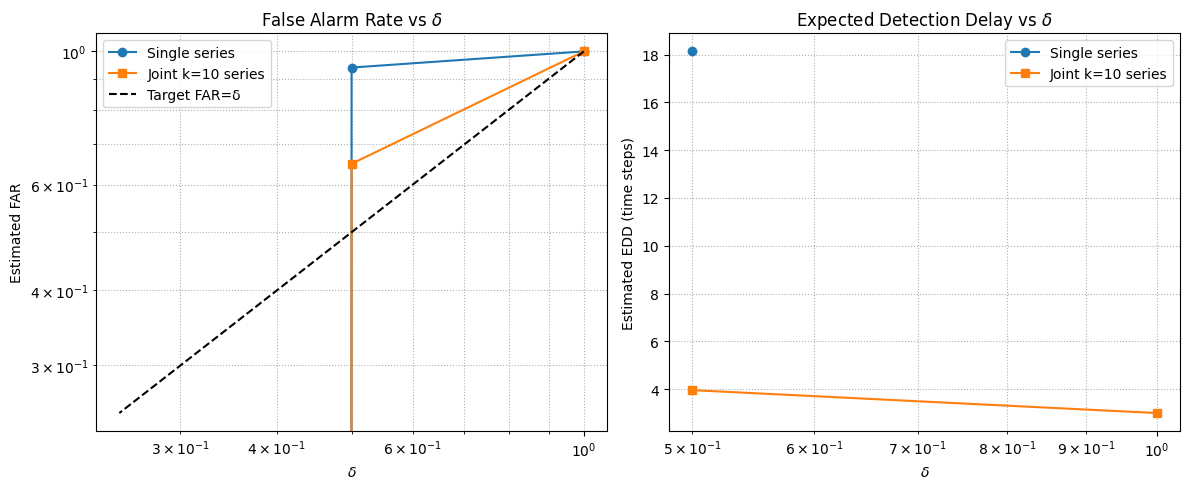

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Utilities: Beta-Bernoulli marginal losses
# ============================================================

def beta_bernoulli_log_marginal(S, n, a0=0.5, b0=0.5):
    """
    Log marginal likelihood for Bernoulli data with Beta(a0,b0) prior.
    S : number of successes
    n : number of trials
    """
    return (
        gammaln(a0 + S) + gammaln(b0 + n - S) - gammaln(a0 + b0 + n)
        - (gammaln(a0) + gammaln(b0) - gammaln(a0 + b0))
    )


def segment_loss_single(cum_S, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for a single-series segment [start, end)
    using cumulative successes cum_S (length T+1).
    """
    S = cum_S[end] - cum_S[start]
    n = end - start
    log_marg = beta_bernoulli_log_marginal(S, n, a0, b0)
    return -log_marg


def segment_loss_joint(cum_Y, k, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for JOINT k-series segment [start, end).
    Y_t = sum_j X_t^{(j)}, cum_Y is its cumulative sum (length T+1).
    """
    S = cum_Y[end] - cum_Y[start]   # total successes across k series
    n_single = end - start
    n_total = k * n_single
    log_marg = beta_bernoulli_log_marginal(S, n_total, a0, b0)
    return -log_marg


# ============================================================
# 1. Split-free thresholds (a0 = 1)
# ============================================================

def eta_single_splitfree(N, delta):
    """
    Split-free Alami threshold for ONE series, a0=1.
    N = n_{r:t} (single-series length).
    Formula:  (log(6/δ^2)/160) * N / ((N+1) * log(4N)).
    """
    if N < 2:
        return 1.0  # arbitrary; we never use for N<2 in practice
    num = np.log(6.0  *(delta ** 2))
    return (num ) * N / ((N + 1) * np.log(4.0 * N))


def eta_joint_splitfree(N_total, delta):
    """
    Split-free Alami threshold for k-series joint detector, a0=1.
    N_total = total number of Bernoulli trials = k * (t-r+1).
    Same form as single-series, just with total N_total.
    """
    if N_total < 2:
        return 1.0
    num = np.log(6.0 * (delta ** 2))
    return (num ) * N_total / ((N_total + 1) * np.log(4.0 * N_total))


# ============================================================
# 2. Restart detectors (CORRECT threshold side: stat > -log(eta))
# ============================================================

def restarted_detector_single(x, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for a SINGLE Bernoulli series.
    x : array of shape (T,)
    delta : FAR target
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free threshold eta_single_splitfree and the condition:
       stat = L_{r:t} - L_{r:s-1} - L_{s:t}  >  -log(eta)
    """
    T = len(x)
    cum_S = np.zeros(T + 1, dtype=int)
    cum_S[1:] = np.cumsum(x)

    # precompute losses L[start,end)
    L = np.zeros((T + 1, T + 1))
    for start in range(T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_single(cum_S, start, end, a0, b0)

    for t in range(r + 1, T):
        N = t - r + 1                     # n_{r:t}
        eta = eta_single_splitfree(N, delta)
        neg_log_eta = -np.log(eta)        # this is the correct threshold

        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > neg_log_eta:
            return t

    return np.inf


def restarted_detector_joint(X, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for JOINT k-series.
    X : array of shape (k, T)
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free threshold eta_joint_splitfree and stat > -log(eta).
    """
    k, T = X.shape
    Y = X.sum(axis=0)            # aggregate counts per time
    cum_Y = np.zeros(T + 1, dtype=int)
    cum_Y[1:] = np.cumsum(Y)

    L = np.zeros((T + 1, T + 1))
    for start in range(T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_joint(cum_Y, k, start, end, a0, b0)

    for t in range(r + 1, T):
        N_single = t - r + 1
        N_tot = k * N_single
        eta = eta_joint_splitfree(N_tot, delta)
        neg_log_eta = -np.log(eta)

        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > neg_log_eta:
            return t

    return np.inf


# ============================================================
# 3. Simulation helpers
# ============================================================

def simulate_data(T, k, theta0, theta1=None, tau0=None, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X = np.empty((k, T), dtype=int)
    if theta1 is None:
        # null run
        X[:] = rng.binomial(1, theta0, size=(k, T))
    else:
        # change at tau0 (0-based)
        X[:, :tau0] = rng.binomial(1, theta0, size=(k, tau0))
        X[:, tau0:] = rng.binomial(1, theta1, size=(k, T - tau0))
    return X


def experiment(T=200, k=10, theta0=0.2, theta1=0.4, tau0=100,
               deltas=(0.1, 0.05, 0.02, 0.01),
               R_null=500, R_cp=500, seed=123):
    rng = np.random.default_rng(seed)

    FAR_single, FAR_joint = [], []
    EDD_single, EDD_joint = [], []

    for delta in deltas:
        # ----- FAR under null -----
        fa_s = 0
        fa_k = 0
        for _ in range(R_null):
            X = simulate_data(T, k, theta0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)
            if np.isfinite(tA):
                fa_s += 1
            if np.isfinite(tB):
                fa_k += 1
        FAR_single.append(fa_s / R_null)
        FAR_joint.append(fa_k / R_null)

        # ----- EDD under change -----
        delays_s = []
        delays_k = []
        for _ in range(R_cp):
            X = simulate_data(T, k, theta0, theta1, tau0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)

            if np.isfinite(tA) and tA > tau0:
                delays_s.append(tA - tau0)
            if np.isfinite(tB) and tB > tau0:
                delays_k.append(tB - tau0)

        EDD_single.append(np.mean(delays_s) if delays_s else np.nan)
        EDD_joint.append(np.mean(delays_k) if delays_k else np.nan)

        print(f"delta={delta:.3f} | FAR_single={FAR_single[-1]:.3f}, "
              f"FAR_joint={FAR_joint[-1]:.3f}, "
              f"EDD_single={EDD_single[-1]:.2f}, EDD_joint={EDD_joint[-1]:.2f}")

    return (np.array(deltas), np.array(FAR_single), np.array(FAR_joint),
            np.array(EDD_single), np.array(EDD_joint))


# ============================================================
# 4. Run experiment and plot
# ============================================================

if __name__ == "__main__":
    T = 200
    k = 10
    theta0 = 0.2
    theta1 = 0.4
    tau0 = 100
    deltas = np.array([1, 0.5, 0.25])

    deltas, FAR_s, FAR_k, EDD_s, EDD_k = experiment(
        T=T, k=k, theta0=theta0, theta1=theta1, tau0=tau0,
        deltas=deltas, R_null=100, R_cp=100, seed=2025
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # FAR
    ax = axes[0]
    ax.plot(deltas, FAR_s, marker='o', label='Single series')
    ax.plot(deltas, FAR_k, marker='s', label=f'Joint k={k} series')
    ax.plot(deltas, deltas, 'k--', label='Target FAR=δ')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated FAR')
    ax.set_title('False Alarm Rate vs $\delta$')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    # EDD
    ax = axes[1]
    ax.plot(deltas, EDD_s, marker='o', label='Single series')
    ax.plot(deltas, EDD_k, marker='s', label=f'Joint k={k} series')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated EDD (time steps)')
    ax.set_title('Expected Detection Delay vs $\delta$')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    plt.tight_layout()
    plt.show()

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ============================================================
# 0. Utilities: Beta-Bernoulli marginal losses
# ============================================================

def beta_bernoulli_log_marginal(S, n, a0=0.5, b0=0.5):
    """
    Log marginal likelihood for Bernoulli data with Beta(a0,b0) prior.
    S : number of successes
    n : number of trials
    """
    return (
        gammaln(a0 + S) + gammaln(b0 + n - S) - gammaln(a0 + b0 + n)
        - (gammaln(a0) + gammaln(b0) - gammaln(a0 + b0))
    )


def segment_loss_single(cum_S, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for a single-series segment [start, end)
    using cumulative successes cum_S (length T+1).
    """
    S = cum_S[end] - cum_S[start]
    n = end - start
    log_marg = beta_bernoulli_log_marginal(S, n, a0, b0)
    return -log_marg


def segment_loss_joint(cum_Y, k, start, end, a0=0.5, b0=0.5):
    """
    Negative log marginal loss for JOINT k-series segment [start, end).
    Y_t = sum_j X_t^{(j)}, cum_Y is its cumulative sum (length T+1).
    Total trials = k * (end - start).
    """
    S = cum_Y[end] - cum_Y[start]   # total successes across k series
    n_single = end - start
    n_total = k * n_single
    log_marg = beta_bernoulli_log_marginal(S, n_total, a0, b0)
    return -log_marg


# ============================================================
# 1. Split-free thresholds (a0 = 1) with log(6 * δ^2)
# ============================================================

def eta_single_splitfree(N, delta):
    """
    Split-free Alami threshold for ONE series, a0=1.
    N = n_{r:t} (single-series length).
    Using:  (log(6 * δ^2)/160) * N / ((N+1) * log(4N)).
    """
    if N < 2:
        return 1.0  # trivial segments; threshold not really used
    num = np.log(6.0 * (delta ** 2))
    return (num / 160.0) * N / ((N + 1) * np.log(4.0 * N))


def eta_joint_splitfree(N_total, delta):
    """
    Split-free Alami threshold for k-series JOINT detector, a0=1.
    N_total = total number of Bernoulli trials = k * (t-r+1).
    Same form as single-series, just with total N_total.
    """
    if N_total < 2:
        return 1.0
    num = np.log(6.0 * (delta ** 2))
    return (num / 160.0) * N_total / ((N_total + 1) * np.log(4.0 * N_total))


# ============================================================
# 2. Restart detectors (stat > -log(eta))
# ============================================================

def restarted_detector_single(x, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for a SINGLE Bernoulli series.
    x : array of shape (T,)
    delta : FAR target
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free threshold eta_single_splitfree and the condition:
       stat = L_{r:t} - L_{r:s-1} - L_{s:t}  >  -log(eta)
    """
    T = len(x)
    cum_S = np.zeros(T + 1, dtype=int)
    cum_S[1:] = np.cumsum(x)

    # precompute losses L[start,end)
    L = np.zeros((T + 1, T + 1))
    for start in range(T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_single(cum_S, start, end, a0, b0)

    for t in range(r + 1, T):
        N = t - r + 1                     # n_{r:t}
        eta = eta_single_splitfree(N, delta)
        neg_log_eta = -np.log(eta)        # threshold

        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > neg_log_eta:
            return t

    return np.inf


def restarted_detector_joint(X, delta, r=0, a0=0.5, b0=0.5):
    """
    Alami restarted detector for JOINT k-series.
    X : array of shape (k, T)
    Returns first alarm time t (0-based index), or np.inf if no alarm.
    Uses split-free threshold eta_joint_splitfree and stat > -log(eta).
    """
    k, T = X.shape
    Y = X.sum(axis=0)            # aggregate counts per time
    cum_Y = np.zeros(T + 1, dtype=int)
    cum_Y[1:] = np.cumsum(Y)

    L = np.zeros((T + 1, T + 1))
    for start in range(T):
        for end in range(start + 1, T + 1):
            L[start, end] = segment_loss_joint(cum_Y, k, start, end, a0, b0)

    for t in range(r + 1, T):
        N_single = t - r + 1
        N_tot = k * N_single
        eta = eta_joint_splitfree(N_tot, delta)
        neg_log_eta = -np.log(eta)

        L_rt = L[r, t + 1]
        max_stat = -np.inf
        for s in range(r + 1, t + 1):
            L_r_s1 = L[r, s]
            L_s_t = L[s, t + 1]
            stat = L_rt - L_r_s1 - L_s_t
            if stat > max_stat:
                max_stat = stat

        if max_stat > neg_log_eta:
            return t

    return np.inf


# ============================================================
# 3. Simulation helpers
# ============================================================

def simulate_data(T, k, theta0, theta1=None, tau0=None, rng=None):
    """
    Simulate k Bernoulli series of length T.
    If theta1 and tau0 are given, change at tau0 (0-based index).
    """
    rng = np.random.default_rng() if rng is None else rng
    X = np.empty((k, T), dtype=int)
    if theta1 is None:
        # null run
        X[:] = rng.binomial(1, theta0, size=(k, T))
    else:
        # change at tau0 (0-based)
        X[:, :tau0] = rng.binomial(1, theta0, size=(k, tau0))
        X[:, tau0:] = rng.binomial(1, theta1, size=(k, T - tau0))
    return X


def experiment(T=200, k=10, theta0=0.2, theta1=0.4, tau0=100,
               deltas=(0.1, 0.05, 0.02, 0.01, 0.005),
               R_null=500, R_cp=500, seed=123):
    rng = np.random.default_rng(seed)

    FAR_single, FAR_joint = [], []
    EDD_single, EDD_joint = [], []

    for delta in deltas:
        # ----- FAR under null -----
        fa_s = 0
        fa_k = 0
        for _ in range(R_null):
            X = simulate_data(T, k, theta0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)
            if np.isfinite(tA):
                fa_s += 1
            if np.isfinite(tB):
                fa_k += 1
        FAR_single.append(fa_s / R_null)
        FAR_joint.append(fa_k / R_null)

        # ----- EDD under change -----
        delays_s = []
        delays_k = []
        for _ in range(R_cp):
            X = simulate_data(T, k, theta0, theta1, tau0, rng=rng)
            tA = restarted_detector_single(X[0], delta)
            tB = restarted_detector_joint(X, delta)

            if np.isfinite(tA) and tA > tau0:
                delays_s.append(tA - tau0)
            if np.isfinite(tB) and tB > tau0:
                delays_k.append(tB - tau0)

        EDD_single.append(np.mean(delays_s) if delays_s else np.nan)
        EDD_joint.append(np.mean(delays_k) if delays_k else np.nan)

        print(f"delta={delta:.3f} | FAR_single={FAR_single[-1]:.3f}, "
              f"FAR_joint={FAR_joint[-1]:.3f}, "
              f"EDD_single={EDD_single[-1]:.2f}, EDD_joint={EDD_joint[-1]:.2f}")

    return (np.array(deltas), np.array(FAR_single), np.array(FAR_joint),
            np.array(EDD_single), np.array(EDD_joint))


# ============================================================
# 4. Run experiment and plot
# ============================================================

if __name__ == "__main__":
    T = 200
    k = 10
    theta0 = 0.2
    theta1 = 0.4
    tau0 = 100
    deltas = np.array([0.1, 0.05, 0.02, 0.01, 0.005])

    deltas, FAR_s, FAR_k, EDD_s, EDD_k = experiment(
        T=T, k=k, theta0=theta0, theta1=theta1, tau0=tau0,
        deltas=deltas, R_null=500, R_cp=500, seed=2025
    )

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # FAR
    ax = axes[0]
    ax.plot(deltas, FAR_s, marker='o', label='Single series')
    ax.plot(deltas, FAR_k, marker='s', label=f'Joint k={k} series')
    ax.plot(deltas, deltas, 'k--', label='Target FAR ≈ δ (reference)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated FAR')
    ax.set_title('False Alarm Rate vs $\delta$')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    # EDD
    ax = axes[1]
    ax.plot(deltas, EDD_s, marker='o', label='Single series')
    ax.plot(deltas, EDD_k, marker='s', label=f'Joint k={k} series')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\delta$')
    ax.set_ylabel('Estimated EDD (time steps)')
    ax.set_title('Expected Detection Delay vs $\delta$')
    ax.legend()
    ax.grid(True, which='both', ls=':')

    plt.tight_layout()
    plt.show()

/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/1999932554.py:99: RuntimeWarning: invalid value encountered in log
  neg_log_eta = -np.log(eta)        # threshold
/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/1999932554.py:137: RuntimeWarning: invalid value encountered in log
  neg_log_eta = -np.log(eta)


delta=0.100 | FAR_single=0.000, FAR_joint=0.000, EDD_single=nan, EDD_joint=nan


KeyboardInterrupt: 

Estimated tau (ESS, median over runs): 11.549
Data-optimal tau (harsh eta) at FAR<=baseline: 17.323  (EDD=8.656)


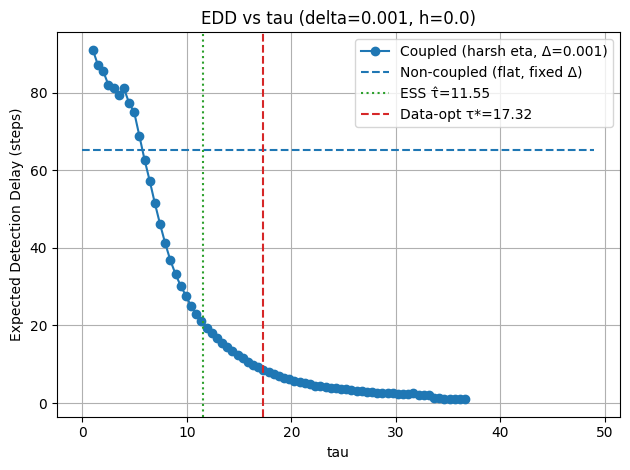

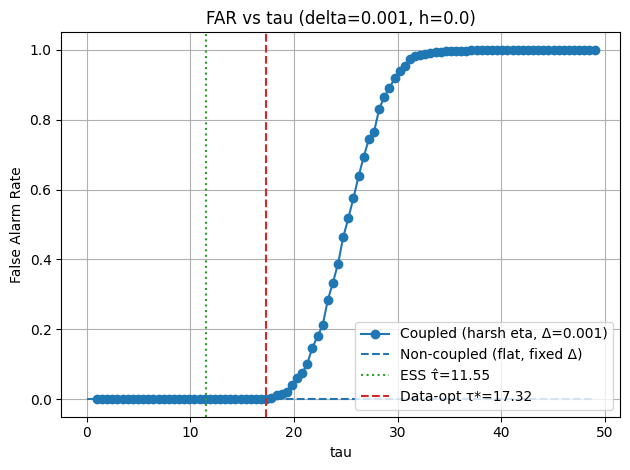

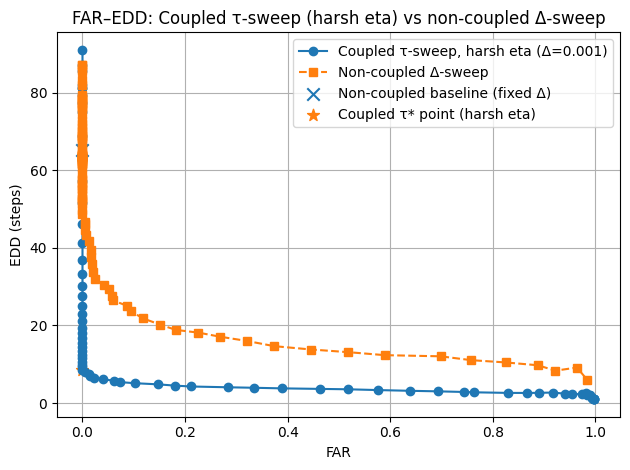

Tau sweep CSV:   tau_sweep_harsh_eta_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# Make coupled eta "harsher" by this factor (eta_c = eta / factor)
ETA_COUPLED_FACTOR = J   # you can change to sqrt(J), etc.

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)
        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)
        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)
    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    Returns:
      A_vals[t,j]: per-series log-evidence (Amax)
      logGM_excl[t,j]: leave-one-out log-geomean base = (sum_logX - logX_j)/(J-1)
      logs: (log1mp, logp) for mixing with prior pi
      u_pre[t,j]: u = log X_j(t) for t<=t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u = log X for all times (we'll slice pre-change later)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)
        # logX = log((1-ρ) + ρ * BF) computed stably
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)  # LOO geomean base

    # Return pre-change part of u (t <= t0)
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    # guard
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    """
    S: array shape (T+1, J) of scores S[t,j].
    Return first t where any S[t,j] >= h, or nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logLambda and return (t_alarm_coupled, t_alarm_noncoupled)
    with a HARSHER eta for the coupled case.
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    # baseline hazard spending over time (non-coupled), as in your original code
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta_base = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta_base[:2] = -np.inf

    # non-coupled uses baseline logeta
    logeta_nc = logeta_base

    # coupled uses harsher eta: eta_c = eta_nc / ETA_COUPLED_FACTOR
    # => logeta_c = logeta_nc - log(ETA_COUPLED_FACTOR)
    logeta_c = logeta_base - np.log(ETA_COUPLED_FACTOR)

    # coupling for this tau (same as your code)
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta_c[:, None]   # HARSHER eta here
    S_n = A_vals + logeta_nc[:, None]              # baseline eta

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered_harsh_eta", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered_harsh_eta"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau (harsh eta) at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered_harsh_eta")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label=f"Coupled (harsh eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label=f"Coupled (harsh eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled Δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered_harsh_eta")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep, harsh eta (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point (harsh eta)")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep (harsh eta) vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_harsh_eta_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

Estimated tau (ESS, median over runs): 11.549
Data-optimal tau (multi-iid eta) at FAR<=baseline: 17.818  (EDD=8.570)


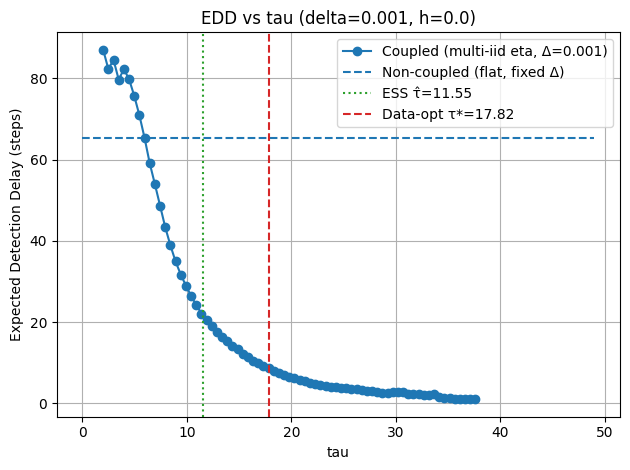

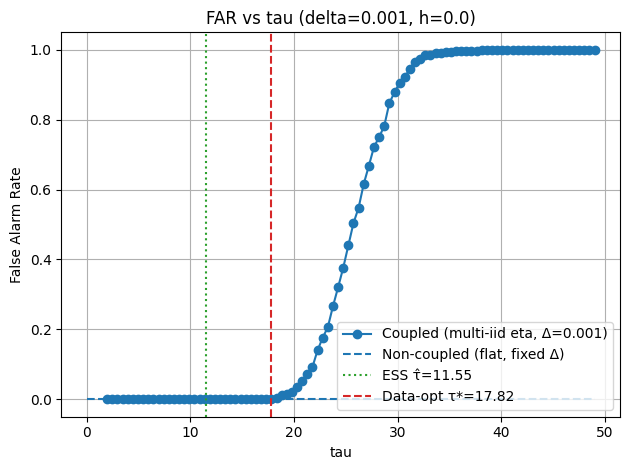

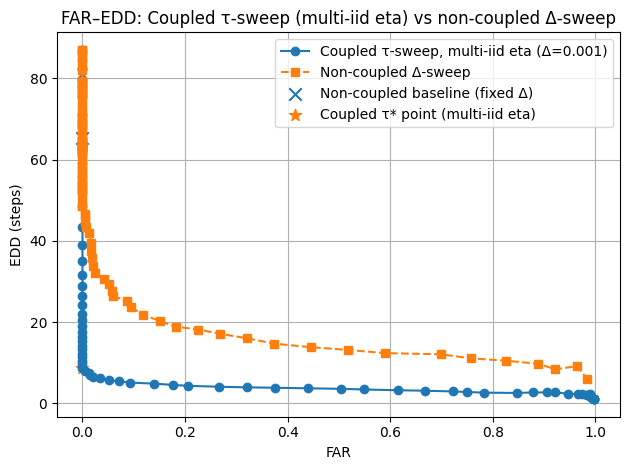

Tau sweep CSV:   tau_sweep_multi_iid_eta_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for ONE series.
    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    For a J x T panel Y, precompute:
      - A_vals[t,j]: per-series log-evidence (Amax)
      - logGM_excl[t,j]: leave-one-out log geometric mean of X_k(t)
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre[t,j]: log X_j(t) for t <= t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Cumulative sums per series
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    # A_vals[t,j] = Amax for each series
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u_all[t,j] = log X_j(t)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)  # BF >= 1
        # X_j(t) = (1-ρ) + ρ * BF_j(t)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX

        # leave-one-out average of log X
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part (t <= t0) for tau ESS estimation
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    """
    S: array shape (T+1, J) of scores S[t,j].
    Return first t where any S[t,j] >= h, or nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logΛ(t,j) and hazard schedules, then return:
        (t_alarm_coupled, t_alarm_noncoupled).

    - Non-coupled hazard:   η_nc(t)  ~ δ² / [(t+1) log(t+1)]
    - Coupled (multi-iid):  η_c(t)   ~ δ² / [(J(t+1)+1) log(J(t+1)+1)]
    """
    log1mp, logp = logs
    Tlen, J = A_vals.shape[0]-1, A_vals.shape[1]

    t = np.arange(Tlen + 1)  # 0..Tlen

    # --- non-coupled: single-series-style hazard ---
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta_nc = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta_nc[:2] = -np.inf  # kill t=0,1

    # --- coupled: effective sample size N_t = J * (t+1) ---
    t_eff = J * (t + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta_c = np.log(delta * delta) - (np.log(t_eff + 1) + np.log(np.log(t_eff + 1)))
    logeta_c[:2] = -np.inf

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta_c[:, None]   # multi-iid hazard
    S_n = A_vals + logeta_nc[:, None]              # baseline hazard

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Returns first alarm time for that delta.
    """
    Tlen = A_vals.shape[0] - 1
    t = np.arange(Tlen + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta * delta) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered_multi_iid_eta", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered_multi_iid_eta"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau (multi-iid eta) at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered_multi_iid_eta")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label=f"Coupled (multi-iid eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label=f"Coupled (multi-iid eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled Δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered_multi_iid_eta")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep, multi-iid eta (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point (multi-iid eta)")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep (multi-iid eta) vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_multi_iid_eta_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/382949515.py:71: RuntimeWarning: invalid value encountered in add
  vals = -L_1t[t-1] + L_1_sm1 + L_s_t


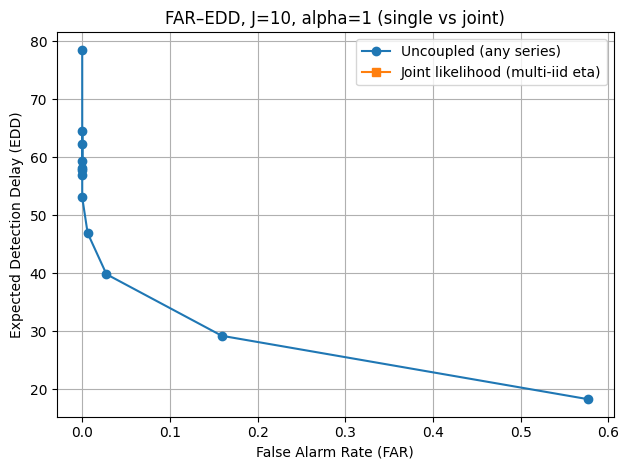

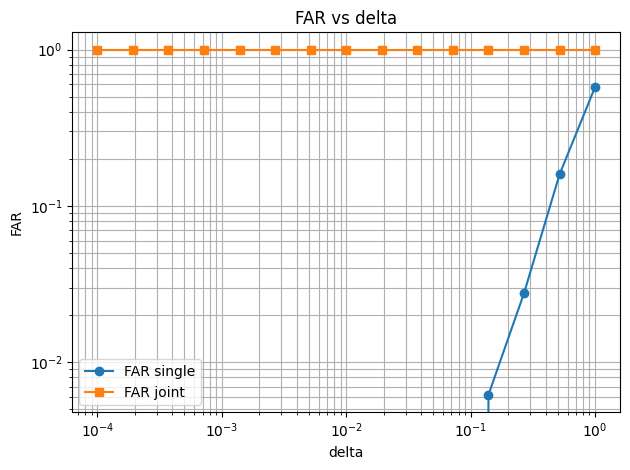

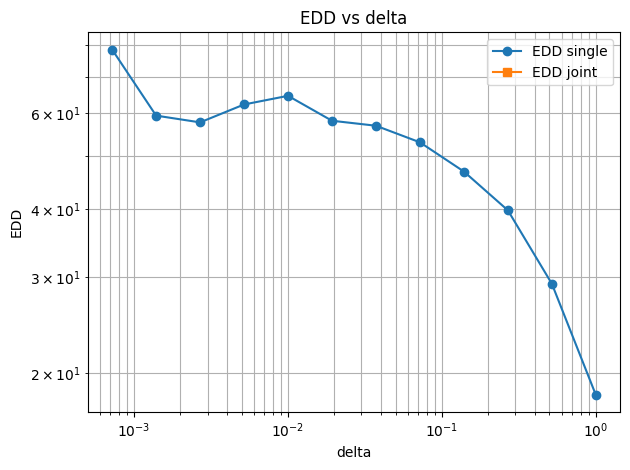

Saved results to far_edd_single_vs_joint_delta_sweep.csv


In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 10            # number of series (k)
T = 200           # horizon
t0 = 100          # changepoint
theta0 = 0.2      # pre-change Bernoulli parameter
theta1 = 0.4      # post-change parameter
num_changed = 10  # all series change
alpha = 1.0       # Beta prior
beta = 1.0
R = 500           # Monte Carlo runs

h = 0.0           # threshold in log e-process space
delta_grid = np.logspace(-4, 0, 15)  # sweep of deltas (adjust as you like)

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for ONE sequence.
    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def first_alarm_from_scores(S, h):
    """
    S: array shape (T+1, K). Alarm when any column >= h.
    Return first t, or np.nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def log_hazard_single(delta, T):
    """
    Single-series style hazard, alpha=1 approximation.

    Roughly: eta_t ~ delta^2 / [(t+1) log(t+1)]
    (we put an extra log for safety, same as your previous code)
    """
    t = np.arange(T + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(t + 1) + np.log(np.log(t + 1)))
    logeta[:2] = -np.inf  # disable t=0,1
    return logeta

def log_hazard_multi(delta, T, J):
    """
    Multi-iid hazard based on effective sample size N_t = J (t+1).

    eta_t^(k) ~ delta^2 / [(J(t+1)+1) log(J(t+1)+1)]   (alpha=1).
    """
    t = np.arange(T + 1)
    N_t = J * (t + 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(N_t + 1) + np.log(np.log(N_t + 1)))
    logeta[:2] = -np.inf
    return logeta

# ---------------------------
# Precompute A-values (per run)
# ---------------------------
run_data = []  # list of (A_single, A_joint)
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)

    # Per-series prefixes and A's
    prefix = np.zeros((J, T + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_single = np.zeros((T + 1, J))
    for j in range(J):
        A_single[:, j] = Amax_all_t(prefix[j], alpha, beta)

    # Joint series (flatten over J)
    prefix_joint = np.zeros(T + 1, dtype=int)
    prefix_joint[1:] = np.cumsum(Y.sum(axis=0))
    A_joint = Amax_all_t(prefix_joint, alpha, beta)

    run_data.append((A_single, A_joint))

# ---------------------------
# Delta sweep: single vs joint
# ---------------------------
rows = []

for delta in delta_grid:
    logeta_s = log_hazard_single(delta, T)
    logeta_m = log_hazard_multi(delta, T, J)

    alarms_single = []
    alarms_joint = []

    for (A_single, A_joint) in run_data:
        # Single-series detector: any series trips
        S_single = A_single + logeta_s[:, None]
        t_s = first_alarm_from_scores(S_single, h)
        alarms_single.append(t_s)

        # Joint detector: just one e-process from joint likelihood
        S_joint = A_joint + logeta_m
        t_m = first_alarm_from_scores(S_joint[:, None], h)
        alarms_joint.append(t_m)

    alarms_single = np.array(alarms_single)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_single, "single_series_any", delta))
    rows.append(summarize(alarms_joint, "joint_multi_iid", delta))

results = pd.DataFrame(rows)

# ---------------------------
# Plot FAR vs EDD curves
# ---------------------------
mask_single = results["detector"] == "single_series_any"
mask_joint = results["detector"] == "joint_multi_iid"

plt.figure()
plt.plot(results.loc[mask_single, "FAR"],
         results.loc[mask_single, "EDD"],
         marker="o", label="Uncoupled (any series)")
plt.plot(results.loc[mask_joint, "FAR"],
         results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood (multi-iid eta)")
plt.xlabel("False Alarm Rate (FAR)")
plt.ylabel("Expected Detection Delay (EDD)")
plt.title(f"FAR–EDD, J={J}, alpha=1 (single vs joint)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optionally: FAR / EDD vs delta
plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "FAR"],
           marker="o", label="FAR single")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "FAR"],
           marker="s", label="FAR joint")
plt.xlabel("delta")
plt.ylabel("FAR")
plt.title("FAR vs delta")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "EDD"],
           marker="o", label="EDD single")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "EDD"],
           marker="s", label="EDD joint")
plt.xlabel("delta")
plt.ylabel("EDD")
plt.title("EDD vs delta")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

# Save CSV if you want to inspect numerically
results.to_csv("far_edd_single_vs_joint_delta_sweep.csv", index=False)
print("Saved results to far_edd_single_vs_joint_delta_sweep.csv")

/var/folders/_b/28jfj19121qf32rdzd8twc000000gn/T/ipykernel_38959/310665341.py:74: RuntimeWarning: invalid value encountered in add
  vals = -L_1t[t-1] + L_1_sm1 + L_s_t


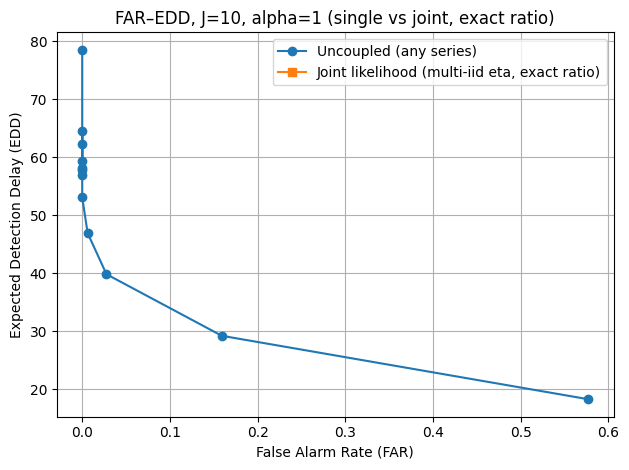

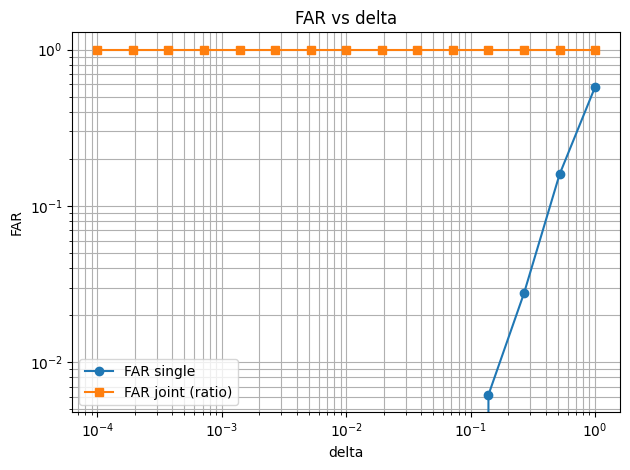

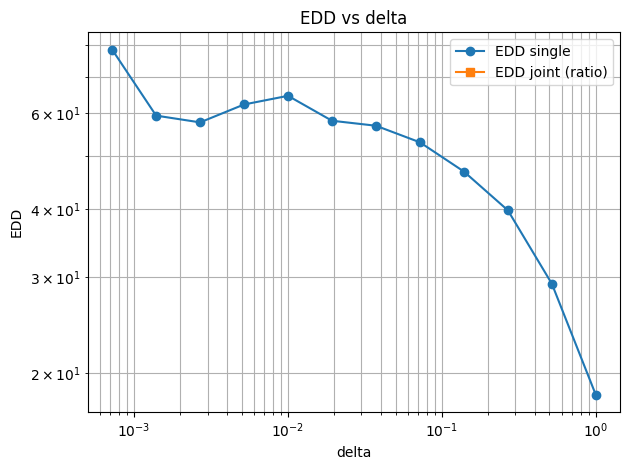

Saved results to far_edd_single_vs_joint_delta_sweep_ratio.csv


In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

# ==========================================
# Global RNG
# ==========================================
rng = np.random.default_rng(31415)

# ==========================================
# Experiment design
# ==========================================
J = 10            # number of series (k)
T = 200           # horizon
t0 = 100          # changepoint
theta0 = 0.2      # pre-change Bernoulli parameter
theta1 = 0.4      # post-change parameter
num_changed = 10  # all series change
alpha = 1.0       # Beta prior
beta = 1.0
R = 500           # Monte Carlo runs

h = 0.0           # threshold in log e-process space
delta_grid = np.logspace(-4, 0, 15)  # sweep of deltas

# ==========================================
# Helpers
# ==========================================
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for ONE sequence.
    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def first_alarm_from_scores(S, h):
    """
    S: array shape (T+1, K). Alarm when any column >= h.
    Return first t, or np.nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

def log_hazard_single(delta, T):
    """
    Single-series style hazard (alpha≈1):

    eta_t ~ delta^2 / [(t+1) log(t+1)]   (extra log in denominator via loglog)
    """
    t = np.arange(T + 1, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(t + 1.0) + np.log(np.log(t + 1.0)))
    logeta[:2] = -np.inf  # disable t=0,1
    return logeta

def log_hazard_multi_exact_ratio(delta, T, J):
    """
    Multi-iid hazard obtained from single-series hazard via the exact ratio:

        eta_t^(k) = eta_t^(1) * ((n+1)/(k n + 1)) * (log(4n)/log(4k n))

    where n = t+1 is the effective sample size for the single-series case,
    and k = J is the number of iid series.
    """
    t = np.arange(T + 1, dtype=float)
    logeta_single = log_hazard_single(delta, T)   # shape (T+1,)

    # n = t+1 (number of observations up to time t)
    n = t + 1.0
    n_clipped = np.maximum(n, 1.0)  # avoid zeros

    # ratio = ((n+1)/(k n + 1)) * (log(4n)/log(4k n))
    k = float(J)
    num1 = n_clipped + 1.0
    den1 = k * n_clipped + 1.0
    frac1 = num1 / den1

    num2 = np.log(4.0 * n_clipped)
    den2 = np.log(4.0 * k * n_clipped)
    frac2 = num2 / den2

    ratio = frac1 * frac2

    # numerical safety: enforce 0 < ratio <= 1
    ratio = np.clip(ratio, 1e-12, 1.0)

    logeta_multi = logeta_single + np.log(ratio) + np.log(1/J)
    logeta_multi[:2] = -np.inf
    return logeta_multi

# ==========================================
# Precompute A-values for all runs
# ==========================================
run_data = []  # list of (A_single, A_joint)
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)

    # Per-series prefixes and A's
    prefix = np.zeros((J, T + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_single = np.zeros((T + 1, J))
    for j in range(J):
        A_single[:, j] = Amax_all_t(prefix[j], alpha, beta)

    # Joint series (flatten over J)
    prefix_joint = np.zeros(T + 1, dtype=int)
    prefix_joint[1:] = np.cumsum(Y.sum(axis=0))
    A_joint = Amax_all_t(prefix_joint, alpha, beta)

    run_data.append((A_single, A_joint))

# ==========================================
# Delta sweep: single vs joint (multi-iid)
# ==========================================
rows = []

for delta in delta_grid:
    logeta_s = log_hazard_single(delta, T)
    logeta_m = log_hazard_multi_exact_ratio(delta, T, J)

    alarms_single = []
    alarms_joint = []

    for (A_single, A_joint) in run_data:
        # Uncoupled detector: any of the J series
        S_single = A_single + logeta_s[:, None]
        t_s = first_alarm_from_scores(S_single, h)
        alarms_single.append(t_s)

        # Joint detector: one e-process from joint likelihood
        S_joint = A_joint + logeta_m
        t_m = first_alarm_from_scores(S_joint[:, None], h)
        alarms_joint.append(t_m)

    alarms_single = np.array(alarms_single)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_single, "single_series_any", delta))
    rows.append(summarize(alarms_joint, "joint_multi_iid_ratio", delta))

results = pd.DataFrame(rows)

# ==========================================
# FAR–EDD curves
# ==========================================
mask_single = results["detector"] == "single_series_any"
mask_joint = results["detector"] == "joint_multi_iid_ratio"

plt.figure()
plt.plot(results.loc[mask_single, "FAR"],
         results.loc[mask_single, "EDD"],
         marker="o", label="Uncoupled (any series)")
plt.plot(results.loc[mask_joint, "FAR"],
         results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood (multi-iid eta, exact ratio)")
plt.xlabel("False Alarm Rate (FAR)")
plt.ylabel("Expected Detection Delay (EDD)")
plt.title(f"FAR–EDD, J={J}, alpha=1 (single vs joint, exact ratio)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# FAR vs delta
plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "FAR"],
           marker="o", label="FAR single")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "FAR"],
           marker="s", label="FAR joint (ratio)")
plt.xlabel("delta")
plt.ylabel("FAR")
plt.title("FAR vs delta")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

# EDD vs delta
plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "EDD"],
           marker="o", label="EDD single")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "EDD"],
           marker="s", label="EDD joint (ratio)")
plt.xlabel("delta")
plt.ylabel("EDD")
plt.title("EDD vs delta")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

# Save CSV if useful
results.to_csv("far_edd_single_vs_joint_delta_sweep_ratio.csv", index=False)
print("Saved results to far_edd_single_vs_joint_delta_sweep_ratio.csv")

Estimated tau (ESS, median over runs): 11.549
Data-optimal tau (multi-iid eta) at FAR<=baseline: 17.818  (EDD=8.484)


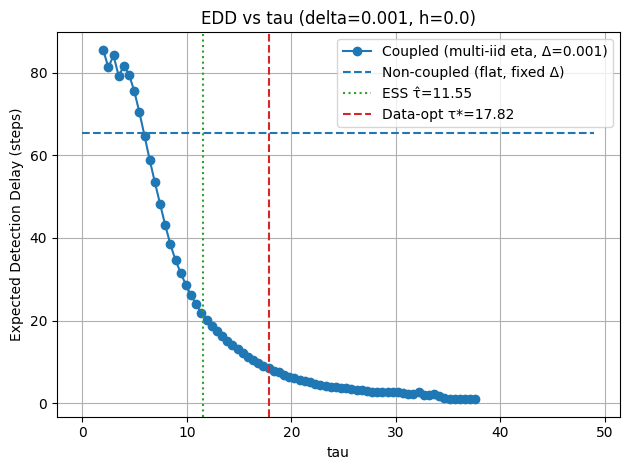

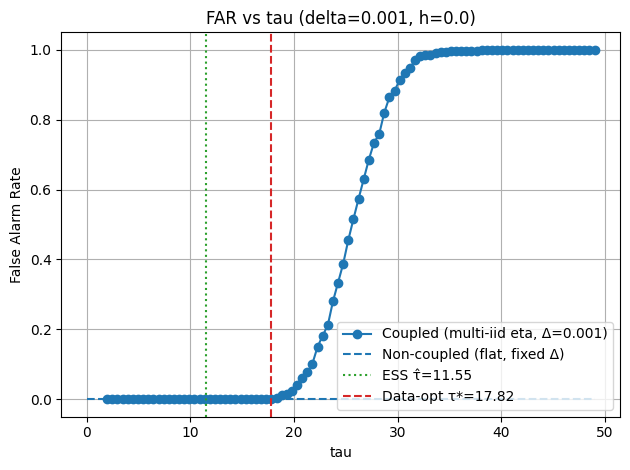

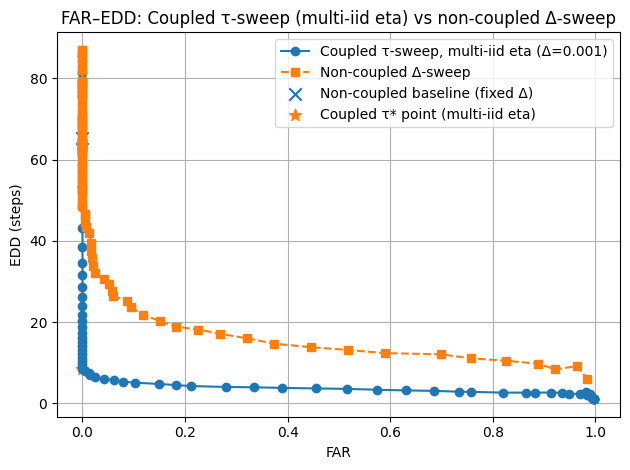

Tau sweep CSV:   tau_sweep_multi_iid_eta_delta_0.001000.csv
Delta sweep CSV: delta_sweep_noncoupled.csv


In [206]:
 import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 50
T = 200
t0 = 100
theta0 = 0.2
theta1 = 0.4
num_changed = 40          # < J for selective coupling
pi = 1/1000
rho = 0.8
alpha = 1.0
beta = 1.0
h = 0.0
R = 500

# Coupled experiment: fix delta, sweep tau
delta_fixed = 0.001
N_TAU = 100
tau_grid = np.linspace(0.0, J-1, N_TAU)  # [0, J-1] : no coupling -> full product LR

# Non-coupled experiment: fix tau=0, sweep delta
delta_grid = np.logspace(-4, 0, 100)     # adjust as you like

# Allow damping? If False, negative A's are clipped to 0 (only boosting)
CLIP_NEG_BF = False

# ---------------------------
# Helpers
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for ONE series.
    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_tau_invariants(Y, alpha, beta, pi, rho, clip_neg_bf=True):
    """
    For a J x T panel Y, precompute:
      - A_vals[t,j]: per-series log-evidence (Amax)
      - logGM_excl[t,j]: leave-one-out log geometric mean of X_k(t)
      - logs: (log1mp, logp) for mixing with prior pi
      - u_pre[t,j]: log X_j(t) for t <= t0 (pre-change), used for tau estimation
    """
    J, Tlen = Y.shape

    # Cumulative sums per series
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    # A_vals[t,j] = Amax for each series
    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    log1mp, logp = np.log(1 - pi), np.log(pi)

    logGM_excl = np.full((Tlen + 1, J), -np.inf, dtype=float)
    # u_all[t,j] = log X_j(t)
    u_all = np.full((Tlen + 1, J), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        logBF = A_vals[t, :]
        if clip_neg_bf:
            logBF = np.maximum(logBF, 0.0)  # BF >= 1
        # X_j(t) = (1-ρ) + ρ * BF_j(t)
        logX = np.logaddexp(np.log1p(-rho), np.log(rho) + logBF)
        u_all[t, :] = logX

        # leave-one-out average of log X
        sum_logX = np.sum(logX)
        logGM_excl[t, :] = (sum_logX - logX) / (J - 1)

    # Pre-change part (t <= t0) for tau ESS estimation
    u_pre = u_all[2:t0+1, :].copy()
    return A_vals, logGM_excl, (log1mp, logp), u_pre

def estimate_tau_ess_from_u(u_pre):
    """
    ESS-based tau: n_eff = vbar / Var_t(mean_k u_k(t)).
    u_pre: array shape (Tpre, J) with u_k(t)=log X_k(t) for pre-change times.
    """
    if u_pre.size == 0:
        return 0.0
    # variance over time for each series
    var_k = np.var(u_pre, axis=0, ddof=1)
    vbar = float(np.mean(var_k))
    # average across series at each time; then variance over time
    u_bar_t = np.mean(u_pre, axis=1)
    var_w = float(np.var(u_bar_t, ddof=1))
    if vbar <= 0 or var_w <= 0:
        return 0.0
    n_eff = vbar / var_w
    # clamp to [0, J-1]
    J_here = u_pre.shape[1]
    n_eff = max(0.0, min(n_eff, J_here - 1.0))
    return n_eff

def first_alarm_from_scores(S):
    """
    S: array shape (T+1, J) of scores S[t,j].
    Return first t where any S[t,j] >= h, or nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

# ---------------------------
# Hazards (single vs multi-iid exact ratio)
# ---------------------------
def log_hazard_single(delta, Tlen):
    """
    Single-series style hazard (alpha≈1):

    eta_t ~ delta^2 / [(t+1) log(t+1)] with an extra loglog term.
    """
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(n) + np.log(np.log(n)))
    logeta[:2] = -np.inf  # disable t=0,1
    return logeta

def log_hazard_multi_exact_ratio(delta, Tlen, J):
    """
    Multi-iid hazard from the exact ratio:

        eta_t^(k) = eta_t^(1) * ((n+1)/(k n + 1)) * (log(4n)/log(4k n))

    where n = t+1, k = J.
    """
    logeta_single = log_hazard_single(delta, Tlen)
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    n_clipped = np.maximum(n, 1.0)

    k = float(J)
    num1 = n_clipped + 1.0
    den1 = k * n_clipped + 1.0
    frac1 = num1 / den1

    num2 = np.log(4.0 * n_clipped)
    den2 = np.log(4.0 * k * n_clipped)
    frac2 = num2 / den2

    ratio = frac1 * frac2
    ratio = np.clip(ratio, 1e-12, 1.0)   # 0 < ratio <= 1

    logeta_multi = logeta_single + np.log(ratio)
    logeta_multi[:2] = -np.inf
    return logeta_multi

# ---------------------------
# Alarm functions using hazards
# ---------------------------
def alarms_for_tau(A_vals, logGM_excl, logs, delta, tau):
    """
    For fixed tau, build logΛ(t,j) and hazard schedules, then return:
        (t_alarm_coupled, t_alarm_noncoupled).

    - Non-coupled hazard:   uses single-series η_n(t)
    - Coupled (multi-iid):  uses multi-iid η_N(t) with N = J (t+1), via exact ratio.
    """
    log1mp, logp = logs
    Tlen, J_here = A_vals.shape[0]-1, A_vals.shape[1]

    # hazards
    logeta_nc = log_hazard_single(delta, Tlen)             # original, n = t+1
    logeta_c  = log_hazard_multi_exact_ratio(delta, Tlen, J_here)  # new multi-iid

    # coupling for this tau
    logLambda = np.zeros_like(A_vals)
    logLambda[2:, :] = np.logaddexp(log1mp, logp + tau * logGM_excl[2:, :])

    # Scores
    S_c = A_vals + logLambda + logeta_c[:, None]   # coupled: multi-iid hazard
    S_n = A_vals + logeta_nc[:, None]              # non-coupled: single hazard

    return first_alarm_from_scores(S_c), first_alarm_from_scores(S_n)

def alarm_noncoupled_delta(A_vals, delta, h):
    """
    Non-coupled detector with arbitrary delta.
    Uses the original single-series hazard (in n = t+1).
    """
    Tlen = A_vals.shape[0] - 1
    logeta = log_hazard_single(delta, Tlen)

    S_n = A_vals + logeta[:, None]
    return first_alarm_from_scores(S_n)

# ---------------------------
# Simulate R runs; precompute invariants and tau-hat per run
# ---------------------------
precomp_list = []
tau_hat_runs = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, logGM_excl, logs, u_pre = precompute_tau_invariants(
        Y, alpha, beta, pi, rho, clip_neg_bf=CLIP_NEG_BF
    )
    tau_hat_r = estimate_tau_ess_from_u(u_pre)
    tau_hat_runs.append(tau_hat_r)
    precomp_list.append((A_vals, logGM_excl, logs))

tau_hat_ESS = float(np.median(tau_hat_runs))
print(f"Estimated tau (ESS, median over runs): {tau_hat_ESS:.3f}")

# ---------------------------
# Sweep tau (coupled) at fixed delta
# ---------------------------
rows = []
for tau in tau_grid:
    alarms_c = []
    alarms_n = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_c, t_n = alarms_for_tau(A_vals, logGM_excl, logs, delta_fixed, tau)
        alarms_c.append(t_c)
        alarms_n.append(t_n)

    alarms_c = np.array(alarms_c)
    alarms_n = np.array(alarms_n)

    def summarize(alarm_times, label, tau_val, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
            dd = np.array([])
        return {
            "detector": label,
            "tau": tau_val,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
            "n_post": int(dd.size),
        }

    rows.append(summarize(alarms_c, "coupled_tempered_multi_iid_eta", tau, delta_fixed))
    rows.append(summarize(alarms_n, "noncoupled_fixed_delta", tau, delta_fixed))

results = pd.DataFrame(rows)

# ---------------------------
# Data-optimal tau at target FAR (non-coupled baseline, fixed delta)
# ---------------------------
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")
far_baseline = results.loc[mask_n_fixed, "FAR"].iloc[0]

coupled = results[results["detector"] == "coupled_tempered_multi_iid_eta"].copy()
tol = 1e-12
feasible = coupled[coupled["FAR"] <= far_baseline + tol]
if not feasible.empty:
    idx_best = feasible["EDD"].idxmin()
    tau_star = float(feasible.loc[idx_best, "tau"])
    edd_star = float(feasible.loc[idx_best, "EDD"])
else:
    tau_star = np.nan
    edd_star = np.nan

print(f"Data-optimal tau (multi-iid eta) at FAR<=baseline: {tau_star:.3f}  (EDD={edd_star:.3f})")

# ---------------------------
# Extra experiment: delta-sweep for NON-COUPLED detector
# ---------------------------
rows_delta = []
for delta_nc in delta_grid:
    alarms_nc = []
    for (A_vals, logGM_excl, logs) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta_nc, h)
        alarms_nc.append(t_nc)

    alarms_nc = np.array(alarms_nc)

    finite = np.isfinite(alarms_nc)
    at = alarms_nc[finite]
    if at.size > 0:
        far = float(np.mean(at < t0))
        dd = at[at >= t0] - t0
        edd = float(np.mean(dd)) if dd.size > 0 else np.nan
        edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
    else:
        far = np.nan
        edd = np.nan
        edd_med = np.nan
        dd = np.array([])

    rows_delta.append({
        "detector": "noncoupled_delta_sweep",
        "tau": 0.0,
        "delta": delta_nc,
        "FAR": far,
        "EDD": edd,
        "EDD_median": edd_med,
        "n_runs": int(at.size),
        "n_post": int(dd.size),
    })

results_delta = pd.DataFrame(rows_delta)

# Combine for plotting
results_all = pd.concat([results, results_delta], ignore_index=True)

# ---------------------------
# Plots: EDD vs tau and FAR vs tau (coupled, fixed delta)
# ---------------------------
mask_c = (results["detector"] == "coupled_tempered_multi_iid_eta")
mask_n_fixed = (results["detector"] == "noncoupled_fixed_delta")

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "EDD"],
         marker="o", label=f"Coupled (multi-iid eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "EDD"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("Expected Detection Delay (steps)")
plt.title(f"EDD vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(results.loc[mask_c, "tau"], results.loc[mask_c, "FAR"],
         marker="o", label=f"Coupled (multi-iid eta, Δ={delta_fixed})")
plt.hlines(y=results.loc[mask_n_fixed, "FAR"].iloc[0],
           xmin=tau_grid.min(), xmax=tau_grid.max(),
           linestyles="--", label="Non-coupled (flat, fixed Δ)")
plt.axvline(tau_hat_ESS, color="tab:green", linestyle=":",
            label=f"ESS τ̂={tau_hat_ESS:.2f}")
if np.isfinite(tau_star):
    plt.axvline(tau_star, color="tab:red", linestyle="--",
                label=f"Data-opt τ*={tau_star:.2f}")
plt.xlabel("tau")
plt.ylabel("False Alarm Rate")
plt.title(f"FAR vs tau (delta={delta_fixed}, h={h})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# FAR–EDD parametric curves: coupled τ-sweep vs non-coupled Δ-sweep
# ---------------------------
mask_c_all = (results_all["detector"] == "coupled_tempered_multi_iid_eta")
mask_n_delta = (results_all["detector"] == "noncoupled_delta_sweep")

plt.figure()
plt.plot(results_all.loc[mask_c_all, "FAR"],
         results_all.loc[mask_c_all, "EDD"],
         marker="o", label=f"Coupled τ-sweep, multi-iid eta (Δ={delta_fixed:.3g})")

plt.plot(results_all.loc[mask_n_delta, "FAR"],
         results_all.loc[mask_n_delta, "EDD"],
         marker="s", linestyle="--",
         label="Non-coupled Δ-sweep")

# mark the fixed-delta non-coupled baseline
plt.scatter(results.loc[mask_n_fixed, "FAR"].iloc[0],
            results.loc[mask_n_fixed, "EDD"].iloc[0],
            marker="x", s=80, label="Non-coupled baseline (fixed Δ)")

# mark τ* if available
if np.isfinite(tau_star):
    row_star = coupled.loc[idx_best]
    plt.scatter(row_star["FAR"], row_star["EDD"],
                s=80, marker="*", label="Coupled τ* point (multi-iid eta)")

plt.xlabel("FAR")
plt.ylabel("EDD (steps)")
plt.title("FAR–EDD: Coupled τ-sweep (multi-iid eta) vs non-coupled Δ-sweep")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Save CSVs
# ---------------------------
out_path_tau = f"tau_sweep_multi_iid_eta_delta_{delta_fixed:.6f}.csv"
out_path_delta = "delta_sweep_noncoupled.csv"
results.to_csv(out_path_tau, index=False)
results_delta.to_csv(out_path_delta, index=False)
print(f"Tau sweep CSV:   {out_path_tau}")
print(f"Delta sweep CSV: {out_path_delta}")

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(31415)

# ---------------------------------
# Experiment setup (TRUE NULL)
# ---------------------------------
J = 10          # number of series in joint / multi-iid case
T = 200         # time horizon
theta0 = 0.2    # Bernoulli parameter under null
R = 500         # Monte Carlo runs
r = 1           # restart point fixed at 1

# Eta parameters from theorem
alpha_eta = 2.0           # must be > 1 in the theorem; pick something simple
delta_grid = np.logspace(-4, -1, 8)   # e.g. 1e-4,...,1e-1

# ---------------------------------
# Lemma 4: Lhat for Bernoulli block
# \hat L_{s:t} = log(n+1) + n log n - m log m - (n-m) log(n-m)
# with convention 0*log(0) = 0
# ---------------------------------
def Lhat_block(n, m):
    """
    n: block length (scalar or array)
    m: number of ones in block
    returns \hat L for each (n,m)
    """
    n = np.asarray(n, dtype=float)
    m = np.asarray(m, dtype=float)
    n_bar = n - m

    out = np.log(n + 1.0) + n * np.log(n)

    # 0 log 0 treated as 0
    with np.errstate(divide='ignore', invalid='ignore'):
        mask_m = m > 0
        out[mask_m] -= m[mask_m] * np.log(m[mask_m])

        mask_nb = n_bar > 0
        out[mask_nb] -= n_bar[mask_nb] * np.log(n_bar[mask_nb])

    return out

# ---------------------------------
# Theorem 2: single-series eta_{r,s,t}
# final simplified bound (Alami) for r=1:
#
# eta_{1,s,t} <
#   sqrt(n_{1:s-1} n_{s:t}) / (10 (n_{1:t}+1)) *
#   [ log(4 alpha+2) delta^2 / (4 n_{1:t} log((alpha+3) n_{1:t})) ]^{alpha}
#
# We will treat this as our definition of eta.
# ---------------------------------
def eta_single(r, s, t, delta, alpha):
    """
    r fixed to 1 in our experiment.
    s, t integers with 1 < s <= t.
    """
    n_rs1 = s - r          # n_{r:s-1} = s-1
    n_st  = t - s + 1      # n_{s:t}
    n_rt  = t - r + 1      # n_{r:t} = t

    n_rs1 = float(n_rs1)
    n_st  = float(n_st)
    n_rt  = float(n_rt)

    # guard: if any length < 1, return very large eta (no alarm)
    if n_rs1 < 1 or n_st < 1 or n_rt < 1:
        return 1.0

    num_sqrt = np.sqrt(n_rs1 * n_st)
    den_sqrt = 10.0 * (n_rt + 1.0)

    c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
    c_den = 4.0 * n_rt * np.log((alpha + 3.0) * n_rt)

    # if c_den <= 0 (shouldn't happen for n_rt>=1, alpha>1), just return 1
    if c_den <= 0:
        return 1.0

    inner = c_num / c_den
    if inner <= 0:
        return 1.0

    return (num_sqrt / den_sqrt) * (inner ** alpha)

# ---------------------------------
# Multi-iid version: replace n_{·} by N_{·} = J * n_{·}
# ---------------------------------
def eta_multi(r, s, t, delta, alpha, J):
    n_rs1 = s - r          # n_{r:s-1}
    n_st  = t - s + 1      # n_{s:t}
    n_rt  = t - r + 1      # n_{r:t}

    N_rs1 = J * n_rs1
    N_st  = J * n_st
    N_rt  = J * n_rt

    N_rs1 = float(N_rs1)
    N_st  = float(N_st)
    N_rt  = float(N_rt)

    if N_rs1 < 1 or N_st < 1 or N_rt < 1:
        return 1.0

    num_sqrt = np.sqrt(N_rs1 * N_st)
    den_sqrt = 10.0 * (N_rt + 1.0)

    c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
    c_den = 4.0 * N_rt * np.log((alpha + 3.0) * N_rt)

    if c_den <= 0:
        return 1.0

    inner = c_num / c_den
    if inner <= 0:
        return 1.0

    return (num_sqrt / den_sqrt) * (inner ** alpha)

# ---------------------------------
# Precompute log-etas (single & multi) for all (s,t) and deltas
# r = 1 fixed
# ---------------------------------
def precompute_logeta_single(T, delta_grid, alpha):
    logeta_dict = {}
    for delta in delta_grid:
        logeta = np.full((T + 1, T + 1), -np.inf, dtype=float)
        for t in range(2, T + 1):
            for s in range(2, t + 1):
                e = eta_single(1, s, t, delta, alpha)
                # avoid log(0)
                if e > 0:
                    logeta[t, s] = np.log(e)
        logeta_dict[delta] = logeta
    return logeta_dict

def precompute_logeta_multi(T, delta_grid, alpha, J):
    logeta_dict = {}
    for delta in delta_grid:
        logeta = np.full((T + 1, T + 1), -np.inf, dtype=float)
        for t in range(2, T + 1):
            for s in range(2, t + 1):
                e = eta_multi(1, s, t, delta, alpha, J)
                if e > 0:
                    logeta[t, s] = np.log(e)
        logeta_dict[delta] = logeta
    return logeta_dict

logeta_single_dict = precompute_logeta_single(T, delta_grid, alpha_eta)
logeta_multi_dict  = precompute_logeta_multi(T, delta_grid, alpha_eta, J)

# ---------------------------------
# One-run: compute D_{s,t} = Lhat_{1:t} - Lhat_{1:s-1} - Lhat_{s:t}
# for single and joint, under true null
# ---------------------------------
def compute_D_single(y):
    """
    y: length-T Bernoulli(θ0) sequence (true null).
    returns D_single[t,s] for t>=2,s in [2,t].
    """
    Tlen = len(y)
    prefix = np.zeros(Tlen + 1, dtype=int)
    prefix[1:] = np.cumsum(y)

    # Lhat_{1:t}
    L1 = np.zeros(Tlen + 1)
    for t in range(1, Tlen + 1):
        n = t
        m = prefix[t]
        L1[t] = Lhat_block(np.array([n]), np.array([m]))[0]

    # D[t,s]
    D = np.full((Tlen + 1, Tlen + 1), -np.inf, dtype=float)
    for t in range(2, Tlen + 1):
        for s in range(2, t + 1):
            n_st = t - s + 1
            m_st = prefix[t] - prefix[s - 1]
            L_st = Lhat_block(np.array([n_st]), np.array([m_st]))[0]
            D[t, s] = L1[t] - L1[s - 1] - L_st
    return D

def compute_D_joint(Y):
    """
    Y: J x T panel under true null.
    We aggregate across J and treat as one joint sequence of counts.
    """
    J, Tlen = Y.shape
    total = Y.sum(axis=0)  # length T, Bin(J,θ0) per time
    prefix = np.zeros(Tlen + 1, dtype=int)
    prefix[1:] = np.cumsum(total)

    # Lhat_{1:t} with N_t = J * t and M_t = prefix[t]
    L1 = np.zeros(Tlen + 1)
    for t in range(1, Tlen + 1):
        n = J * t
        m = prefix[t]
        L1[t] = Lhat_block(np.array([n]), np.array([m]))[0]

    D = np.full((Tlen + 1, Tlen + 1), -np.inf, dtype=float)
    for t in range(2, Tlen + 1):
        for s in range(2, t + 1):
            n_st = J * (t - s + 1)
            m_st = prefix[t] - prefix[s - 1]
            L_st = Lhat_block(np.array([n_st]), np.array([m_st]))[0]
            D[t, s] = L1[t] - L1[s - 1] - L_st
    return D

# ---------------------------------
# Given D[t,s] and logeta[t,s](delta), find earliest alarm time
# condition: exists s in (1,t] s.t. D[t,s] >= -log eta_{1,s,t}
# i.e. D[t,s] + logeta[t,s] >= 0
# ---------------------------------
def alarm_time_from_D(D, logeta, h=0.0):
    Tlen = D.shape[0] - 1
    for t in range(2, Tlen + 1):
        # we only care about s<=t
        vals = D[t, 2:t+1] + logeta[t, 2:t+1]
        if np.any(vals >= h):
            return float(t)
    return np.nan  # no alarm up to T

# ---------------------------------
# Monte Carlo under TRUE NULL
# FAR(δ) = P(alarm <= T)
# ---------------------------------
rows = []

for delta in delta_grid:
    logeta_s = logeta_single_dict[delta]
    logeta_m = logeta_multi_dict[delta]

    alarms_single = []
    alarms_joint = []

    for r_idx in range(R):
        # simulate true null panel
        Y = rng.binomial(1, theta0, size=(J, T))

        # single: only one series (say j=0)
        y_single = Y[0, :]
        D_single = compute_D_single(y_single)
        t_alarm_s = alarm_time_from_D(D_single, logeta_s, h=0.0)
        alarms_single.append(t_alarm_s)

        # joint: aggregated across J
        D_joint = compute_D_joint(Y)
        t_alarm_m = alarm_time_from_D(D_joint, logeta_m, h=0.0)
        alarms_joint.append(t_alarm_m)

    alarms_single = np.array(alarms_single)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at <= T))  # alarm at or before T under null
        else:
            far = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_single, "single_series", delta))
    rows.append(summarize(alarms_joint, "joint_multi_iid", delta))

results = pd.DataFrame(rows)

print(results)

# ---------------------------------
# Plot FAR vs delta
# ---------------------------------
mask_single = results["detector"] == "single_series"
mask_joint  = results["detector"] == "joint_multi_iid"

plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "FAR"],
           marker="o", label="Single series")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "FAR"],
           marker="s", label="Joint multi-iid")
plt.xlabel("delta")
plt.ylabel("FAR (true null)")
plt.title(f"FAR vs delta, T={T}, J={J}, alpha={alpha_eta}")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

          detector  delta  FAR  n_runs
0    single_series    0.5  NaN       0
1  joint_multi_iid    0.5  NaN       0
2    single_series    1.0  NaN       0
3  joint_multi_iid    1.0  NaN       0


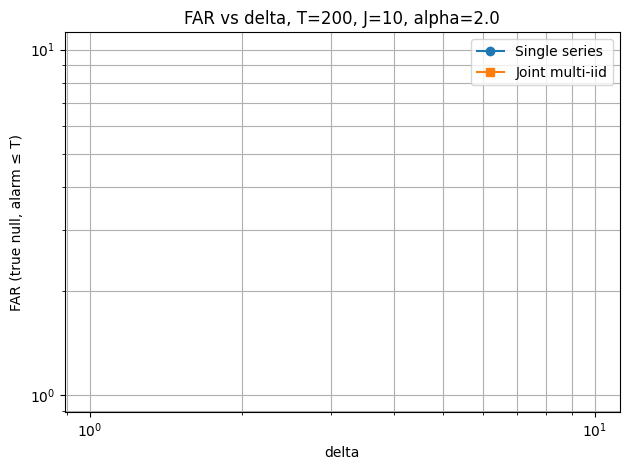

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# Global RNG
# ==========================================
rng = np.random.default_rng(31415)

# ==========================================
# Experiment setup (TRUE NULL)
# ==========================================
J = 10          # number of series in joint / multi-iid case
T = 200         # time horizon
theta0 = 0.2    # Bernoulli parameter under null
R = 500         # Monte Carlo runs
r = 1           # restart index (fixed at 1)

# Eta parameters from theorem (must have alpha > 1)
alpha_eta = 2.0
delta_grid = np.linspace(0.5, 1, 2)   # e.g. 1e-4,...,1e-1

# ==========================================
# Lemma 4: Lhat for Bernoulli block
# L̂_{s:t} = log(n+1) + n log n - m log m - (n-m) log(n-m)
# with convention 0*log(0) = 0
# ==========================================
def Lhat_block(n, m):
    """
    n: array-like of block lengths
    m: array-like of number of ones in block
    returns array of Lhat values
    """
    n = np.asarray(n, dtype=float)
    m = np.asarray(m, dtype=float)
    n_bar = n - m

    out = np.log(n + 1.0) + n * np.log(n)

    with np.errstate(divide='ignore', invalid='ignore'):
        mask_m = m > 0
        out[mask_m] -= m[mask_m] * np.log(m[mask_m])

        mask_nb = n_bar > 0
        out[mask_nb] -= n_bar[mask_nb] * np.log(n_bar[mask_nb])

    return out

# ==========================================
# Theorem 2: single-series eta_{1,s,t}
# Simplified sufficient bound (Alami) for r=1:
#
# eta_{1,s,t} <
#   sqrt(n_{1:s-1} n_{s:t}) / (10 (n_{1:t}+1)) *
#   [ log(4 alpha+2) delta^2 / (4 n_{1:t} log((alpha+3) n_{1:t})) ]^{alpha}
#
# We take this as definition of eta (clipped for numerical safety).
# ==========================================
def eta_single(r, s, t, delta, alpha):
    n_rs1 = s - r          # n_{r:s-1} = s-1
    n_st  = t - s + 1      # n_{s:t}
    n_rt  = t - r + 1      # n_{r:t} = t

    n_rs1 = float(n_rs1)
    n_st  = float(n_st)
    n_rt  = float(n_rt)

    if n_rs1 < 1 or n_st < 1 or n_rt < 1:
        return 1.0

    num_sqrt = np.sqrt(n_rs1 * n_st)
    den_sqrt = 10.0 * (n_rt + 1.0)

    c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
    c_den = 4.0 * n_rt * np.log((alpha + 3.0) * n_rt)

    if c_den <= 0:
        return 1.0

    inner = c_num / c_den
    if inner <= 0:
        return 1.0

    return (num_sqrt / den_sqrt) * (inner ** alpha)

def eta_multi(r, s, t, delta, alpha, J):
    """
    Multi-iid version: replace n_{·} by N_{·} = J * n_{·}.
    """
    n_rs1 = s - r
    n_st  = t - s + 1
    n_rt  = t - r + 1

    N_rs1 = J * n_rs1
    N_st  = J * n_st
    N_rt  = J * n_rt

    N_rs1 = float(N_rs1)
    N_st  = float(N_st)
    N_rt  = float(N_rt)

    if N_rs1 < 1 or N_st < 1 or N_rt < 1:
        return 1.0

    num_sqrt = np.sqrt(N_rs1 * N_st)
    den_sqrt = 10.0 * (N_rt + 1.0)

    c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
    c_den = 4.0 * N_rt * np.log((alpha + 3.0) * N_rt)

    if c_den <= 0:
        return 1.0

    inner = c_num / c_den
    if inner <= 0:
        return 1.0

    return (num_sqrt / den_sqrt) * (inner ** alpha)

# ==========================================
# Precompute log-eta_{1,s,t} for all (s,t) and deltas (vectorized over s)
# ==========================================
def precompute_logeta_single(T, delta_grid, alpha):
    logeta_dict = {}
    for delta in delta_grid:
        logeta = np.full((T + 1, T + 1), -np.inf, dtype=float)
        for t in range(2, T + 1):
            s = np.arange(2, t + 1, dtype=int)  # vector of s
            n_rs1 = s - r            # n_{1:s-1}
            n_st  = t - s + 1        # n_{s:t}
            n_rt  = t - r + 1        # n_{1:t} = t

            num_sqrt = np.sqrt(n_rs1 * n_st)
            den_sqrt = 10.0 * (n_rt + 1.0)

            c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
            c_den = 4.0 * n_rt * np.log((alpha + 3.0) * n_rt)

            inner = c_num / c_den
            inner = max(inner, 1e-300)  # numerical safety

            eta_vec = (num_sqrt / den_sqrt) * (inner ** alpha)
            # clip extremely small values
            eta_vec = np.clip(eta_vec, 1e-300, 1.0)

            logeta[t, s] = np.log(eta_vec)
        logeta_dict[delta] = logeta
    return logeta_dict

def precompute_logeta_multi(T, delta_grid, alpha, J):
    logeta_dict = {}
    for delta in delta_grid:
        logeta = np.full((T + 1, T + 1), -np.inf, dtype=float)
        for t in range(2, T + 1):
            s = np.arange(2, t + 1, dtype=int)

            n_rs1 = s - r
            n_st  = t - s + 1
            n_rt  = t - r + 1

            N_rs1 = J * n_rs1
            N_st  = J * n_st
            N_rt  = J * n_rt

            num_sqrt = np.sqrt(N_rs1 * N_st)
            den_sqrt = 10.0 * (N_rt + 1.0)

            c_num = np.log(4.0 * alpha + 2.0) * (delta ** 2)
            c_den = 4.0 * N_rt * np.log((alpha + 3.0) * N_rt)

            inner = c_num / c_den
            inner = np.maximum(inner, 1e-300)

            eta_vec = (num_sqrt / den_sqrt) * (inner ** alpha)
            eta_vec = np.clip(eta_vec, 1e-300, 1.0)

            logeta[t, s] = np.log(eta_vec)
        logeta_dict[delta] = logeta
    return logeta_dict

logeta_single_dict = precompute_logeta_single(T, delta_grid, alpha_eta)
logeta_multi_dict  = precompute_logeta_multi(T, delta_grid, alpha_eta, J)

# ==========================================
# Vectorized computation of D_{t,s}
# D_{t,s} = Lhat_{1:t} - Lhat_{1:s-1} - Lhat_{s:t}
# ==========================================
def compute_D_single_fast(y):
    """
    y: length-T Bernoulli(θ0) sequence (true null).
    returns D_single[t,s] for t>=2,s in [2,t].
    """
    Tlen = len(y)
    prefix = np.zeros(Tlen + 1, dtype=int)
    prefix[1:] = np.cumsum(y)

    # Lhat_{1:t} for all t (vectorized via loop over t but single call per t)
    L1 = np.zeros(Tlen + 1)
    for t in range(1, Tlen + 1):
        n = np.array([t])
        m = np.array([prefix[t]])
        L1[t] = Lhat_block(n, m)[0]

    D = np.full((Tlen + 1, Tlen + 1), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        n_st = t - s + 1
        m_st = prefix[t] - prefix[s - 1]
        L_st = Lhat_block(n_st, m_st)
        D[t, s] = L1[t] - L1[s - 1] - L_st

    return D

def compute_D_joint_fast(Y):
    """
    Y: J x T panel under true null.
    We aggregate across J and treat as one joint sequence of counts.
    """
    J_here, Tlen = Y.shape
    total = Y.sum(axis=0)  # length T, Bin(J,θ0) per time
    prefix = np.zeros(Tlen + 1, dtype=int)
    prefix[1:] = np.cumsum(total)

    L1 = np.zeros(Tlen + 1)
    for t in range(1, Tlen + 1):
        n = np.array([J_here * t])
        m = np.array([prefix[t]])
        L1[t] = Lhat_block(n, m)[0]

    D = np.full((Tlen + 1, Tlen + 1), -np.inf, dtype=float)

    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)
        n_st = J_here * (t - s + 1)
        m_st = prefix[t] - prefix[s - 1]
        L_st = Lhat_block(n_st, m_st)
        D[t, s] = L1[t] - L1[s - 1] - L_st

    return D

# ==========================================
# Alarm time from D and logeta
# Condition: ∃ s ∈ (1,t] s.t. D[t,s] + logeta[t,s] >= h (here h=0)
# ==========================================
def alarm_time_from_D(D, logeta, h=0.0):
    Tlen = D.shape[0] - 1
    for t in range(2, Tlen + 1):
        vals = D[t, 2:t+1] + logeta[t, 2:t+1]
        if np.any(vals >= h):
            return float(t)
    return np.nan  # no alarm up to T

# ==========================================
# Monte Carlo under TRUE NULL
# FAR(δ) = P(alarm <= T)
# ==========================================
rows = []

for delta in delta_grid:
    logeta_s = logeta_single_dict[delta]
    logeta_m = logeta_multi_dict[delta]

    alarms_single = []
    alarms_joint = []

    for r_idx in range(R):
        # simulate true null panel: J series iid Bernoulli(theta0)
        Y = rng.binomial(1, theta0, size=(J, T))

        # single: just take series j=0
        y_single = Y[0, :]
        D_single = compute_D_single_fast(y_single)
        t_alarm_s = alarm_time_from_D(D_single, logeta_s, h=0.0)
        alarms_single.append(t_alarm_s)

        # joint: aggregated across J
        D_joint = compute_D_joint_fast(Y)
        t_alarm_m = alarm_time_from_D(D_joint, logeta_m, h=0.0)
        alarms_joint.append(t_alarm_m)

    alarms_single = np.array(alarms_single)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at <= T))  # alarm at or before T under null
        else:
            far = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_single, "single_series", delta))
    rows.append(summarize(alarms_joint, "joint_multi_iid", delta))

results = pd.DataFrame(rows)
print(results)

# ==========================================
# Plot FAR vs delta
# ==========================================
mask_single = results["detector"] == "single_series"
mask_joint  = results["detector"] == "joint_multi_iid"

plt.figure()
plt.loglog(results.loc[mask_single, "delta"],
           results.loc[mask_single, "FAR"],
           marker="o", label="Single series")
plt.loglog(results.loc[mask_joint, "delta"],
           results.loc[mask_joint, "FAR"],
           marker="s", label="Joint multi-iid")
plt.xlabel("delta")
plt.ylabel("FAR (true null, alarm ≤ T)")
plt.title(f"FAR vs delta, T={T}, J={J}, alpha={alpha_eta}")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()


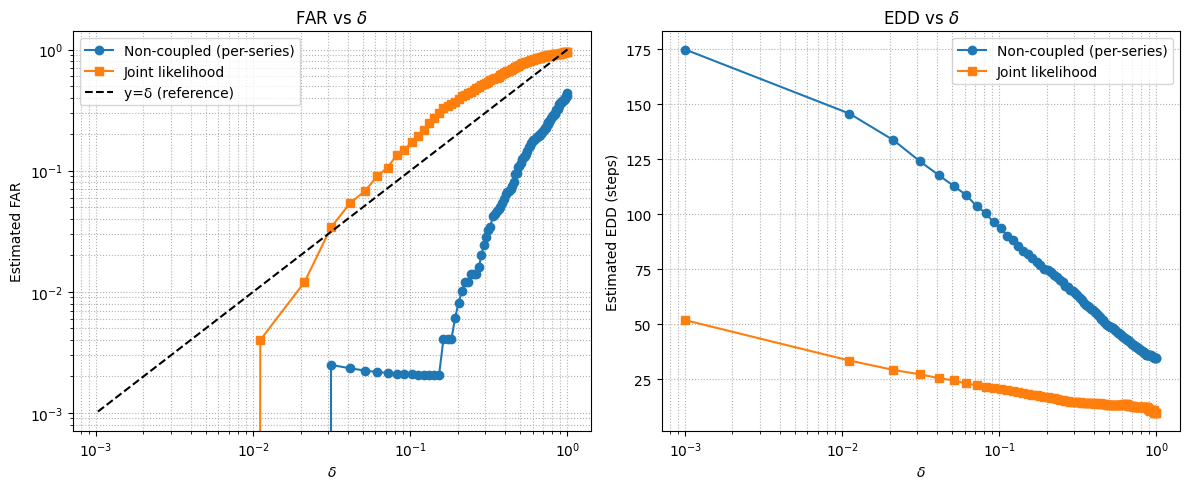

           detector     delta    FAR        EDD  EDD_median  n_runs
0        noncoupled  1.000000  0.434  34.734982        29.0     500
1  joint_likelihood  1.000000  0.952   9.833333         9.0     500
2        noncoupled  0.989909  0.416  34.674658        29.0     500
3  joint_likelihood  0.989909  0.948   9.653846         9.0     500
4        noncoupled  0.979818  0.414  34.853242        29.0     500


In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 5
T = 500
t0 = 250
theta0 = 0.2
theta1 = 0.4
num_changed = 5          # < J for selective coupling
alpha = 1.0               # Beta prior params
beta = 1.0
h = 0.0
R = 500                   # Monte Carlo runs

delta_grid = np.linspace(1, 0.001, 100)  # sweep δ values

# ---------------------------
# Helpers: Beta-Bernoulli log-marginals and Amax
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t(prefix_row, alpha, beta):
    """
    Compute Amax[t] for t=1..T (run starts at r=1) for ONE series.
    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split).
    Returns array shape (T+1,) 1-based; Amax[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def precompute_A_vals(Y, alpha, beta):
    """
    For a J x T panel Y, precompute A_vals[t,j]: per-series log-evidence (Amax).
    """
    J, Tlen = Y.shape
    prefix = np.zeros((J, Tlen + 1), dtype=int)
    for j in range(J):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J), -np.inf, dtype=float)
    for j in range(J):
        A_vals[:, j] = Amax_all_t(prefix[j], alpha, beta)

    return A_vals

def first_alarm_from_scores(S, h=0.0):
    """
    S: array shape (T+1, J) of scores S[t,j].
    Return first t where any S[t,j] >= h, or np.nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

# ---------------------------
# Hazards (single vs multi-iid exact ratio)
# ---------------------------
def log_hazard_single(delta, Tlen):
    """
    Single-series style hazard (Alami/Freedman):

        eta_t ~ δ^2 / [(t+1) log(t+1) log log(t+1)].

    We encode it as log eta_t.
    """
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(n) + np.log(np.log(n)))
    logeta[:2] = -np.inf  # disable t=0,1
    return logeta

def log_hazard_multi_exact_ratio(delta, Tlen, J):
    """
    Multi-iid hazard from the exact ratio:

        eta_t^(k) = eta_t^(1) * ((n+1)/(k n + 1)) * (log(4n)/log(4k n))

    where n = t+1, k = J.
    """
    logeta_single = log_hazard_single(delta, Tlen)
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    n_clipped = np.maximum(n, 1.0)

    k = float(J)
    num1 = n_clipped + 1.0
    den1 = k * n_clipped + 1.0
    frac1 = num1 / den1

    num2 = np.log(4.0 * n_clipped)
    den2 = np.log(4.0 * k * n_clipped)
    frac2 = num2 / den2

    ratio = frac1 * frac2
    ratio = np.clip(ratio, 1e-12, 1.0)   # 0 < ratio <= 1

    logeta_multi = logeta_single + np.log(ratio)#+ np.log(1/k)
    logeta_multi[:2] = -np.inf
    return logeta_multi

# ---------------------------
# Detectors: non-coupled vs joint-likelihood
# ---------------------------
def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Non-coupled detector with hazard η_t^(1):
    Run Alami independently on each series and stop when ANY series fires.
    """
    Tlen = A_vals.shape[0] - 1
    logeta = log_hazard_single(delta, Tlen)   # shape (T+1,)
    S_n = A_vals + logeta[:, None]           # broadcast over series
    return first_alarm_from_scores(S_n, h=h)

def alarm_joint_delta(A_vals, delta, h=0.0):
    """
    Joint-likelihood detector:
      - joint log e-process: log E_t^joint = sum_{ℓ=1}^J A_{t,ℓ}
      - hazard η_t^(k) from multi-iid exact ratio.

    Equivalent to flattening all J series and applying Alami to the joint BF.
    """
    Tlen, J_here = A_vals.shape[0] - 1, A_vals.shape[1]
    logeta_joint = log_hazard_multi_exact_ratio(delta, Tlen, J_here)  # shape (T+1,)

    # joint log BF per time t: sum over series
    logE_joint = np.sum(A_vals, axis=1)   # shape (T+1,)
    S_joint = logE_joint + logeta_joint   # shape (T+1,)

    # reuse first_alarm_from_scores by treating it as a single "series"
    S_joint_2d = S_joint[:, None]
    return first_alarm_from_scores(S_joint_2d, h=h)

# ---------------------------
# Monte Carlo experiment
# ---------------------------
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals = precompute_A_vals(Y, alpha, beta)
    precomp_list.append(A_vals)

rows = []
for delta in delta_grid:
    alarms_nc = []
    alarms_joint = []
    for A_vals in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta, h)
        t_j  = alarm_joint_delta(A_vals, delta, h)
        alarms_nc.append(t_nc)
        alarms_joint.append(t_j)

    alarms_nc = np.array(alarms_nc)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_nc, "noncoupled", delta))
    rows.append(summarize(alarms_joint, "joint_likelihood", delta))

results = pd.DataFrame(rows)

# ---------------------------
# Plot FAR and EDD vs delta
# ---------------------------
mask_nc = results["detector"] == "noncoupled"
mask_joint = results["detector"] == "joint_likelihood"

plt.figure(figsize=(12,5))
# FAR
plt.subplot(1,2,1)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "FAR"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "FAR"],
         marker="s", label="Joint likelihood")
plt.plot(delta_grid, delta_grid, "k--", label="y=δ (reference)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated FAR")
plt.title("FAR vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

# EDD
plt.subplot(1,2,2)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "EDD"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood")
plt.xscale("log")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated EDD (steps)")
plt.title("EDD vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

plt.tight_layout()
plt.show()

print(results.head())

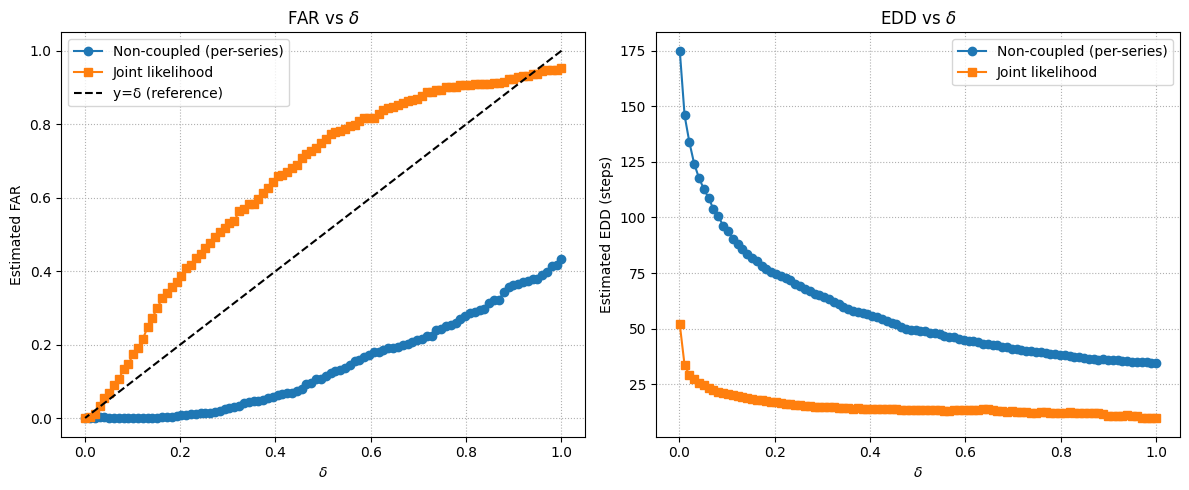

           detector     delta    FAR        EDD  EDD_median  n_runs
0        noncoupled  1.000000  0.434  34.734982        29.0     500
1  joint_likelihood  1.000000  0.952   9.833333         9.0     500
2        noncoupled  0.989909  0.416  34.674658        29.0     500
3  joint_likelihood  0.989909  0.948   9.653846         9.0     500
4        noncoupled  0.979818  0.414  34.853242        29.0     500


In [232]:
plt.figure(figsize=(12,5))
# FAR
plt.subplot(1,2,1)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "FAR"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "FAR"],
         marker="s", label="Joint likelihood")
plt.plot(delta_grid, delta_grid, "k--", label="y=δ (reference)")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated FAR")
plt.title("FAR vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

# EDD
plt.subplot(1,2,2)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "EDD"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated EDD (steps)")
plt.title("EDD vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

plt.tight_layout()
plt.show()

print(results.head())

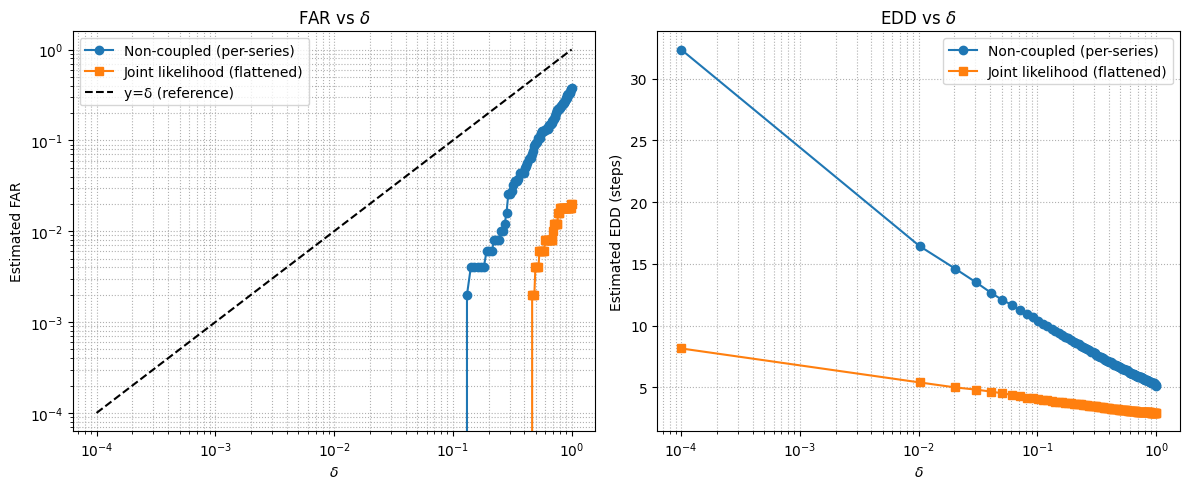

           detector   delta  FAR     EDD  EDD_median  n_runs
0        noncoupled  0.0001  0.0  32.374        31.0     500
1  joint_likelihood  0.0001  0.0   8.142         8.0     500
2        noncoupled  0.0102  0.0  16.432        16.0     500
3  joint_likelihood  0.0102  0.0   5.386         5.0     500
4        noncoupled  0.0203  0.0  14.606        14.0     500


In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaln

rng = np.random.default_rng(31415)

# ---------------------------
# Experiment design
# ---------------------------
J = 5
T = 200
t0 = 100               # change time (0-based in code)
theta0 = 0.2
theta1 = 0.8
num_changed = 40        # first num_changed series have change at t0
alpha = 1.0             # Beta prior hyperparams for Bernoulli (alpha,beta)
beta = 1.0
h = 0.0                 # detection threshold on score S>=h
R = 500                 # Monte Carlo runs

delta_grid = np.linspace(0.0001, 1, 100)  # sweep δ

# ---------------------------
# Helpers: Beta-Bernoulli log-marginals and Amax
# ---------------------------
def log_beta_vec(a, b):
    return gammaln(a) + gammaln(b) - gammaln(a + b)

def simulate_panel(T, t0, J, num_changed, theta0, theta1, rng):
    """
    Simulate J Bernoulli series with a changepoint at t0 in the first num_changed series.
    """
    Y = np.zeros((J, T), dtype=int)
    for j in range(J):
        if j < num_changed:
            probs = np.concatenate([np.full(t0, theta0), np.full(T - t0, theta1)])
        else:
            probs = np.full(T, theta0)
        Y[j, :] = rng.binomial(1, probs)
    return Y

def Amax_all_t_single(prefix_row, alpha, beta):
    """
    Per-series Amax[t] for t=1..T (run starts at r=1).

    Amax[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)] (log BF of best split)
    where L is the Beta-Bernoulli log-marginal for that series alone.

    Returns array shape (T+1,), 1-based; A[1] = -inf (no split possible).
    """
    Tlen = prefix_row.shape[0] - 1
    A = np.full(Tlen + 1, -np.inf, dtype=float)

    # Precompute L(1,t) for all t
    m_1t = prefix_row[1:] - prefix_row[0]          # successes in [1:t]
    ell_1t = np.arange(1, Tlen + 1, dtype=int)     # lengths
    L_1t = log_beta_vec(alpha + m_1t, beta + ell_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1)
        m_1_sm1 = prefix_row[s-1] - prefix_row[0]
        ell_1_sm1 = s - 1
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + ell_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t)
        m_s_t = prefix_row[t] - prefix_row[s-1]
        ell_s_t = t - s + 1
        L_s_t = log_beta_vec(alpha + m_s_t, beta + ell_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A[t] = np.max(vals)

    return A

def Amax_all_t_joint(prefix_joint, alpha, beta, J):
    """
    TRUE joint Amax[t] for flattened sample (multi-iid case).

    prefix_joint[t] = total successes over all J series up to time t.
    For block [1,t], total sample size is N_1t = J * t.
    We compute:

      A_joint[t] = max_s [-L(1,t) + L(1,s-1) + L(s,t)]

    where L(·,·) is the Beta-Bernoulli log marginal with sample sizes N_·:·.
    """
    Tlen = prefix_joint.shape[0] - 1
    A_joint = np.full(Tlen + 1, -np.inf, dtype=float)

    # L(1,t) for flattened data (total successes m_1t, total trials N_1t = J*t)
    m_1t = prefix_joint[1:] - prefix_joint[0]
    N_1t = J * np.arange(1, Tlen + 1, dtype=int)
    L_1t = log_beta_vec(alpha + m_1t, beta + N_1t - m_1t) - log_beta_vec(alpha, beta)

    # For each t, maximize over s in {2,...,t}
    for t in range(2, Tlen + 1):
        s = np.arange(2, t + 1, dtype=int)

        # L(1,s-1) joint
        m_1_sm1 = prefix_joint[s-1] - prefix_joint[0]
        N_1_sm1 = J * (s - 1)
        L_1_sm1 = log_beta_vec(alpha + m_1_sm1, beta + N_1_sm1 - m_1_sm1) - log_beta_vec(alpha, beta)

        # L(s,t) joint
        m_s_t = prefix_joint[t] - prefix_joint[s-1]
        N_s_t = J * (t - s + 1)
        L_s_t = log_beta_vec(alpha + m_s_t, beta + N_s_t - m_s_t) - log_beta_vec(alpha, beta)

        vals = -L_1t[t-1] + L_1_sm1 + L_s_t
        A_joint[t] = np.max(vals)

    return A_joint

def precompute_A_vals_and_joint(Y, alpha, beta):
    """
    For a J x T panel Y, precompute:
      - A_vals[t,j]: per-series log-evidence (Amax) for NON-coupled detector
      - A_joint[t]: true joint Amax for the flattened sample
    """
    J_here, Tlen = Y.shape

    # Per-series A_vals
    prefix = np.zeros((J_here, Tlen + 1), dtype=int)
    for j in range(J_here):
        prefix[j, 1:] = np.cumsum(Y[j, :])

    A_vals = np.full((Tlen + 1, J_here), -np.inf, dtype=float)
    for j in range(J_here):
        A_vals[:, j] = Amax_all_t_single(prefix[j], alpha, beta)

    # Flattened prefix for joint
    total = Y.sum(axis=0)    # successes at each time across all series
    prefix_joint = np.zeros(Tlen + 1, dtype=int)
    prefix_joint[1:] = np.cumsum(total)

    A_joint = Amax_all_t_joint(prefix_joint, alpha, beta, J_here)

    return A_vals, A_joint

def first_alarm_from_scores(S, h=0.0):
    """
    S: array shape (T+1, J_series) of scores S[t,j].
    Return first t where any S[t,j] >= h, or np.nan if no alarm.
    """
    mask = S >= h
    any_t = np.any(mask, axis=1)
    idx = np.where(any_t)[0]
    return float(idx[0]) if idx.size > 0 else np.nan

# ---------------------------
# Hazards (single vs multi-iid exact ratio)
# ---------------------------
def log_hazard_single(delta, Tlen):
    """
    Single-series style hazard (Alami/Freedman):

        eta_t ~ δ^2 / [(t+1) log(t+1) log log(t+1)].

    Encoded as log eta_t.
    """
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    with np.errstate(divide='ignore', invalid='ignore'):
        logeta = np.log(delta**2) - (np.log(n) + np.log(np.log(n)))
    logeta[:2] = -np.inf  # disable t=0,1
    return logeta

def log_hazard_multi_exact_ratio(delta, Tlen, J):
    """
    Multi-iid hazard from the exact ratio:

        eta_t^(k) = eta_t^(1) * ((n+1)/(k n + 1)) * (log(4n)/log(4k n))

    where n = t+1, k = J.
    """
    logeta_single = log_hazard_single(delta, Tlen)
    t = np.arange(Tlen + 1, dtype=float)
    n = t + 1.0
    n_clipped = np.maximum(n, 1.0)

    k = float(J)
    num1 = n_clipped + 1.0
    den1 = k * n_clipped + 1.0
    frac1 = num1 / den1

    num2 = np.log(4.0 * n_clipped)
    den2 = np.log(4.0 * k * n_clipped)
    frac2 = num2 / den2

    ratio = frac1 * frac2
    ratio = np.clip(ratio, 1e-12, 1.0)   # 0 < ratio <= 1

    logeta_multi = logeta_single + np.log(ratio)
    logeta_multi[:2] = -np.inf
    return logeta_multi

# ---------------------------
# Detectors: non-coupled vs joint-likelihood
# ---------------------------
def alarm_noncoupled_delta(A_vals, delta, h=0.0):
    """
    Non-coupled detector (baseline):
    Run Alami independently on each series using single-series hazard η_t^(1),
    and stop when ANY series fires.
    """
    Tlen = A_vals.shape[0] - 1
    logeta = log_hazard_single(delta, Tlen)   # shape (T+1,)
    S_n = A_vals + logeta[:, None]            # broadcast over series
    return first_alarm_from_scores(S_n, h=h)

def alarm_joint_delta(A_joint, delta, J, h=0.0):
    """
    TRUE joint-likelihood detector:

      - A_joint[t] is the log BF for the flattened sample (multi-iid case),
        computed by Amax_all_t_joint.
      - Uses multi-iid hazard η_t^(k) from the exact ratio.

    Equivalent to applying Alami to the flattened panel of size N_t = k*t.
    """
    Tlen = A_joint.shape[0] - 1
    logeta_joint = log_hazard_multi_exact_ratio(delta, Tlen, J)  # shape (T+1,)

    S_joint = A_joint + logeta_joint   # shape (T+1,)
    S_joint_2d = S_joint[:, None]      # fake 1-series for first_alarm_from_scores
    return first_alarm_from_scores(S_joint_2d, h=h)

# ---------------------------
# Monte Carlo experiment
# ---------------------------
precomp_list = []
for r in range(R):
    Y = simulate_panel(T, t0, J, num_changed, theta0, theta1, rng)
    A_vals, A_joint = precompute_A_vals_and_joint(Y, alpha, beta)
    precomp_list.append((A_vals, A_joint))

rows = []
for delta in delta_grid:
    alarms_nc = []
    alarms_joint = []
    for (A_vals, A_joint) in precomp_list:
        t_nc = alarm_noncoupled_delta(A_vals, delta, h)
        t_j  = alarm_joint_delta(A_joint, delta, J, h)
        alarms_nc.append(t_nc)
        alarms_joint.append(t_j)

    alarms_nc = np.array(alarms_nc)
    alarms_joint = np.array(alarms_joint)

    def summarize(alarm_times, label, delta_val):
        finite = np.isfinite(alarm_times)
        at = alarm_times[finite]
        if at.size > 0:
            far = float(np.mean(at < t0))
            dd = at[at >= t0] - t0
            edd = float(np.mean(dd)) if dd.size > 0 else np.nan
            edd_med = float(np.median(dd)) if dd.size > 0 else np.nan
        else:
            far = np.nan
            edd = np.nan
            edd_med = np.nan
        return {
            "detector": label,
            "delta": delta_val,
            "FAR": far,
            "EDD": edd,
            "EDD_median": edd_med,
            "n_runs": int(at.size),
        }

    rows.append(summarize(alarms_nc, "noncoupled", delta))
    rows.append(summarize(alarms_joint, "joint_likelihood", delta))

results = pd.DataFrame(rows)

# ---------------------------
# Plot FAR and EDD vs delta
# ---------------------------
mask_nc = results["detector"] == "noncoupled"
mask_joint = results["detector"] == "joint_likelihood"

plt.figure(figsize=(12,5))
# FAR
plt.subplot(1,2,1)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "FAR"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "FAR"],
         marker="s", label="Joint likelihood (flattened)")
plt.plot(delta_grid, delta_grid, "k--", label="y=δ (reference)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated FAR")
plt.title("FAR vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

# EDD
plt.subplot(1,2,2)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "EDD"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood (flattened)")
plt.xscale("log")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated EDD (steps)")
plt.title("EDD vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

plt.tight_layout()
plt.show()

print(results.head())


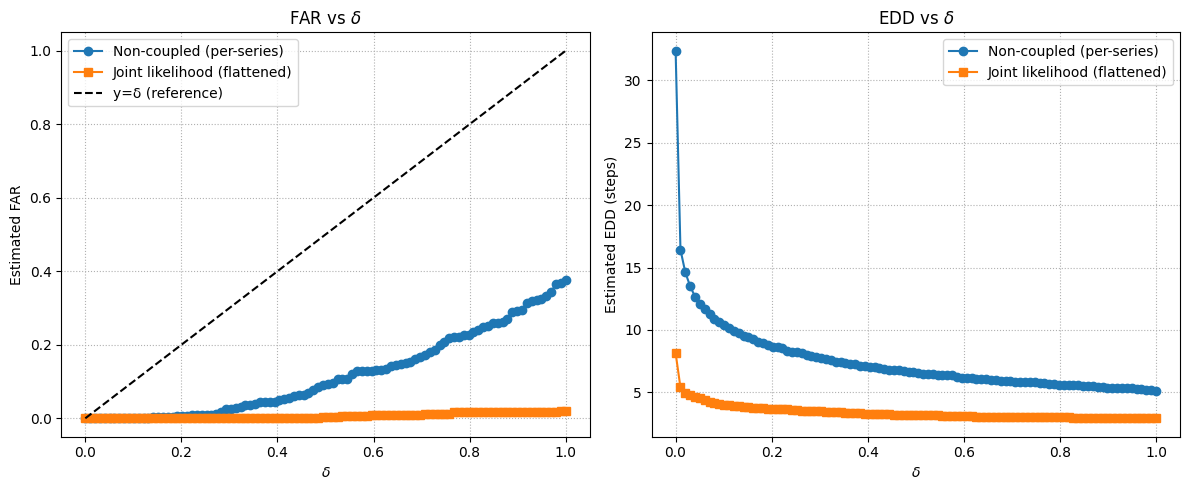

           detector   delta  FAR     EDD  EDD_median  n_runs
0        noncoupled  0.0001  0.0  32.374        31.0     500
1  joint_likelihood  0.0001  0.0   8.142         8.0     500
2        noncoupled  0.0102  0.0  16.432        16.0     500
3  joint_likelihood  0.0102  0.0   5.386         5.0     500
4        noncoupled  0.0203  0.0  14.606        14.0     500


In [240]:
plt.figure(figsize=(12,5))
# FAR
plt.subplot(1,2,1)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "FAR"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "FAR"],
         marker="s", label="Joint likelihood (flattened)")
plt.plot(delta_grid, delta_grid, "k--", label="y=δ (reference)")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated FAR")
plt.title("FAR vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

# EDD
plt.subplot(1,2,2)
plt.plot(results.loc[mask_nc, "delta"], results.loc[mask_nc, "EDD"],
         marker="o", label="Non-coupled (per-series)")
plt.plot(results.loc[mask_joint, "delta"], results.loc[mask_joint, "EDD"],
         marker="s", label="Joint likelihood (flattened)")
plt.xlabel(r"$\delta$")
plt.ylabel("Estimated EDD (steps)")
plt.title("EDD vs $\\delta$")
plt.grid(True, which="both", ls=":")
plt.legend()

plt.tight_layout()
plt.show()

print(results.head())